In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


Loaded 159606 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 vkur2fs8


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                              | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                                                                      | 1/1870 [00:00<24:41,  1.26it/s]

  0%|▏                                                                                                                                                     | 2/1870 [00:00<13:18,  2.34it/s]

  0%|▏                                                                                                                                                     | 3/1870 [00:01<09:39,  3.22it/s]

  0%|▎                                                                                                                                                     | 4/1870 [00:01<07:56,  3.91it/s]

  0%|▍                                                                                                                                                     | 5/1870 [00:01<07:00,  4.44it/s]

  0%|▍                                                                                                                                                     | 6/1870 [00:01<06:26,  4.83it/s]

  0%|▌                                                                                                                                                     | 7/1870 [00:01<06:04,  5.11it/s]

  0%|▋                                                                                                                                                     | 8/1870 [00:01<05:50,  5.31it/s]

  0%|▋                                                                                                                                                     | 9/1870 [00:02<05:41,  5.45it/s]

  1%|▊                                                                                                                                                    | 10/1870 [00:02<05:34,  5.56it/s]

  1%|▉                                                                                                                                                    | 11/1870 [00:02<05:30,  5.63it/s]

  1%|▉                                                                                                                                                    | 12/1870 [00:02<05:26,  5.69it/s]

  1%|█                                                                                                                                                    | 13/1870 [00:02<05:24,  5.73it/s]

  1%|█                                                                                                                                                    | 14/1870 [00:03<05:22,  5.75it/s]

  1%|█▏                                                                                                                                                   | 15/1870 [00:03<05:21,  5.77it/s]

  1%|█▎                                                                                                                                                   | 16/1870 [00:03<05:20,  5.79it/s]

  1%|█▎                                                                                                                                                   | 17/1870 [00:03<05:19,  5.80it/s]

  1%|█▍                                                                                                                                                   | 18/1870 [00:03<05:18,  5.81it/s]

  1%|█▌                                                                                                                                                   | 19/1870 [00:03<05:17,  5.82it/s]

  1%|█▌                                                                                                                                                   | 20/1870 [00:04<05:17,  5.82it/s]

  1%|█▋                                                                                                                                                   | 21/1870 [00:04<05:17,  5.82it/s]

  1%|█▊                                                                                                                                                   | 22/1870 [00:04<05:17,  5.82it/s]

  1%|█▊                                                                                                                                                   | 23/1870 [00:04<05:17,  5.82it/s]

  1%|█▉                                                                                                                                                   | 24/1870 [00:04<05:17,  5.82it/s]

  1%|█▉                                                                                                                                                   | 25/1870 [00:04<05:17,  5.82it/s]

  1%|██                                                                                                                                                   | 26/1870 [00:05<05:17,  5.81it/s]

  1%|██▏                                                                                                                                                  | 27/1870 [00:05<05:17,  5.81it/s]

  1%|██▏                                                                                                                                                  | 28/1870 [00:05<05:17,  5.80it/s]

  2%|██▎                                                                                                                                                  | 29/1870 [00:05<05:17,  5.80it/s]

  2%|██▍                                                                                                                                                  | 30/1870 [00:05<05:17,  5.80it/s]

  2%|██▍                                                                                                                                                  | 31/1870 [00:05<05:16,  5.81it/s]

  2%|██▌                                                                                                                                                  | 32/1870 [00:06<05:16,  5.81it/s]

  2%|██▋                                                                                                                                                  | 33/1870 [00:06<05:15,  5.82it/s]

  2%|██▋                                                                                                                                                  | 34/1870 [00:06<05:15,  5.82it/s]

  2%|██▊                                                                                                                                                  | 35/1870 [00:06<05:15,  5.82it/s]

  2%|██▊                                                                                                                                                  | 36/1870 [00:06<05:14,  5.83it/s]

  2%|██▉                                                                                                                                                  | 37/1870 [00:06<05:14,  5.83it/s]

  2%|███                                                                                                                                                  | 38/1870 [00:07<05:14,  5.82it/s]

  2%|███                                                                                                                                                  | 39/1870 [00:07<05:14,  5.82it/s]

  2%|███▏                                                                                                                                                 | 40/1870 [00:07<05:14,  5.82it/s]

  2%|███▎                                                                                                                                                 | 41/1870 [00:07<05:14,  5.82it/s]

  2%|███▎                                                                                                                                                 | 42/1870 [00:07<05:13,  5.82it/s]

  2%|███▍                                                                                                                                                 | 43/1870 [00:08<05:13,  5.82it/s]

  2%|███▌                                                                                                                                                 | 44/1870 [00:08<05:13,  5.82it/s]

  2%|███▌                                                                                                                                                 | 45/1870 [00:08<05:13,  5.82it/s]

  2%|███▋                                                                                                                                                 | 46/1870 [00:08<05:13,  5.81it/s]

  3%|███▋                                                                                                                                                 | 47/1870 [00:08<05:14,  5.80it/s]

  3%|███▊                                                                                                                                                 | 48/1870 [00:08<05:14,  5.80it/s]

  3%|███▉                                                                                                                                                 | 49/1870 [00:09<05:13,  5.80it/s]

  3%|███▉                                                                                                                                                 | 50/1870 [00:09<05:13,  5.80it/s]

  3%|████                                                                                                                                                 | 51/1870 [00:09<05:13,  5.81it/s]

  3%|████▏                                                                                                                                                | 52/1870 [00:09<05:12,  5.81it/s]

  3%|████▏                                                                                                                                                | 53/1870 [00:09<05:12,  5.81it/s]

  3%|████▎                                                                                                                                                | 54/1870 [00:09<05:12,  5.81it/s]

  3%|████▍                                                                                                                                                | 55/1870 [00:10<05:12,  5.81it/s]

  3%|████▍                                                                                                                                                | 56/1870 [00:10<05:11,  5.82it/s]

  3%|████▌                                                                                                                                                | 57/1870 [00:10<05:11,  5.82it/s]

  3%|████▌                                                                                                                                                | 58/1870 [00:10<05:11,  5.82it/s]

  3%|████▋                                                                                                                                                | 59/1870 [00:10<05:11,  5.82it/s]

  3%|████▊                                                                                                                                                | 60/1870 [00:10<05:11,  5.82it/s]

  3%|████▊                                                                                                                                                | 61/1870 [00:11<05:10,  5.82it/s]

  3%|████▉                                                                                                                                                | 62/1870 [00:11<05:10,  5.82it/s]

  3%|█████                                                                                                                                                | 63/1870 [00:11<05:10,  5.82it/s]

  3%|█████                                                                                                                                                | 64/1870 [00:11<05:10,  5.82it/s]

  3%|█████▏                                                                                                                                               | 65/1870 [00:11<05:09,  5.82it/s]

  4%|█████▎                                                                                                                                               | 66/1870 [00:11<05:09,  5.83it/s]

  4%|█████▎                                                                                                                                               | 67/1870 [00:12<05:09,  5.82it/s]

  4%|█████▍                                                                                                                                               | 68/1870 [00:12<05:09,  5.82it/s]

  4%|█████▍                                                                                                                                               | 69/1870 [00:12<05:09,  5.81it/s]

  4%|█████▌                                                                                                                                               | 70/1870 [00:12<05:09,  5.81it/s]

  4%|█████▋                                                                                                                                               | 71/1870 [00:12<05:09,  5.81it/s]

  4%|█████▋                                                                                                                                               | 72/1870 [00:13<05:09,  5.81it/s]

  4%|█████▊                                                                                                                                               | 73/1870 [00:13<05:09,  5.81it/s]

  4%|█████▉                                                                                                                                               | 74/1870 [00:13<05:09,  5.80it/s]

  4%|█████▉                                                                                                                                               | 75/1870 [00:13<05:09,  5.80it/s]

  4%|██████                                                                                                                                               | 76/1870 [00:13<05:08,  5.81it/s]

  4%|██████▏                                                                                                                                              | 77/1870 [00:13<05:08,  5.81it/s]

  4%|██████▏                                                                                                                                              | 78/1870 [00:14<05:08,  5.81it/s]

  4%|██████▎                                                                                                                                              | 79/1870 [00:14<05:07,  5.82it/s]

  4%|██████▎                                                                                                                                              | 80/1870 [00:14<05:07,  5.82it/s]

  4%|██████▍                                                                                                                                              | 81/1870 [00:14<05:07,  5.82it/s]

  4%|██████▌                                                                                                                                              | 82/1870 [00:14<05:07,  5.82it/s]

  4%|██████▌                                                                                                                                              | 83/1870 [00:14<05:06,  5.82it/s]

  4%|██████▋                                                                                                                                              | 84/1870 [00:15<05:06,  5.83it/s]

  5%|██████▊                                                                                                                                              | 85/1870 [00:15<05:06,  5.82it/s]

  5%|██████▊                                                                                                                                              | 86/1870 [00:15<05:06,  5.82it/s]

  5%|██████▉                                                                                                                                              | 87/1870 [00:15<05:06,  5.82it/s]

  5%|███████                                                                                                                                              | 88/1870 [00:15<05:06,  5.82it/s]

  5%|███████                                                                                                                                              | 89/1870 [00:15<05:06,  5.82it/s]

  5%|███████▏                                                                                                                                             | 90/1870 [00:16<05:06,  5.81it/s]

  5%|███████▎                                                                                                                                             | 91/1870 [00:16<05:06,  5.81it/s]

  5%|███████▎                                                                                                                                             | 92/1870 [00:16<05:06,  5.81it/s]

  5%|███████▍                                                                                                                                             | 93/1870 [00:16<05:06,  5.81it/s]

  5%|███████▍                                                                                                                                             | 94/1870 [00:16<05:05,  5.81it/s]

  5%|███████▌                                                                                                                                             | 95/1870 [00:16<05:05,  5.81it/s]

  5%|███████▋                                                                                                                                             | 96/1870 [00:17<05:04,  5.82it/s]

  5%|███████▋                                                                                                                                             | 97/1870 [00:17<05:03,  5.84it/s]

  5%|███████▊                                                                                                                                             | 98/1870 [00:17<05:03,  5.85it/s]

  5%|███████▉                                                                                                                                             | 99/1870 [00:17<05:02,  5.85it/s]

  5%|███████▉                                                                                                                                            | 100/1870 [00:17<05:02,  5.86it/s]

  5%|███████▉                                                                                                                                            | 101/1870 [00:17<05:01,  5.86it/s]

  5%|████████                                                                                                                                            | 102/1870 [00:18<05:02,  5.85it/s]

  6%|████████▏                                                                                                                                           | 103/1870 [00:18<05:02,  5.84it/s]

  6%|████████▏                                                                                                                                           | 104/1870 [00:18<05:02,  5.83it/s]

  6%|████████▎                                                                                                                                           | 105/1870 [00:18<05:02,  5.83it/s]

  6%|████████▍                                                                                                                                           | 106/1870 [00:18<05:02,  5.82it/s]

  6%|████████▍                                                                                                                                           | 107/1870 [00:19<05:02,  5.82it/s]

  6%|████████▌                                                                                                                                           | 108/1870 [00:19<05:02,  5.83it/s]

  6%|████████▋                                                                                                                                           | 109/1870 [00:19<05:02,  5.82it/s]

  6%|████████▋                                                                                                                                           | 110/1870 [00:19<05:02,  5.82it/s]

  6%|████████▊                                                                                                                                           | 111/1870 [00:19<05:02,  5.82it/s]

  6%|████████▊                                                                                                                                           | 112/1870 [00:19<05:02,  5.82it/s]

  6%|████████▉                                                                                                                                           | 113/1870 [00:20<05:02,  5.81it/s]

  6%|█████████                                                                                                                                           | 114/1870 [00:20<05:02,  5.81it/s]

  6%|█████████                                                                                                                                           | 115/1870 [00:20<05:02,  5.80it/s]

  6%|█████████▏                                                                                                                                          | 116/1870 [00:20<05:02,  5.80it/s]

  6%|█████████▎                                                                                                                                          | 117/1870 [00:20<05:02,  5.80it/s]

  6%|█████████▎                                                                                                                                          | 118/1870 [00:20<05:01,  5.81it/s]

  6%|█████████▍                                                                                                                                          | 119/1870 [00:21<05:01,  5.81it/s]

  6%|█████████▍                                                                                                                                          | 120/1870 [00:21<05:00,  5.82it/s]

  6%|█████████▌                                                                                                                                          | 121/1870 [00:21<05:00,  5.82it/s]

  7%|█████████▋                                                                                                                                          | 122/1870 [00:21<05:00,  5.82it/s]

  7%|█████████▋                                                                                                                                          | 123/1870 [00:21<05:00,  5.82it/s]

  7%|█████████▊                                                                                                                                          | 124/1870 [00:21<05:00,  5.82it/s]

  7%|█████████▉                                                                                                                                          | 125/1870 [00:22<04:59,  5.82it/s]

  7%|█████████▉                                                                                                                                          | 126/1870 [00:22<04:59,  5.82it/s]

  7%|██████████                                                                                                                                          | 127/1870 [00:22<04:59,  5.83it/s]

  7%|██████████▏                                                                                                                                         | 128/1870 [00:22<04:58,  5.83it/s]

  7%|██████████▏                                                                                                                                         | 129/1870 [00:22<04:59,  5.82it/s]

  7%|██████████▎                                                                                                                                         | 130/1870 [00:22<04:59,  5.80it/s]

  7%|██████████▎                                                                                                                                         | 131/1870 [00:23<04:59,  5.81it/s]

  7%|██████████▍                                                                                                                                         | 132/1870 [00:23<04:58,  5.81it/s]

  7%|██████████▌                                                                                                                                         | 133/1870 [00:23<04:58,  5.82it/s]

  7%|██████████▌                                                                                                                                         | 134/1870 [00:23<04:58,  5.81it/s]

  7%|██████████▋                                                                                                                                         | 135/1870 [00:23<04:58,  5.81it/s]

  7%|██████████▊                                                                                                                                         | 136/1870 [00:23<04:58,  5.81it/s]

  7%|██████████▊                                                                                                                                         | 137/1870 [00:24<04:58,  5.80it/s]

  7%|██████████▉                                                                                                                                         | 138/1870 [00:24<04:58,  5.80it/s]

  7%|███████████                                                                                                                                         | 139/1870 [00:24<04:58,  5.81it/s]

  7%|███████████                                                                                                                                         | 140/1870 [00:24<04:57,  5.81it/s]

  8%|███████████▏                                                                                                                                        | 141/1870 [00:24<04:57,  5.81it/s]

  8%|███████████▏                                                                                                                                        | 142/1870 [00:25<04:57,  5.82it/s]

  8%|███████████▎                                                                                                                                        | 143/1870 [00:25<04:56,  5.82it/s]

  8%|███████████▍                                                                                                                                        | 144/1870 [00:25<04:56,  5.81it/s]

  8%|███████████▍                                                                                                                                        | 145/1870 [00:25<04:56,  5.82it/s]

  8%|███████████▌                                                                                                                                        | 146/1870 [00:25<04:56,  5.82it/s]

  8%|███████████▋                                                                                                                                        | 147/1870 [00:25<04:55,  5.82it/s]

  8%|███████████▋                                                                                                                                        | 148/1870 [00:26<04:55,  5.83it/s]

  8%|███████████▊                                                                                                                                        | 149/1870 [00:26<04:55,  5.83it/s]

  8%|███████████▊                                                                                                                                        | 150/1870 [00:26<04:55,  5.83it/s]

  8%|███████████▉                                                                                                                                        | 151/1870 [00:26<04:55,  5.82it/s]

  8%|████████████                                                                                                                                        | 152/1870 [00:26<04:54,  5.84it/s]

  8%|████████████                                                                                                                                        | 153/1870 [00:26<04:53,  5.85it/s]

  8%|████████████▏                                                                                                                                       | 154/1870 [00:27<04:52,  5.86it/s]

  8%|████████████▎                                                                                                                                       | 155/1870 [00:27<04:52,  5.86it/s]

  8%|████████████▎                                                                                                                                       | 156/1870 [00:27<04:52,  5.86it/s]

  8%|████████████▍                                                                                                                                       | 157/1870 [00:27<04:52,  5.87it/s]

  8%|████████████▌                                                                                                                                       | 158/1870 [00:27<04:52,  5.85it/s]

  9%|████████████▌                                                                                                                                       | 159/1870 [00:27<04:53,  5.84it/s]

  9%|████████████▋                                                                                                                                       | 160/1870 [00:28<04:53,  5.83it/s]

  9%|████████████▋                                                                                                                                       | 161/1870 [00:28<04:53,  5.82it/s]

  9%|████████████▊                                                                                                                                       | 162/1870 [00:28<04:53,  5.81it/s]

  9%|████████████▉                                                                                                                                       | 163/1870 [00:28<04:53,  5.81it/s]

  9%|████████████▉                                                                                                                                       | 164/1870 [00:28<04:53,  5.81it/s]

  9%|█████████████                                                                                                                                       | 165/1870 [00:28<04:53,  5.81it/s]

  9%|█████████████▏                                                                                                                                      | 166/1870 [00:29<04:53,  5.81it/s]

  9%|█████████████▏                                                                                                                                      | 167/1870 [00:29<04:52,  5.81it/s]

  9%|█████████████▎                                                                                                                                      | 168/1870 [00:29<04:52,  5.82it/s]

  9%|█████████████▍                                                                                                                                      | 169/1870 [00:29<04:52,  5.82it/s]

  9%|█████████████▍                                                                                                                                      | 170/1870 [00:29<04:51,  5.83it/s]

  9%|█████████████▌                                                                                                                                      | 171/1870 [00:30<04:51,  5.83it/s]

  9%|█████████████▌                                                                                                                                      | 172/1870 [00:30<04:51,  5.82it/s]

  9%|█████████████▋                                                                                                                                      | 173/1870 [00:30<04:51,  5.82it/s]

  9%|█████████████▊                                                                                                                                      | 174/1870 [00:30<04:51,  5.82it/s]

  9%|█████████████▊                                                                                                                                      | 175/1870 [00:30<04:51,  5.82it/s]

  9%|█████████████▉                                                                                                                                      | 176/1870 [00:30<04:50,  5.82it/s]

  9%|██████████████                                                                                                                                      | 177/1870 [00:31<04:50,  5.82it/s]

 10%|██████████████                                                                                                                                      | 178/1870 [00:31<04:50,  5.82it/s]

 10%|██████████████▏                                                                                                                                     | 179/1870 [00:31<04:50,  5.82it/s]

 10%|██████████████▏                                                                                                                                     | 180/1870 [00:31<04:50,  5.82it/s]

 10%|██████████████▎                                                                                                                                     | 181/1870 [00:31<04:50,  5.81it/s]

 10%|██████████████▍                                                                                                                                     | 182/1870 [00:31<04:50,  5.81it/s]

 10%|██████████████▍                                                                                                                                     | 183/1870 [00:32<04:50,  5.81it/s]

 10%|██████████████▌                                                                                                                                     | 184/1870 [00:32<04:50,  5.81it/s]

 10%|██████████████▋                                                                                                                                     | 185/1870 [00:32<04:49,  5.81it/s]

 10%|██████████████▋                                                                                                                                     | 186/1870 [00:32<04:50,  5.80it/s]

 10%|██████████████▊                                                                                                                                     | 187/1870 [00:32<04:49,  5.81it/s]

 10%|██████████████▉                                                                                                                                     | 188/1870 [00:32<04:49,  5.81it/s]

 10%|██████████████▉                                                                                                                                     | 189/1870 [00:33<04:49,  5.81it/s]

 10%|███████████████                                                                                                                                     | 190/1870 [00:33<04:48,  5.82it/s]

 10%|███████████████                                                                                                                                     | 191/1870 [00:33<04:48,  5.82it/s]

 10%|███████████████▏                                                                                                                                    | 192/1870 [00:33<04:48,  5.82it/s]

 10%|███████████████▎                                                                                                                                    | 193/1870 [00:33<04:48,  5.82it/s]

 10%|███████████████▎                                                                                                                                    | 194/1870 [00:33<04:47,  5.82it/s]

 10%|███████████████▍                                                                                                                                    | 195/1870 [00:34<04:47,  5.82it/s]

 10%|███████████████▌                                                                                                                                    | 196/1870 [00:34<04:47,  5.82it/s]

 11%|███████████████▌                                                                                                                                    | 197/1870 [00:34<04:47,  5.83it/s]

 11%|███████████████▋                                                                                                                                    | 198/1870 [00:34<04:47,  5.83it/s]

 11%|███████████████▋                                                                                                                                    | 199/1870 [00:34<04:46,  5.83it/s]

 11%|███████████████▊                                                                                                                                    | 200/1870 [00:34<04:46,  5.82it/s]

 11%|███████████████▉                                                                                                                                    | 201/1870 [00:35<04:46,  5.82it/s]

 11%|███████████████▉                                                                                                                                    | 202/1870 [00:35<04:46,  5.82it/s]

 11%|████████████████                                                                                                                                    | 203/1870 [00:35<04:46,  5.83it/s]

 11%|████████████████▏                                                                                                                                   | 204/1870 [00:35<04:46,  5.82it/s]

 11%|████████████████▏                                                                                                                                   | 205/1870 [00:35<04:46,  5.82it/s]

 11%|████████████████▎                                                                                                                                   | 206/1870 [00:36<04:46,  5.81it/s]

 11%|████████████████▍                                                                                                                                   | 207/1870 [00:36<04:46,  5.81it/s]

 11%|████████████████▍                                                                                                                                   | 208/1870 [00:36<04:45,  5.82it/s]

 11%|████████████████▌                                                                                                                                   | 209/1870 [00:36<04:44,  5.83it/s]

 11%|████████████████▌                                                                                                                                   | 210/1870 [00:36<04:44,  5.84it/s]

 11%|████████████████▋                                                                                                                                   | 211/1870 [00:36<04:43,  5.85it/s]

 11%|████████████████▊                                                                                                                                   | 212/1870 [00:37<04:43,  5.85it/s]

 11%|████████████████▊                                                                                                                                   | 213/1870 [00:37<04:42,  5.86it/s]

 11%|████████████████▉                                                                                                                                   | 214/1870 [00:37<04:43,  5.85it/s]

 11%|█████████████████                                                                                                                                   | 215/1870 [00:37<04:43,  5.85it/s]

 12%|█████████████████                                                                                                                                   | 216/1870 [00:37<04:43,  5.84it/s]

 12%|█████████████████▏                                                                                                                                  | 217/1870 [00:37<04:43,  5.84it/s]

 12%|█████████████████▎                                                                                                                                  | 218/1870 [00:38<04:43,  5.83it/s]

 12%|█████████████████▎                                                                                                                                  | 219/1870 [00:38<04:43,  5.83it/s]

 12%|█████████████████▍                                                                                                                                  | 220/1870 [00:38<04:43,  5.83it/s]

 12%|█████████████████▍                                                                                                                                  | 221/1870 [00:38<04:43,  5.82it/s]

 12%|█████████████████▌                                                                                                                                  | 222/1870 [00:38<04:43,  5.82it/s]

 12%|█████████████████▋                                                                                                                                  | 223/1870 [00:38<04:42,  5.82it/s]

 12%|█████████████████▋                                                                                                                                  | 224/1870 [00:39<04:42,  5.82it/s]

 12%|█████████████████▊                                                                                                                                  | 225/1870 [00:39<04:42,  5.83it/s]

 12%|█████████████████▉                                                                                                                                  | 226/1870 [00:39<04:42,  5.82it/s]

 12%|█████████████████▉                                                                                                                                  | 227/1870 [00:39<04:42,  5.82it/s]

 12%|██████████████████                                                                                                                                  | 228/1870 [00:39<04:43,  5.80it/s]

 12%|██████████████████                                                                                                                                  | 229/1870 [00:39<04:42,  5.80it/s]

 12%|██████████████████▏                                                                                                                                 | 230/1870 [00:40<04:42,  5.80it/s]

 12%|██████████████████▎                                                                                                                                 | 231/1870 [00:40<04:42,  5.80it/s]

 12%|██████████████████▎                                                                                                                                 | 232/1870 [00:40<04:42,  5.81it/s]

 12%|██████████████████▍                                                                                                                                 | 233/1870 [00:40<04:41,  5.81it/s]

 13%|██████████████████▌                                                                                                                                 | 234/1870 [00:40<04:41,  5.82it/s]

 13%|██████████████████▌                                                                                                                                 | 235/1870 [00:40<04:41,  5.81it/s]

 13%|██████████████████▋                                                                                                                                 | 236/1870 [00:41<04:40,  5.82it/s]

 13%|██████████████████▊                                                                                                                                 | 237/1870 [00:41<04:40,  5.82it/s]

 13%|██████████████████▊                                                                                                                                 | 238/1870 [00:41<04:40,  5.82it/s]

 13%|██████████████████▉                                                                                                                                 | 239/1870 [00:41<04:40,  5.82it/s]

 13%|██████████████████▉                                                                                                                                 | 240/1870 [00:41<04:40,  5.82it/s]

 13%|███████████████████                                                                                                                                 | 241/1870 [00:42<04:39,  5.82it/s]

 13%|███████████████████▏                                                                                                                                | 242/1870 [00:42<04:39,  5.82it/s]

 13%|███████████████████▏                                                                                                                                | 243/1870 [00:42<04:39,  5.82it/s]

 13%|███████████████████▎                                                                                                                                | 244/1870 [00:42<04:39,  5.82it/s]

 13%|███████████████████▍                                                                                                                                | 245/1870 [00:42<04:39,  5.82it/s]

 13%|███████████████████▍                                                                                                                                | 246/1870 [00:42<04:39,  5.82it/s]

 13%|███████████████████▌                                                                                                                                | 247/1870 [00:43<04:39,  5.82it/s]

 13%|███████████████████▋                                                                                                                                | 248/1870 [00:43<04:39,  5.81it/s]

 13%|███████████████████▋                                                                                                                                | 249/1870 [00:43<04:39,  5.80it/s]

 13%|███████████████████▊                                                                                                                                | 250/1870 [00:43<04:39,  5.80it/s]

 13%|███████████████████▊                                                                                                                                | 251/1870 [00:43<04:39,  5.80it/s]

 13%|███████████████████▉                                                                                                                                | 252/1870 [00:43<04:38,  5.80it/s]

 14%|████████████████████                                                                                                                                | 253/1870 [00:44<04:38,  5.81it/s]

 14%|████████████████████                                                                                                                                | 254/1870 [00:44<04:37,  5.81it/s]

 14%|████████████████████▏                                                                                                                               | 255/1870 [00:44<04:37,  5.82it/s]

 14%|████████████████████▎                                                                                                                               | 256/1870 [00:44<04:37,  5.82it/s]

 14%|████████████████████▎                                                                                                                               | 257/1870 [00:44<04:37,  5.82it/s]

 14%|████████████████████▍                                                                                                                               | 258/1870 [00:44<04:37,  5.82it/s]

 14%|████████████████████▍                                                                                                                               | 259/1870 [00:45<04:36,  5.84it/s]

 14%|████████████████████▌                                                                                                                               | 260/1870 [00:45<04:35,  5.85it/s]

 14%|████████████████████▋                                                                                                                               | 261/1870 [00:45<04:34,  5.86it/s]

 14%|████████████████████▋                                                                                                                               | 262/1870 [00:45<04:34,  5.86it/s]

 14%|████████████████████▊                                                                                                                               | 263/1870 [00:45<04:34,  5.86it/s]

 14%|████████████████████▉                                                                                                                               | 264/1870 [00:45<04:33,  5.87it/s]

 14%|████████████████████▉                                                                                                                               | 265/1870 [00:46<04:34,  5.85it/s]

 14%|█████████████████████                                                                                                                               | 266/1870 [00:46<04:34,  5.84it/s]

 14%|█████████████████████▏                                                                                                                              | 267/1870 [00:46<04:34,  5.83it/s]

 14%|█████████████████████▏                                                                                                                              | 268/1870 [00:46<04:35,  5.82it/s]

 14%|█████████████████████▎                                                                                                                              | 269/1870 [00:46<04:35,  5.82it/s]

 14%|█████████████████████▎                                                                                                                              | 270/1870 [00:47<04:35,  5.81it/s]

 14%|█████████████████████▍                                                                                                                              | 271/1870 [00:47<04:35,  5.81it/s]

 15%|█████████████████████▌                                                                                                                              | 272/1870 [00:47<04:35,  5.80it/s]

 15%|█████████████████████▌                                                                                                                              | 273/1870 [00:47<04:34,  5.81it/s]

 15%|█████████████████████▋                                                                                                                              | 274/1870 [00:47<04:34,  5.81it/s]

 15%|█████████████████████▊                                                                                                                              | 275/1870 [00:47<04:34,  5.82it/s]

 15%|█████████████████████▊                                                                                                                              | 276/1870 [00:48<04:33,  5.82it/s]

 15%|█████████████████████▉                                                                                                                              | 277/1870 [00:48<04:33,  5.83it/s]

 15%|██████████████████████                                                                                                                              | 278/1870 [00:48<04:33,  5.83it/s]

 15%|██████████████████████                                                                                                                              | 279/1870 [00:48<04:33,  5.82it/s]

 15%|██████████████████████▏                                                                                                                             | 280/1870 [00:48<04:32,  5.83it/s]

 15%|██████████████████████▏                                                                                                                             | 281/1870 [00:48<04:32,  5.83it/s]

 15%|██████████████████████▎                                                                                                                             | 282/1870 [00:49<04:32,  5.83it/s]

 15%|██████████████████████▍                                                                                                                             | 283/1870 [00:49<04:32,  5.83it/s]

 15%|██████████████████████▍                                                                                                                             | 284/1870 [00:49<04:32,  5.83it/s]

 15%|██████████████████████▌                                                                                                                             | 285/1870 [00:49<04:32,  5.82it/s]

 15%|██████████████████████▋                                                                                                                             | 286/1870 [00:49<04:32,  5.82it/s]

 15%|██████████████████████▋                                                                                                                             | 287/1870 [00:49<04:31,  5.83it/s]

 15%|██████████████████████▊                                                                                                                             | 288/1870 [00:50<04:31,  5.83it/s]

 15%|██████████████████████▊                                                                                                                             | 289/1870 [00:50<04:31,  5.83it/s]

 16%|██████████████████████▉                                                                                                                             | 290/1870 [00:50<04:31,  5.82it/s]

 16%|███████████████████████                                                                                                                             | 291/1870 [00:50<04:31,  5.82it/s]

 16%|███████████████████████                                                                                                                             | 292/1870 [00:50<04:31,  5.82it/s]

 16%|███████████████████████▏                                                                                                                            | 293/1870 [00:50<04:30,  5.82it/s]

 16%|███████████████████████▎                                                                                                                            | 294/1870 [00:51<04:30,  5.82it/s]

 16%|███████████████████████▎                                                                                                                            | 295/1870 [00:51<04:30,  5.81it/s]

 16%|███████████████████████▍                                                                                                                            | 296/1870 [00:51<04:31,  5.81it/s]

 16%|███████████████████████▌                                                                                                                            | 297/1870 [00:51<04:30,  5.81it/s]

 16%|███████████████████████▌                                                                                                                            | 298/1870 [00:51<04:30,  5.81it/s]

 16%|███████████████████████▋                                                                                                                            | 299/1870 [00:51<04:30,  5.80it/s]

 16%|███████████████████████▋                                                                                                                            | 300/1870 [00:52<04:30,  5.81it/s]

 16%|███████████████████████▊                                                                                                                            | 301/1870 [00:52<04:30,  5.81it/s]

 16%|███████████████████████▉                                                                                                                            | 302/1870 [00:52<04:29,  5.81it/s]

 16%|███████████████████████▉                                                                                                                            | 303/1870 [00:52<04:29,  5.82it/s]

 16%|████████████████████████                                                                                                                            | 304/1870 [00:52<04:29,  5.82it/s]

 16%|████████████████████████▏                                                                                                                           | 305/1870 [00:53<04:28,  5.82it/s]

 16%|████████████████████████▏                                                                                                                           | 306/1870 [00:53<04:28,  5.82it/s]

 16%|████████████████████████▎                                                                                                                           | 307/1870 [00:53<04:28,  5.82it/s]

 16%|████████████████████████▍                                                                                                                           | 308/1870 [00:53<04:28,  5.82it/s]

 17%|████████████████████████▍                                                                                                                           | 309/1870 [00:53<04:27,  5.83it/s]

 17%|████████████████████████▌                                                                                                                           | 310/1870 [00:53<04:27,  5.83it/s]

 17%|████████████████████████▌                                                                                                                           | 311/1870 [00:54<04:27,  5.82it/s]

 17%|████████████████████████▋                                                                                                                           | 312/1870 [00:54<04:27,  5.82it/s]

 17%|████████████████████████▊                                                                                                                           | 313/1870 [00:54<04:27,  5.82it/s]

 17%|████████████████████████▊                                                                                                                           | 314/1870 [00:54<04:26,  5.83it/s]

 17%|████████████████████████▉                                                                                                                           | 315/1870 [00:54<04:26,  5.84it/s]

 17%|█████████████████████████                                                                                                                           | 316/1870 [00:54<04:26,  5.84it/s]

 17%|█████████████████████████                                                                                                                           | 317/1870 [00:55<04:25,  5.84it/s]

 17%|█████████████████████████▏                                                                                                                          | 318/1870 [00:55<04:26,  5.83it/s]

 17%|█████████████████████████▏                                                                                                                          | 319/1870 [00:55<04:26,  5.83it/s]

 17%|█████████████████████████▎                                                                                                                          | 320/1870 [00:55<04:25,  5.83it/s]

 17%|█████████████████████████▍                                                                                                                          | 321/1870 [00:55<04:25,  5.83it/s]

 17%|█████████████████████████▍                                                                                                                          | 322/1870 [00:55<04:25,  5.83it/s]

 17%|█████████████████████████▌                                                                                                                          | 323/1870 [00:56<04:25,  5.82it/s]

 17%|█████████████████████████▋                                                                                                                          | 324/1870 [00:56<04:25,  5.82it/s]

 17%|█████████████████████████▋                                                                                                                          | 325/1870 [00:56<04:25,  5.82it/s]

 17%|█████████████████████████▊                                                                                                                          | 326/1870 [00:56<04:25,  5.82it/s]

 17%|█████████████████████████▉                                                                                                                          | 327/1870 [00:56<04:25,  5.82it/s]

 18%|█████████████████████████▉                                                                                                                          | 328/1870 [00:56<04:25,  5.82it/s]

 18%|██████████████████████████                                                                                                                          | 329/1870 [00:57<04:25,  5.81it/s]

 18%|██████████████████████████                                                                                                                          | 330/1870 [00:57<04:24,  5.82it/s]

 18%|██████████████████████████▏                                                                                                                         | 331/1870 [00:57<04:24,  5.82it/s]

 18%|██████████████████████████▎                                                                                                                         | 332/1870 [00:57<04:24,  5.81it/s]

 18%|██████████████████████████▎                                                                                                                         | 333/1870 [00:57<04:24,  5.80it/s]

 18%|██████████████████████████▍                                                                                                                         | 334/1870 [00:58<04:24,  5.81it/s]

 18%|██████████████████████████▌                                                                                                                         | 335/1870 [00:58<04:24,  5.81it/s]

 18%|██████████████████████████▌                                                                                                                         | 336/1870 [00:58<04:24,  5.80it/s]

 18%|██████████████████████████▋                                                                                                                         | 337/1870 [00:58<04:24,  5.80it/s]

 18%|██████████████████████████▊                                                                                                                         | 338/1870 [00:58<04:24,  5.80it/s]

 18%|██████████████████████████▊                                                                                                                         | 339/1870 [00:58<04:23,  5.80it/s]

 18%|██████████████████████████▉                                                                                                                         | 340/1870 [00:59<04:23,  5.81it/s]

 18%|██████████████████████████▉                                                                                                                         | 341/1870 [00:59<04:22,  5.81it/s]

 18%|███████████████████████████                                                                                                                         | 342/1870 [00:59<04:22,  5.82it/s]

 18%|███████████████████████████▏                                                                                                                        | 343/1870 [00:59<04:22,  5.82it/s]

 18%|███████████████████████████▏                                                                                                                        | 344/1870 [00:59<04:22,  5.82it/s]

 18%|███████████████████████████▎                                                                                                                        | 345/1870 [00:59<04:22,  5.82it/s]

 19%|███████████████████████████▍                                                                                                                        | 346/1870 [01:00<04:21,  5.82it/s]

 19%|███████████████████████████▍                                                                                                                        | 347/1870 [01:00<04:21,  5.82it/s]

 19%|███████████████████████████▌                                                                                                                        | 348/1870 [01:00<04:21,  5.82it/s]

 19%|███████████████████████████▌                                                                                                                        | 349/1870 [01:00<04:21,  5.82it/s]

 19%|███████████████████████████▋                                                                                                                        | 350/1870 [01:00<04:21,  5.82it/s]

 19%|███████████████████████████▊                                                                                                                        | 351/1870 [01:00<04:20,  5.82it/s]

 19%|███████████████████████████▊                                                                                                                        | 352/1870 [01:01<04:20,  5.83it/s]

 19%|███████████████████████████▉                                                                                                                        | 353/1870 [01:01<04:20,  5.82it/s]

 19%|████████████████████████████                                                                                                                        | 354/1870 [01:01<04:20,  5.82it/s]

 19%|████████████████████████████                                                                                                                        | 355/1870 [01:01<04:20,  5.82it/s]

 19%|████████████████████████████▏                                                                                                                       | 356/1870 [01:01<04:20,  5.82it/s]

 19%|████████████████████████████▎                                                                                                                       | 357/1870 [01:01<04:20,  5.82it/s]

 19%|████████████████████████████▎                                                                                                                       | 358/1870 [01:02<04:19,  5.82it/s]

 19%|████████████████████████████▍                                                                                                                       | 359/1870 [01:02<04:19,  5.81it/s]

 19%|████████████████████████████▍                                                                                                                       | 360/1870 [01:02<04:19,  5.81it/s]

 19%|████████████████████████████▌                                                                                                                       | 361/1870 [01:02<04:19,  5.81it/s]

 19%|████████████████████████████▋                                                                                                                       | 362/1870 [01:02<04:19,  5.80it/s]

 19%|████████████████████████████▋                                                                                                                       | 363/1870 [01:02<04:19,  5.81it/s]

 19%|████████████████████████████▊                                                                                                                       | 364/1870 [01:03<04:19,  5.81it/s]

 20%|████████████████████████████▉                                                                                                                       | 365/1870 [01:03<04:19,  5.81it/s]

 20%|████████████████████████████▉                                                                                                                       | 366/1870 [01:03<04:18,  5.81it/s]

 20%|█████████████████████████████                                                                                                                       | 367/1870 [01:03<04:18,  5.81it/s]

 20%|█████████████████████████████▏                                                                                                                      | 368/1870 [01:03<04:18,  5.81it/s]

 20%|█████████████████████████████▏                                                                                                                      | 369/1870 [01:04<04:18,  5.82it/s]

 20%|█████████████████████████████▎                                                                                                                      | 370/1870 [01:04<04:17,  5.82it/s]

 20%|█████████████████████████████▎                                                                                                                      | 371/1870 [01:04<04:17,  5.82it/s]

 20%|█████████████████████████████▍                                                                                                                      | 372/1870 [01:04<04:17,  5.82it/s]

 20%|█████████████████████████████▌                                                                                                                      | 373/1870 [01:04<04:17,  5.82it/s]

 20%|█████████████████████████████▌                                                                                                                      | 374/1870 [01:04<04:17,  5.82it/s]

 20%|█████████████████████████████▋                                                                                                                      | 375/1870 [01:05<04:16,  5.82it/s]

 20%|█████████████████████████████▊                                                                                                                      | 376/1870 [01:05<04:16,  5.82it/s]

 20%|█████████████████████████████▊                                                                                                                      | 377/1870 [01:05<04:16,  5.82it/s]

 20%|█████████████████████████████▉                                                                                                                      | 378/1870 [01:05<04:16,  5.82it/s]

 20%|█████████████████████████████▉                                                                                                                      | 379/1870 [01:05<04:16,  5.82it/s]

 20%|██████████████████████████████                                                                                                                      | 380/1870 [01:05<04:15,  5.82it/s]

 20%|██████████████████████████████▏                                                                                                                     | 381/1870 [01:06<04:15,  5.82it/s]

 20%|██████████████████████████████▏                                                                                                                     | 382/1870 [01:06<04:15,  5.82it/s]

 20%|██████████████████████████████▎                                                                                                                     | 383/1870 [01:06<04:15,  5.82it/s]

 21%|██████████████████████████████▍                                                                                                                     | 384/1870 [01:06<04:15,  5.81it/s]

 21%|██████████████████████████████▍                                                                                                                     | 385/1870 [01:06<04:15,  5.81it/s]

 21%|██████████████████████████████▌                                                                                                                     | 386/1870 [01:06<04:15,  5.80it/s]

 21%|██████████████████████████████▋                                                                                                                     | 387/1870 [01:07<04:15,  5.80it/s]

 21%|██████████████████████████████▋                                                                                                                     | 388/1870 [01:07<04:15,  5.80it/s]

 21%|██████████████████████████████▊                                                                                                                     | 389/1870 [01:07<04:15,  5.80it/s]

 21%|██████████████████████████████▊                                                                                                                     | 390/1870 [01:07<04:14,  5.80it/s]

 21%|██████████████████████████████▉                                                                                                                     | 391/1870 [01:07<04:14,  5.81it/s]

 21%|███████████████████████████████                                                                                                                     | 392/1870 [01:07<04:14,  5.81it/s]

 21%|███████████████████████████████                                                                                                                     | 393/1870 [01:08<04:14,  5.81it/s]

 21%|███████████████████████████████▏                                                                                                                    | 394/1870 [01:08<04:13,  5.81it/s]

 21%|███████████████████████████████▎                                                                                                                    | 395/1870 [01:08<04:13,  5.81it/s]

 21%|███████████████████████████████▎                                                                                                                    | 396/1870 [01:08<04:13,  5.81it/s]

 21%|███████████████████████████████▍                                                                                                                    | 397/1870 [01:08<04:13,  5.82it/s]

 21%|███████████████████████████████▍                                                                                                                    | 398/1870 [01:09<04:12,  5.82it/s]

 21%|███████████████████████████████▌                                                                                                                    | 399/1870 [01:09<04:12,  5.82it/s]

 21%|███████████████████████████████▋                                                                                                                    | 400/1870 [01:09<04:12,  5.82it/s]

 21%|███████████████████████████████▋                                                                                                                    | 401/1870 [01:09<04:12,  5.82it/s]

 21%|███████████████████████████████▊                                                                                                                    | 402/1870 [01:09<04:12,  5.82it/s]

 22%|███████████████████████████████▉                                                                                                                    | 403/1870 [01:09<04:11,  5.82it/s]

 22%|███████████████████████████████▉                                                                                                                    | 404/1870 [01:10<04:11,  5.83it/s]

 22%|████████████████████████████████                                                                                                                    | 405/1870 [01:10<04:11,  5.83it/s]

 22%|████████████████████████████████▏                                                                                                                   | 406/1870 [01:10<04:11,  5.82it/s]

 22%|████████████████████████████████▏                                                                                                                   | 407/1870 [01:10<04:11,  5.81it/s]

 22%|████████████████████████████████▎                                                                                                                   | 408/1870 [01:10<04:11,  5.80it/s]

 22%|████████████████████████████████▎                                                                                                                   | 409/1870 [01:10<04:11,  5.80it/s]

 22%|████████████████████████████████▍                                                                                                                   | 410/1870 [01:11<04:11,  5.80it/s]

 22%|████████████████████████████████▌                                                                                                                   | 411/1870 [01:11<04:11,  5.81it/s]

 22%|████████████████████████████████▌                                                                                                                   | 412/1870 [01:11<04:10,  5.81it/s]

 22%|████████████████████████████████▋                                                                                                                   | 413/1870 [01:11<04:10,  5.82it/s]

 22%|████████████████████████████████▊                                                                                                                   | 414/1870 [01:11<04:10,  5.82it/s]

 22%|████████████████████████████████▊                                                                                                                   | 415/1870 [01:11<04:10,  5.82it/s]

 22%|████████████████████████████████▉                                                                                                                   | 416/1870 [01:12<04:09,  5.82it/s]

 22%|█████████████████████████████████                                                                                                                   | 417/1870 [01:12<04:09,  5.82it/s]

 22%|█████████████████████████████████                                                                                                                   | 418/1870 [01:12<04:09,  5.82it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 419/1870 [01:12<04:09,  5.82it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 420/1870 [01:12<04:09,  5.82it/s]

 23%|█████████████████████████████████▎                                                                                                                  | 421/1870 [01:12<04:09,  5.82it/s]

 23%|█████████████████████████████████▍                                                                                                                  | 422/1870 [01:13<04:08,  5.82it/s]

 23%|█████████████████████████████████▍                                                                                                                  | 423/1870 [01:13<04:09,  5.81it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 424/1870 [01:13<04:08,  5.81it/s]

 23%|█████████████████████████████████▋                                                                                                                  | 425/1870 [01:13<04:08,  5.81it/s]

 23%|█████████████████████████████████▋                                                                                                                  | 426/1870 [01:13<04:08,  5.81it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 427/1870 [01:13<04:08,  5.81it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 428/1870 [01:14<04:08,  5.81it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 429/1870 [01:14<04:08,  5.81it/s]

 23%|██████████████████████████████████                                                                                                                  | 430/1870 [01:14<04:08,  5.80it/s]

 23%|██████████████████████████████████                                                                                                                  | 431/1870 [01:14<04:07,  5.81it/s]

 23%|██████████████████████████████████▏                                                                                                                 | 432/1870 [01:14<04:07,  5.81it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 433/1870 [01:15<04:07,  5.81it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 434/1870 [01:15<04:06,  5.82it/s]

 23%|██████████████████████████████████▍                                                                                                                 | 435/1870 [01:15<04:06,  5.83it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 436/1870 [01:15<04:06,  5.83it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 437/1870 [01:15<04:05,  5.83it/s]

 23%|██████████████████████████████████▋                                                                                                                 | 438/1870 [01:15<04:05,  5.83it/s]

 23%|██████████████████████████████████▋                                                                                                                 | 439/1870 [01:16<04:05,  5.83it/s]

 24%|██████████████████████████████████▊                                                                                                                 | 440/1870 [01:16<04:05,  5.83it/s]

 24%|██████████████████████████████████▉                                                                                                                 | 441/1870 [01:16<04:04,  5.84it/s]

 24%|██████████████████████████████████▉                                                                                                                 | 442/1870 [01:16<04:05,  5.83it/s]

 24%|███████████████████████████████████                                                                                                                 | 443/1870 [01:16<04:05,  5.82it/s]

 24%|███████████████████████████████████▏                                                                                                                | 444/1870 [01:16<04:04,  5.82it/s]

 24%|███████████████████████████████████▏                                                                                                                | 445/1870 [01:17<04:04,  5.82it/s]

 24%|███████████████████████████████████▎                                                                                                                | 446/1870 [01:17<04:04,  5.82it/s]

 24%|███████████████████████████████████▍                                                                                                                | 447/1870 [01:17<04:04,  5.83it/s]

 24%|███████████████████████████████████▍                                                                                                                | 448/1870 [01:17<04:04,  5.82it/s]

 24%|███████████████████████████████████▌                                                                                                                | 449/1870 [01:17<04:03,  5.83it/s]

 24%|███████████████████████████████████▌                                                                                                                | 450/1870 [01:17<04:03,  5.83it/s]

 24%|███████████████████████████████████▋                                                                                                                | 451/1870 [01:18<04:03,  5.83it/s]

 24%|███████████████████████████████████▊                                                                                                                | 452/1870 [01:18<04:03,  5.83it/s]

 24%|███████████████████████████████████▊                                                                                                                | 453/1870 [01:18<04:03,  5.82it/s]

 24%|███████████████████████████████████▉                                                                                                                | 454/1870 [01:18<04:03,  5.83it/s]

 24%|████████████████████████████████████                                                                                                                | 455/1870 [01:18<04:02,  5.82it/s]

 24%|████████████████████████████████████                                                                                                                | 456/1870 [01:18<04:02,  5.83it/s]

 24%|████████████████████████████████████▏                                                                                                               | 457/1870 [01:19<04:02,  5.83it/s]

 24%|████████████████████████████████████▏                                                                                                               | 458/1870 [01:19<04:02,  5.83it/s]

 25%|████████████████████████████████████▎                                                                                                               | 459/1870 [01:19<04:01,  5.83it/s]

 25%|████████████████████████████████████▍                                                                                                               | 460/1870 [01:19<04:02,  5.83it/s]

 25%|████████████████████████████████████▍                                                                                                               | 461/1870 [01:19<04:02,  5.82it/s]

 25%|████████████████████████████████████▌                                                                                                               | 462/1870 [01:20<04:02,  5.81it/s]

 25%|████████████████████████████████████▋                                                                                                               | 463/1870 [01:20<04:02,  5.81it/s]

 25%|████████████████████████████████████▋                                                                                                               | 464/1870 [01:20<04:02,  5.81it/s]

 25%|████████████████████████████████████▊                                                                                                               | 465/1870 [01:20<04:01,  5.81it/s]

 25%|████████████████████████████████████▉                                                                                                               | 466/1870 [01:20<04:01,  5.81it/s]

 25%|████████████████████████████████████▉                                                                                                               | 467/1870 [01:20<04:01,  5.82it/s]

 25%|█████████████████████████████████████                                                                                                               | 468/1870 [01:21<04:00,  5.82it/s]

 25%|█████████████████████████████████████                                                                                                               | 469/1870 [01:21<04:00,  5.82it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 470/1870 [01:21<04:00,  5.82it/s]

 25%|█████████████████████████████████████▎                                                                                                              | 471/1870 [01:21<04:00,  5.82it/s]

 25%|█████████████████████████████████████▎                                                                                                              | 472/1870 [01:21<03:59,  5.83it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 473/1870 [01:21<03:59,  5.83it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 474/1870 [01:22<03:59,  5.82it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 475/1870 [01:22<03:59,  5.82it/s]

 25%|█████████████████████████████████████▋                                                                                                              | 476/1870 [01:22<03:59,  5.82it/s]

 26%|█████████████████████████████████████▊                                                                                                              | 477/1870 [01:22<03:59,  5.83it/s]

 26%|█████████████████████████████████████▊                                                                                                              | 478/1870 [01:22<03:58,  5.83it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 479/1870 [01:22<03:58,  5.83it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 480/1870 [01:23<03:58,  5.83it/s]

 26%|██████████████████████████████████████                                                                                                              | 481/1870 [01:23<03:58,  5.83it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 482/1870 [01:23<03:58,  5.83it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 483/1870 [01:23<03:57,  5.83it/s]

 26%|██████████████████████████████████████▎                                                                                                             | 484/1870 [01:23<03:57,  5.83it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 485/1870 [01:23<03:57,  5.83it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 486/1870 [01:24<03:57,  5.83it/s]

 26%|██████████████████████████████████████▌                                                                                                             | 487/1870 [01:24<03:57,  5.83it/s]

 26%|██████████████████████████████████████▌                                                                                                             | 488/1870 [01:24<03:56,  5.83it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 489/1870 [01:24<03:56,  5.84it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 490/1870 [01:24<03:56,  5.84it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 491/1870 [01:24<03:56,  5.83it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 492/1870 [01:25<03:56,  5.82it/s]

 26%|███████████████████████████████████████                                                                                                             | 493/1870 [01:25<03:56,  5.82it/s]

 26%|███████████████████████████████████████                                                                                                             | 494/1870 [01:25<03:56,  5.81it/s]

 26%|███████████████████████████████████████▏                                                                                                            | 495/1870 [01:25<03:56,  5.81it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 496/1870 [01:25<03:56,  5.81it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 497/1870 [01:26<03:56,  5.81it/s]

 27%|███████████████████████████████████████▍                                                                                                            | 498/1870 [01:26<03:55,  5.82it/s]

 27%|███████████████████████████████████████▍                                                                                                            | 499/1870 [01:26<03:55,  5.82it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 500/1870 [01:26<03:55,  5.82it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 501/1870 [01:26<03:54,  5.83it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 502/1870 [01:26<03:54,  5.83it/s]

 27%|███████████████████████████████████████▊                                                                                                            | 503/1870 [01:27<03:54,  5.82it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 504/1870 [01:27<03:54,  5.82it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 505/1870 [01:27<03:54,  5.82it/s]

 27%|████████████████████████████████████████                                                                                                            | 506/1870 [01:27<03:54,  5.82it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 507/1870 [01:27<03:54,  5.82it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 508/1870 [01:27<03:53,  5.82it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 509/1870 [01:28<03:53,  5.82it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 510/1870 [01:28<03:54,  5.81it/s]

 27%|████████████████████████████████████████▍                                                                                                           | 511/1870 [01:28<03:53,  5.82it/s]

 27%|████████████████████████████████████████▌                                                                                                           | 512/1870 [01:28<03:53,  5.82it/s]

 27%|████████████████████████████████████████▌                                                                                                           | 513/1870 [01:28<03:53,  5.81it/s]

 27%|████████████████████████████████████████▋                                                                                                           | 514/1870 [01:28<03:53,  5.81it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 515/1870 [01:29<03:53,  5.81it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 516/1870 [01:29<03:53,  5.80it/s]

 28%|████████████████████████████████████████▉                                                                                                           | 517/1870 [01:29<03:53,  5.80it/s]

 28%|████████████████████████████████████████▉                                                                                                           | 518/1870 [01:29<03:53,  5.80it/s]

 28%|█████████████████████████████████████████                                                                                                           | 519/1870 [01:29<03:52,  5.80it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 520/1870 [01:29<03:52,  5.80it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 521/1870 [01:30<03:52,  5.80it/s]

 28%|█████████████████████████████████████████▎                                                                                                          | 522/1870 [01:30<03:52,  5.81it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 523/1870 [01:30<03:51,  5.81it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 524/1870 [01:30<03:51,  5.81it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 525/1870 [01:30<03:51,  5.82it/s]

 28%|█████████████████████████████████████████▋                                                                                                          | 526/1870 [01:31<03:50,  5.82it/s]

 28%|█████████████████████████████████████████▋                                                                                                          | 527/1870 [01:31<03:50,  5.83it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 528/1870 [01:31<03:50,  5.82it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 529/1870 [01:31<03:50,  5.82it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 530/1870 [01:31<03:50,  5.82it/s]

 28%|██████████████████████████████████████████                                                                                                          | 531/1870 [01:31<03:49,  5.82it/s]

 28%|██████████████████████████████████████████                                                                                                          | 532/1870 [01:32<03:49,  5.82it/s]

 29%|██████████████████████████████████████████▏                                                                                                         | 533/1870 [01:32<03:49,  5.83it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 534/1870 [01:32<03:49,  5.83it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 535/1870 [01:32<03:49,  5.83it/s]

 29%|██████████████████████████████████████████▍                                                                                                         | 536/1870 [01:32<03:49,  5.82it/s]

 29%|██████████████████████████████████████████▌                                                                                                         | 537/1870 [01:32<03:49,  5.81it/s]

 29%|██████████████████████████████████████████▌                                                                                                         | 538/1870 [01:33<03:49,  5.81it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 539/1870 [01:33<03:49,  5.81it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 540/1870 [01:33<03:48,  5.81it/s]

 29%|██████████████████████████████████████████▊                                                                                                         | 541/1870 [01:33<03:48,  5.81it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 542/1870 [01:33<03:48,  5.81it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 543/1870 [01:33<03:48,  5.81it/s]

 29%|███████████████████████████████████████████                                                                                                         | 544/1870 [01:34<03:47,  5.82it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 545/1870 [01:34<03:47,  5.82it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 546/1870 [01:34<03:47,  5.82it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 547/1870 [01:34<03:47,  5.82it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 548/1870 [01:34<03:46,  5.82it/s]

 29%|███████████████████████████████████████████▍                                                                                                        | 549/1870 [01:34<03:46,  5.83it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 550/1870 [01:35<03:46,  5.83it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 551/1870 [01:35<03:46,  5.83it/s]

 30%|███████████████████████████████████████████▋                                                                                                        | 552/1870 [01:35<03:46,  5.83it/s]

 30%|███████████████████████████████████████████▊                                                                                                        | 553/1870 [01:35<03:46,  5.83it/s]

 30%|███████████████████████████████████████████▊                                                                                                        | 554/1870 [01:35<03:45,  5.83it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 555/1870 [01:35<03:45,  5.83it/s]

 30%|████████████████████████████████████████████                                                                                                        | 556/1870 [01:36<03:45,  5.82it/s]

 30%|████████████████████████████████████████████                                                                                                        | 557/1870 [01:36<03:45,  5.82it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 558/1870 [01:36<03:45,  5.82it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 559/1870 [01:36<03:45,  5.81it/s]

 30%|████████████████████████████████████████████▎                                                                                                       | 560/1870 [01:36<03:45,  5.81it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 561/1870 [01:37<03:45,  5.81it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 562/1870 [01:37<03:45,  5.81it/s]

 30%|████████████████████████████████████████████▌                                                                                                       | 563/1870 [01:37<03:44,  5.81it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 564/1870 [01:37<03:44,  5.81it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 565/1870 [01:37<03:44,  5.82it/s]

 30%|████████████████████████████████████████████▊                                                                                                       | 566/1870 [01:37<03:44,  5.82it/s]

 30%|████████████████████████████████████████████▊                                                                                                       | 567/1870 [01:38<03:43,  5.82it/s]

 30%|████████████████████████████████████████████▉                                                                                                       | 568/1870 [01:38<03:43,  5.82it/s]

 30%|█████████████████████████████████████████████                                                                                                       | 569/1870 [01:38<03:43,  5.82it/s]

 30%|█████████████████████████████████████████████                                                                                                       | 570/1870 [01:38<03:43,  5.82it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 571/1870 [01:38<03:43,  5.82it/s]

 31%|█████████████████████████████████████████████▎                                                                                                      | 572/1870 [01:38<03:42,  5.82it/s]

 31%|█████████████████████████████████████████████▎                                                                                                      | 573/1870 [01:39<03:42,  5.82it/s]

 31%|█████████████████████████████████████████████▍                                                                                                      | 574/1870 [01:39<03:43,  5.80it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 575/1870 [01:39<03:42,  5.81it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 576/1870 [01:39<03:42,  5.82it/s]

 31%|█████████████████████████████████████████████▋                                                                                                      | 577/1870 [01:39<03:42,  5.82it/s]

 31%|█████████████████████████████████████████████▋                                                                                                      | 578/1870 [01:39<03:41,  5.83it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 579/1870 [01:40<03:41,  5.83it/s]

 31%|█████████████████████████████████████████████▉                                                                                                      | 580/1870 [01:40<03:41,  5.82it/s]

 31%|█████████████████████████████████████████████▉                                                                                                      | 581/1870 [01:40<03:41,  5.81it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 582/1870 [01:40<03:41,  5.80it/s]

 31%|██████████████████████████████████████████████▏                                                                                                     | 583/1870 [01:40<03:41,  5.80it/s]

 31%|██████████████████████████████████████████████▏                                                                                                     | 584/1870 [01:40<03:41,  5.81it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 585/1870 [01:41<03:41,  5.81it/s]

 31%|██████████████████████████████████████████████▍                                                                                                     | 586/1870 [01:41<03:40,  5.81it/s]

 31%|██████████████████████████████████████████████▍                                                                                                     | 587/1870 [01:41<03:40,  5.82it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 588/1870 [01:41<03:39,  5.83it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 589/1870 [01:41<03:39,  5.84it/s]

 32%|██████████████████████████████████████████████▋                                                                                                     | 590/1870 [01:42<03:39,  5.84it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 591/1870 [01:42<03:38,  5.84it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 592/1870 [01:42<03:38,  5.84it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 593/1870 [01:42<03:38,  5.84it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 594/1870 [01:42<03:38,  5.84it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 595/1870 [01:42<03:38,  5.83it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 596/1870 [01:43<03:38,  5.83it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 597/1870 [01:43<03:38,  5.84it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 598/1870 [01:43<03:38,  5.83it/s]

 32%|███████████████████████████████████████████████▍                                                                                                    | 599/1870 [01:43<03:37,  5.83it/s]

 32%|███████████████████████████████████████████████▍                                                                                                    | 600/1870 [01:43<03:37,  5.83it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 601/1870 [01:43<03:37,  5.83it/s]

 32%|███████████████████████████████████████████████▋                                                                                                    | 602/1870 [01:44<03:37,  5.83it/s]

 32%|███████████████████████████████████████████████▋                                                                                                    | 603/1870 [01:44<03:37,  5.83it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 604/1870 [01:44<03:37,  5.83it/s]

 32%|███████████████████████████████████████████████▉                                                                                                    | 605/1870 [01:44<03:36,  5.83it/s]

 32%|███████████████████████████████████████████████▉                                                                                                    | 606/1870 [01:44<03:36,  5.83it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 607/1870 [01:44<03:36,  5.83it/s]

 33%|████████████████████████████████████████████████                                                                                                    | 608/1870 [01:45<03:36,  5.83it/s]

 33%|████████████████████████████████████████████████▏                                                                                                   | 609/1870 [01:45<03:36,  5.82it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 610/1870 [01:45<03:36,  5.82it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 611/1870 [01:45<03:36,  5.82it/s]

 33%|████████████████████████████████████████████████▍                                                                                                   | 612/1870 [01:45<03:36,  5.82it/s]

 33%|████████████████████████████████████████████████▌                                                                                                   | 613/1870 [01:45<03:36,  5.81it/s]

 33%|████████████████████████████████████████████████▌                                                                                                   | 614/1870 [01:46<03:36,  5.81it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 615/1870 [01:46<03:35,  5.81it/s]

 33%|████████████████████████████████████████████████▊                                                                                                   | 616/1870 [01:46<03:35,  5.82it/s]

 33%|████████████████████████████████████████████████▊                                                                                                   | 617/1870 [01:46<03:35,  5.81it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 618/1870 [01:46<03:35,  5.81it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 619/1870 [01:46<03:35,  5.81it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 620/1870 [01:47<03:35,  5.80it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                  | 621/1870 [01:47<03:35,  5.80it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                  | 622/1870 [01:47<03:35,  5.80it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 623/1870 [01:47<03:34,  5.81it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 624/1870 [01:47<03:34,  5.81it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 625/1870 [01:48<03:34,  5.82it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                  | 626/1870 [01:48<03:33,  5.82it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                  | 627/1870 [01:48<03:33,  5.83it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                  | 628/1870 [01:48<03:33,  5.83it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 629/1870 [01:48<03:32,  5.83it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 630/1870 [01:48<03:32,  5.83it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 631/1870 [01:49<03:32,  5.83it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 632/1870 [01:49<03:32,  5.83it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 633/1870 [01:49<03:32,  5.83it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                 | 634/1870 [01:49<03:32,  5.83it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 635/1870 [01:49<03:31,  5.83it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 636/1870 [01:49<03:31,  5.83it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                 | 637/1870 [01:50<03:31,  5.83it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                 | 638/1870 [01:50<03:31,  5.83it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                 | 639/1870 [01:50<03:31,  5.83it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                 | 640/1870 [01:50<03:31,  5.82it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                 | 641/1870 [01:50<03:31,  5.82it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                 | 642/1870 [01:50<03:30,  5.82it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                 | 643/1870 [01:51<03:30,  5.82it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                 | 644/1870 [01:51<03:30,  5.83it/s]

 34%|███████████████████████████████████████████████████                                                                                                 | 645/1870 [01:51<03:30,  5.83it/s]

 35%|███████████████████████████████████████████████████▏                                                                                                | 646/1870 [01:51<03:30,  5.82it/s]

 35%|███████████████████████████████████████████████████▏                                                                                                | 647/1870 [01:51<03:29,  5.83it/s]

 35%|███████████████████████████████████████████████████▎                                                                                                | 648/1870 [01:51<03:29,  5.83it/s]

 35%|███████████████████████████████████████████████████▎                                                                                                | 649/1870 [01:52<03:29,  5.83it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                | 650/1870 [01:52<03:29,  5.83it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                | 651/1870 [01:52<03:29,  5.82it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                | 652/1870 [01:52<03:29,  5.81it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                | 653/1870 [01:52<03:29,  5.81it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                | 654/1870 [01:52<03:29,  5.81it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                | 655/1870 [01:53<03:28,  5.82it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                | 656/1870 [01:53<03:28,  5.83it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                | 657/1870 [01:53<03:27,  5.83it/s]

 35%|████████████████████████████████████████████████████                                                                                                | 658/1870 [01:53<03:27,  5.84it/s]

 35%|████████████████████████████████████████████████████▏                                                                                               | 659/1870 [01:53<03:27,  5.84it/s]

 35%|████████████████████████████████████████████████████▏                                                                                               | 660/1870 [01:54<03:27,  5.84it/s]

 35%|████████████████████████████████████████████████████▎                                                                                               | 661/1870 [01:54<03:27,  5.83it/s]

 35%|████████████████████████████████████████████████████▍                                                                                               | 662/1870 [01:54<03:27,  5.83it/s]

 35%|████████████████████████████████████████████████████▍                                                                                               | 663/1870 [01:54<03:26,  5.83it/s]

 36%|████████████████████████████████████████████████████▌                                                                                               | 664/1870 [01:54<03:26,  5.83it/s]

 36%|████████████████████████████████████████████████████▋                                                                                               | 665/1870 [01:54<03:26,  5.83it/s]

 36%|████████████████████████████████████████████████████▋                                                                                               | 666/1870 [01:55<03:26,  5.83it/s]

 36%|████████████████████████████████████████████████████▊                                                                                               | 667/1870 [01:55<03:26,  5.83it/s]

 36%|████████████████████████████████████████████████████▊                                                                                               | 668/1870 [01:55<03:26,  5.83it/s]

 36%|████████████████████████████████████████████████████▉                                                                                               | 669/1870 [01:55<03:26,  5.82it/s]

 36%|█████████████████████████████████████████████████████                                                                                               | 670/1870 [01:55<03:25,  5.83it/s]

 36%|█████████████████████████████████████████████████████                                                                                               | 671/1870 [01:55<03:25,  5.83it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                              | 672/1870 [01:56<03:26,  5.81it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 673/1870 [01:56<03:25,  5.82it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 674/1870 [01:56<03:25,  5.82it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                              | 675/1870 [01:56<03:25,  5.82it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                              | 676/1870 [01:56<03:24,  5.83it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                              | 677/1870 [01:56<03:24,  5.83it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                              | 678/1870 [01:57<03:24,  5.83it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                              | 679/1870 [01:57<03:24,  5.83it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                              | 680/1870 [01:57<03:24,  5.83it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                              | 681/1870 [01:57<03:23,  5.83it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                              | 682/1870 [01:57<03:23,  5.83it/s]

 37%|██████████████████████████████████████████████████████                                                                                              | 683/1870 [01:57<03:23,  5.83it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                             | 684/1870 [01:58<03:23,  5.83it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                             | 685/1870 [01:58<03:23,  5.83it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                             | 686/1870 [01:58<03:23,  5.82it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                             | 687/1870 [01:58<03:23,  5.81it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                             | 688/1870 [01:58<03:23,  5.81it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                             | 689/1870 [01:59<03:23,  5.81it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                             | 690/1870 [01:59<03:22,  5.82it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                             | 691/1870 [01:59<03:22,  5.82it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                             | 692/1870 [01:59<03:22,  5.82it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                             | 693/1870 [01:59<03:22,  5.82it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                             | 694/1870 [01:59<03:21,  5.82it/s]

 37%|███████████████████████████████████████████████████████                                                                                             | 695/1870 [02:00<03:21,  5.82it/s]

 37%|███████████████████████████████████████████████████████                                                                                             | 696/1870 [02:00<03:21,  5.83it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                            | 697/1870 [02:00<03:21,  5.83it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                            | 698/1870 [02:00<03:21,  5.83it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                            | 699/1870 [02:00<03:20,  5.83it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                            | 700/1870 [02:00<03:20,  5.83it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                            | 701/1870 [02:01<03:20,  5.83it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                            | 702/1870 [02:01<03:20,  5.83it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                            | 703/1870 [02:01<03:20,  5.83it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                            | 704/1870 [02:01<03:20,  5.82it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                            | 705/1870 [02:01<03:20,  5.82it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                            | 706/1870 [02:01<03:20,  5.81it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                            | 707/1870 [02:02<03:20,  5.81it/s]

 38%|████████████████████████████████████████████████████████                                                                                            | 708/1870 [02:02<03:19,  5.82it/s]

 38%|████████████████████████████████████████████████████████                                                                                            | 709/1870 [02:02<03:19,  5.83it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                           | 710/1870 [02:02<03:19,  5.82it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                           | 711/1870 [02:02<03:19,  5.82it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                           | 712/1870 [02:02<03:18,  5.82it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                           | 713/1870 [02:03<03:18,  5.82it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                           | 714/1870 [02:03<03:18,  5.82it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                           | 715/1870 [02:03<03:18,  5.82it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                           | 716/1870 [02:03<03:18,  5.82it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                           | 717/1870 [02:03<03:18,  5.81it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                           | 718/1870 [02:03<03:18,  5.81it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                           | 719/1870 [02:04<03:18,  5.81it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                           | 720/1870 [02:04<03:18,  5.81it/s]

 39%|█████████████████████████████████████████████████████████                                                                                           | 721/1870 [02:04<03:17,  5.81it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                          | 722/1870 [02:04<03:17,  5.81it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                          | 723/1870 [02:04<03:17,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                          | 724/1870 [02:05<03:16,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                          | 725/1870 [02:05<03:16,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                          | 726/1870 [02:05<03:16,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                          | 727/1870 [02:05<03:16,  5.80it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                          | 728/1870 [02:05<03:16,  5.81it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                          | 729/1870 [02:05<03:16,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                          | 730/1870 [02:06<03:15,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                          | 731/1870 [02:06<03:15,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                          | 732/1870 [02:06<03:15,  5.83it/s]

 39%|██████████████████████████████████████████████████████████                                                                                          | 733/1870 [02:06<03:15,  5.83it/s]

 39%|██████████████████████████████████████████████████████████                                                                                          | 734/1870 [02:06<03:15,  5.82it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                         | 735/1870 [02:06<03:14,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                         | 736/1870 [02:07<03:14,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                         | 737/1870 [02:07<03:14,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                         | 738/1870 [02:07<03:14,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                         | 739/1870 [02:07<03:14,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                         | 740/1870 [02:07<03:14,  5.81it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                         | 741/1870 [02:07<03:14,  5.81it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                         | 742/1870 [02:08<03:14,  5.81it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                         | 743/1870 [02:08<03:14,  5.81it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                         | 744/1870 [02:08<03:13,  5.81it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                         | 745/1870 [02:08<03:13,  5.81it/s]

 40%|███████████████████████████████████████████████████████████                                                                                         | 746/1870 [02:08<03:13,  5.82it/s]

 40%|███████████████████████████████████████████████████████████                                                                                         | 747/1870 [02:08<03:13,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                        | 748/1870 [02:09<03:12,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                        | 749/1870 [02:09<03:12,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                        | 750/1870 [02:09<03:12,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▍                                                                                        | 751/1870 [02:09<03:12,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                        | 752/1870 [02:09<03:12,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                        | 753/1870 [02:09<03:11,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▋                                                                                        | 754/1870 [02:10<03:11,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                        | 755/1870 [02:10<03:11,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                        | 756/1870 [02:10<03:11,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▉                                                                                        | 757/1870 [02:10<03:11,  5.82it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                        | 758/1870 [02:10<03:11,  5.82it/s]

 41%|████████████████████████████████████████████████████████████                                                                                        | 759/1870 [02:11<03:10,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                       | 760/1870 [02:11<03:10,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                       | 761/1870 [02:11<03:10,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                       | 762/1870 [02:11<03:10,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                       | 763/1870 [02:11<03:10,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                       | 764/1870 [02:11<03:10,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                       | 765/1870 [02:12<03:10,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                       | 766/1870 [02:12<03:09,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                       | 767/1870 [02:12<03:09,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                       | 768/1870 [02:12<03:09,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                       | 769/1870 [02:12<03:09,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                       | 770/1870 [02:12<03:09,  5.82it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                       | 771/1870 [02:13<03:08,  5.82it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                       | 772/1870 [02:13<03:08,  5.82it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                      | 773/1870 [02:13<03:08,  5.83it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                      | 774/1870 [02:13<03:08,  5.83it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                      | 775/1870 [02:13<03:07,  5.83it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                      | 776/1870 [02:13<03:07,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                      | 777/1870 [02:14<03:07,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                      | 778/1870 [02:14<03:07,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                      | 779/1870 [02:14<03:07,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                      | 780/1870 [02:14<03:07,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                      | 781/1870 [02:14<03:06,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                      | 782/1870 [02:14<03:06,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                      | 783/1870 [02:15<03:06,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                      | 784/1870 [02:15<03:06,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 785/1870 [02:15<03:06,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 786/1870 [02:15<03:06,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                     | 787/1870 [02:15<03:06,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                     | 788/1870 [02:16<03:06,  5.79it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                     | 789/1870 [02:16<03:06,  5.80it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                     | 790/1870 [02:16<03:06,  5.80it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                     | 791/1870 [02:16<03:06,  5.80it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                     | 792/1870 [02:16<03:05,  5.80it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                     | 793/1870 [02:16<03:05,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                     | 794/1870 [02:17<03:05,  5.81it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                     | 795/1870 [02:17<03:04,  5.81it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                     | 796/1870 [02:17<03:04,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                     | 797/1870 [02:17<03:04,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                    | 798/1870 [02:17<03:04,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                    | 799/1870 [02:17<03:03,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                    | 800/1870 [02:18<03:03,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 801/1870 [02:18<03:03,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 802/1870 [02:18<03:03,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                    | 803/1870 [02:18<03:03,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                    | 804/1870 [02:18<03:02,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                    | 805/1870 [02:18<03:02,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                    | 806/1870 [02:19<03:02,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                    | 807/1870 [02:19<03:02,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                    | 808/1870 [02:19<03:02,  5.83it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                    | 809/1870 [02:19<03:02,  5.82it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                    | 810/1870 [02:19<03:02,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                   | 811/1870 [02:19<03:02,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                   | 812/1870 [02:20<03:02,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                   | 813/1870 [02:20<03:02,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                   | 814/1870 [02:20<03:01,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                   | 815/1870 [02:20<03:01,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                   | 816/1870 [02:20<03:01,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                   | 817/1870 [02:20<03:01,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                   | 818/1870 [02:21<03:01,  5.80it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                   | 819/1870 [02:21<03:01,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                   | 820/1870 [02:21<03:00,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                   | 821/1870 [02:21<03:00,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                   | 822/1870 [02:21<02:59,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                  | 823/1870 [02:22<02:59,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                  | 824/1870 [02:22<02:59,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                  | 825/1870 [02:22<02:59,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                  | 826/1870 [02:22<02:59,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                  | 827/1870 [02:22<02:59,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                  | 828/1870 [02:22<02:58,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                  | 829/1870 [02:23<02:58,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                  | 830/1870 [02:23<02:58,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 831/1870 [02:23<02:58,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 832/1870 [02:23<02:58,  5.82it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                  | 833/1870 [02:23<02:58,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                  | 834/1870 [02:23<02:57,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                  | 835/1870 [02:24<02:57,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                 | 836/1870 [02:24<02:57,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                 | 837/1870 [02:24<02:57,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                 | 838/1870 [02:24<02:57,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                 | 839/1870 [02:24<02:56,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                 | 840/1870 [02:24<02:56,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                 | 841/1870 [02:25<02:56,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                 | 842/1870 [02:25<02:55,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                 | 843/1870 [02:25<02:55,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                 | 844/1870 [02:25<02:55,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▉                                                                                 | 845/1870 [02:25<02:55,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▉                                                                                 | 846/1870 [02:25<02:55,  5.84it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                 | 847/1870 [02:26<02:54,  5.85it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                 | 848/1870 [02:26<02:54,  5.85it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                | 849/1870 [02:26<02:54,  5.85it/s]

 45%|███████████████████████████████████████████████████████████████████▎                                                                                | 850/1870 [02:26<02:54,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                                | 851/1870 [02:26<02:54,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                                | 852/1870 [02:26<02:54,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                                | 853/1870 [02:27<02:53,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                                | 854/1870 [02:27<02:53,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                                | 855/1870 [02:27<02:53,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                                | 856/1870 [02:27<02:53,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                                | 857/1870 [02:27<02:53,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                | 858/1870 [02:28<02:53,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                | 859/1870 [02:28<02:53,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                                | 860/1870 [02:28<02:52,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                               | 861/1870 [02:28<02:52,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                               | 862/1870 [02:28<02:52,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                               | 863/1870 [02:28<02:52,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                               | 864/1870 [02:29<02:52,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                               | 865/1870 [02:29<02:51,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▌                                                                               | 866/1870 [02:29<02:51,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▌                                                                               | 867/1870 [02:29<02:51,  5.86it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                               | 868/1870 [02:29<02:51,  5.86it/s]

 46%|████████████████████████████████████████████████████████████████████▊                                                                               | 869/1870 [02:29<02:50,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                               | 870/1870 [02:30<02:50,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                               | 871/1870 [02:30<02:50,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                               | 872/1870 [02:30<02:50,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                               | 873/1870 [02:30<02:50,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                              | 874/1870 [02:30<02:50,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                              | 875/1870 [02:30<02:50,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                              | 876/1870 [02:31<02:50,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                              | 877/1870 [02:31<02:49,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                              | 878/1870 [02:31<02:49,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                              | 879/1870 [02:31<02:49,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                              | 880/1870 [02:31<02:49,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                              | 881/1870 [02:31<02:49,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                              | 882/1870 [02:32<02:49,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▉                                                                              | 883/1870 [02:32<02:49,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▉                                                                              | 884/1870 [02:32<02:49,  5.83it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                              | 885/1870 [02:32<02:48,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                              | 886/1870 [02:32<02:48,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████▏                                                                             | 887/1870 [02:32<02:48,  5.85it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                             | 888/1870 [02:33<02:47,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                             | 889/1870 [02:33<02:47,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                             | 890/1870 [02:33<02:47,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                             | 891/1870 [02:33<02:47,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                             | 892/1870 [02:33<02:47,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                             | 893/1870 [02:34<02:46,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                             | 894/1870 [02:34<02:46,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                             | 895/1870 [02:34<02:46,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                             | 896/1870 [02:34<02:46,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                             | 897/1870 [02:34<02:46,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                             | 898/1870 [02:34<02:46,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                            | 899/1870 [02:35<02:45,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                            | 900/1870 [02:35<02:45,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                            | 901/1870 [02:35<02:45,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                            | 902/1870 [02:35<02:45,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                            | 903/1870 [02:35<02:45,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▌                                                                            | 904/1870 [02:35<02:45,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                            | 905/1870 [02:36<02:44,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                            | 906/1870 [02:36<02:44,  5.85it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                            | 907/1870 [02:36<02:44,  5.84it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                            | 908/1870 [02:36<02:44,  5.84it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                            | 909/1870 [02:36<02:44,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                            | 910/1870 [02:36<02:44,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                            | 911/1870 [02:37<02:44,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                           | 912/1870 [02:37<02:44,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                           | 913/1870 [02:37<02:43,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                           | 914/1870 [02:37<02:43,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                           | 915/1870 [02:37<02:43,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                           | 916/1870 [02:37<02:43,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                           | 917/1870 [02:38<02:42,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                           | 918/1870 [02:38<02:42,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                           | 919/1870 [02:38<02:42,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                           | 920/1870 [02:38<02:42,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                           | 921/1870 [02:38<02:43,  5.81it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                           | 922/1870 [02:38<02:42,  5.82it/s]

 49%|█████████████████████████████████████████████████████████████████████████                                                                           | 923/1870 [02:39<02:42,  5.82it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                          | 924/1870 [02:39<02:42,  5.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                          | 925/1870 [02:39<02:42,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                          | 926/1870 [02:39<02:41,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                          | 927/1870 [02:39<02:41,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                          | 928/1870 [02:40<02:41,  5.82it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                          | 929/1870 [02:40<02:41,  5.82it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                          | 930/1870 [02:40<02:41,  5.81it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                          | 931/1870 [02:40<02:41,  5.80it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                          | 932/1870 [02:40<02:41,  5.80it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                          | 933/1870 [02:40<02:41,  5.81it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                          | 934/1870 [02:41<02:41,  5.80it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 935/1870 [02:41<02:41,  5.80it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 936/1870 [02:41<02:40,  5.81it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                         | 937/1870 [02:41<02:40,  5.81it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                         | 938/1870 [02:41<02:40,  5.81it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                         | 939/1870 [02:41<02:40,  5.81it/s]

 50%|██████████████████████████████████████████████████████████████████████████▍                                                                         | 940/1870 [02:42<02:39,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▍                                                                         | 941/1870 [02:42<02:39,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                         | 942/1870 [02:42<02:39,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                         | 943/1870 [02:42<02:39,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                         | 944/1870 [02:42<02:39,  5.82it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                         | 945/1870 [02:42<02:38,  5.82it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                         | 946/1870 [02:43<02:38,  5.82it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                         | 947/1870 [02:43<02:38,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                         | 948/1870 [02:43<02:38,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                         | 949/1870 [02:43<02:38,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                        | 950/1870 [02:43<02:37,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                        | 951/1870 [02:43<02:37,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                        | 952/1870 [02:44<02:37,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                        | 953/1870 [02:44<02:37,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                        | 954/1870 [02:44<02:37,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                        | 955/1870 [02:44<02:37,  5.82it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                        | 956/1870 [02:44<02:37,  5.81it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                        | 957/1870 [02:44<02:37,  5.81it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                        | 958/1870 [02:45<02:37,  5.80it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                        | 959/1870 [02:45<02:36,  5.80it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                        | 960/1870 [02:45<02:36,  5.81it/s]

 51%|████████████████████████████████████████████████████████████████████████████                                                                        | 961/1870 [02:45<02:36,  5.81it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                       | 962/1870 [02:45<02:36,  5.82it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                       | 963/1870 [02:46<02:36,  5.81it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                       | 964/1870 [02:46<02:35,  5.81it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                       | 965/1870 [02:46<02:35,  5.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                       | 966/1870 [02:46<02:35,  5.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                       | 967/1870 [02:46<02:35,  5.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                       | 968/1870 [02:46<02:35,  5.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                       | 969/1870 [02:47<02:34,  5.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                       | 970/1870 [02:47<02:34,  5.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                       | 971/1870 [02:47<02:34,  5.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                       | 972/1870 [02:47<02:34,  5.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                       | 973/1870 [02:47<02:34,  5.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                       | 974/1870 [02:47<02:33,  5.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                      | 975/1870 [02:48<02:33,  5.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                      | 976/1870 [02:48<02:33,  5.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                      | 977/1870 [02:48<02:33,  5.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                      | 978/1870 [02:48<02:33,  5.81it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                      | 979/1870 [02:48<02:33,  5.81it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                      | 980/1870 [02:48<02:33,  5.81it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                      | 981/1870 [02:49<02:33,  5.80it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                      | 982/1870 [02:49<02:33,  5.80it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                      | 983/1870 [02:49<02:32,  5.81it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                      | 984/1870 [02:49<02:32,  5.81it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                      | 985/1870 [02:49<02:32,  5.81it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                      | 986/1870 [02:49<02:32,  5.81it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                      | 987/1870 [02:50<02:31,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                     | 988/1870 [02:50<02:31,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                     | 989/1870 [02:50<02:31,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                     | 990/1870 [02:50<02:31,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                     | 991/1870 [02:50<02:30,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                     | 992/1870 [02:51<02:30,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                     | 993/1870 [02:51<02:30,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                     | 994/1870 [02:51<02:30,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                     | 995/1870 [02:51<02:30,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▊                                                                     | 996/1870 [02:51<02:30,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                     | 997/1870 [02:51<02:29,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                     | 998/1870 [02:52<02:29,  5.83it/s]

 53%|███████████████████████████████████████████████████████████████████████████████                                                                     | 999/1870 [02:52<02:29,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 1000/1870 [02:52<02:29,  5.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                    | 1001/1870 [02:52<02:29,  5.81it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1002/1870 [02:52<02:29,  5.81it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1003/1870 [02:52<02:29,  5.80it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                    | 1004/1870 [02:53<02:29,  5.80it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                    | 1005/1870 [02:53<02:28,  5.81it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                    | 1006/1870 [02:53<02:28,  5.81it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                   | 1007/1870 [02:53<02:28,  5.81it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                   | 1008/1870 [02:53<02:28,  5.81it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                   | 1009/1870 [02:53<02:27,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 1010/1870 [02:54<02:27,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 1011/1870 [02:54<02:27,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                   | 1012/1870 [02:54<02:27,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 1013/1870 [02:54<02:27,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 1014/1870 [02:54<02:27,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 1015/1870 [02:54<02:26,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 1016/1870 [02:55<02:26,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 1017/1870 [02:55<02:26,  5.82it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                   | 1018/1870 [02:55<02:26,  5.82it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                   | 1019/1870 [02:55<02:26,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1020/1870 [02:55<02:25,  5.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1021/1870 [02:55<02:25,  5.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1022/1870 [02:56<02:25,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1023/1870 [02:56<02:25,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1024/1870 [02:56<02:25,  5.81it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1025/1870 [02:56<02:25,  5.81it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1026/1870 [02:56<02:25,  5.81it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1027/1870 [02:57<02:25,  5.81it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1028/1870 [02:57<02:24,  5.81it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1029/1870 [02:57<02:24,  5.81it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1030/1870 [02:57<02:24,  5.81it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                  | 1031/1870 [02:57<02:24,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1032/1870 [02:57<02:24,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1033/1870 [02:58<02:23,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1034/1870 [02:58<02:23,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1035/1870 [02:58<02:23,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1036/1870 [02:58<02:23,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1037/1870 [02:58<02:24,  5.78it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1038/1870 [02:58<02:23,  5.80it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1039/1870 [02:59<02:23,  5.81it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1040/1870 [02:59<02:22,  5.82it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1041/1870 [02:59<02:22,  5.83it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1042/1870 [02:59<02:22,  5.83it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1043/1870 [02:59<02:21,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 1044/1870 [02:59<02:21,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                | 1045/1870 [03:00<02:21,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                | 1046/1870 [03:00<02:21,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 1047/1870 [03:00<02:21,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                | 1048/1870 [03:00<02:21,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                | 1049/1870 [03:00<02:21,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 1050/1870 [03:00<02:21,  5.81it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 1051/1870 [03:01<02:21,  5.80it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                | 1052/1870 [03:01<02:20,  5.80it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1053/1870 [03:01<02:20,  5.80it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1054/1870 [03:01<02:20,  5.80it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                | 1055/1870 [03:01<02:20,  5.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1056/1870 [03:02<02:20,  5.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1057/1870 [03:02<02:19,  5.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 1058/1870 [03:02<02:19,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 1059/1870 [03:02<02:18,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                               | 1060/1870 [03:02<02:18,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                               | 1061/1870 [03:02<02:18,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                               | 1062/1870 [03:03<02:18,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                               | 1063/1870 [03:03<02:18,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                               | 1064/1870 [03:03<02:18,  5.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                               | 1065/1870 [03:03<02:18,  5.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 1066/1870 [03:03<02:17,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                               | 1067/1870 [03:03<02:17,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                               | 1068/1870 [03:04<02:17,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 1069/1870 [03:04<02:17,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 1070/1870 [03:04<02:17,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1071/1870 [03:04<02:17,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1072/1870 [03:04<02:16,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1073/1870 [03:04<02:16,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1074/1870 [03:05<02:16,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1075/1870 [03:05<02:16,  5.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1076/1870 [03:05<02:16,  5.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1077/1870 [03:05<02:16,  5.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1078/1870 [03:05<02:16,  5.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1079/1870 [03:05<02:16,  5.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1080/1870 [03:06<02:15,  5.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1081/1870 [03:06<02:15,  5.81it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 1082/1870 [03:06<02:15,  5.81it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1083/1870 [03:06<02:15,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1084/1870 [03:06<02:15,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1085/1870 [03:06<02:14,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1086/1870 [03:07<02:14,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1087/1870 [03:07<02:14,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1088/1870 [03:07<02:14,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1089/1870 [03:07<02:14,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1090/1870 [03:07<02:13,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1091/1870 [03:08<02:13,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1092/1870 [03:08<02:13,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1093/1870 [03:08<02:13,  5.83it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1094/1870 [03:08<02:13,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                             | 1095/1870 [03:08<02:12,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1096/1870 [03:08<02:12,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1097/1870 [03:09<02:12,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1098/1870 [03:09<02:12,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1099/1870 [03:09<02:12,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1100/1870 [03:09<02:12,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1101/1870 [03:09<02:12,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1102/1870 [03:09<02:12,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1103/1870 [03:10<02:11,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1104/1870 [03:10<02:11,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1105/1870 [03:10<02:11,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1106/1870 [03:10<02:11,  5.82it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                            | 1107/1870 [03:10<02:11,  5.82it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                            | 1108/1870 [03:10<02:10,  5.82it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1109/1870 [03:11<02:10,  5.82it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1110/1870 [03:11<02:10,  5.82it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1111/1870 [03:11<02:10,  5.82it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1112/1870 [03:11<02:10,  5.82it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1113/1870 [03:11<02:09,  5.82it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1114/1870 [03:11<02:09,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1115/1870 [03:12<02:09,  5.82it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1116/1870 [03:12<02:09,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1117/1870 [03:12<02:09,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1118/1870 [03:12<02:09,  5.82it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1119/1870 [03:12<02:09,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                           | 1120/1870 [03:13<02:09,  5.81it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                           | 1121/1870 [03:13<02:08,  5.81it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1122/1870 [03:13<02:08,  5.81it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1123/1870 [03:13<02:08,  5.81it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1124/1870 [03:13<02:08,  5.81it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1125/1870 [03:13<02:08,  5.81it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1126/1870 [03:14<02:07,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1127/1870 [03:14<02:07,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1128/1870 [03:14<02:07,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1129/1870 [03:14<02:07,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1130/1870 [03:14<02:07,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1131/1870 [03:14<02:07,  5.81it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1132/1870 [03:15<02:07,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                          | 1133/1870 [03:15<02:06,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1134/1870 [03:15<02:06,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1135/1870 [03:15<02:06,  5.80it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1136/1870 [03:15<02:06,  5.80it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1137/1870 [03:15<02:06,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1138/1870 [03:16<02:05,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1139/1870 [03:16<02:05,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1140/1870 [03:16<02:05,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1141/1870 [03:16<02:05,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1142/1870 [03:16<02:05,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1143/1870 [03:16<02:05,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1144/1870 [03:17<02:05,  5.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                         | 1145/1870 [03:17<02:04,  5.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                         | 1146/1870 [03:17<02:04,  5.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1147/1870 [03:17<02:04,  5.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1148/1870 [03:17<02:04,  5.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1149/1870 [03:17<02:03,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1150/1870 [03:18<02:03,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1151/1870 [03:18<02:03,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1152/1870 [03:18<02:03,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1153/1870 [03:18<02:03,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1154/1870 [03:18<02:02,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1155/1870 [03:19<02:02,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1156/1870 [03:19<02:02,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1157/1870 [03:19<02:02,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 1158/1870 [03:19<02:02,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 1159/1870 [03:19<02:01,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1160/1870 [03:19<02:01,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1161/1870 [03:20<02:01,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1162/1870 [03:20<02:01,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1163/1870 [03:20<02:01,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1164/1870 [03:20<02:01,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1165/1870 [03:20<02:00,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1166/1870 [03:20<02:00,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1167/1870 [03:21<02:01,  5.81it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1168/1870 [03:21<02:00,  5.82it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1169/1870 [03:21<02:00,  5.82it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1170/1870 [03:21<02:00,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1171/1870 [03:21<02:00,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1172/1870 [03:21<01:59,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1173/1870 [03:22<01:59,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1174/1870 [03:22<01:59,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1175/1870 [03:22<01:59,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1176/1870 [03:22<01:59,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1177/1870 [03:22<01:59,  5.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1178/1870 [03:22<01:59,  5.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1179/1870 [03:23<01:58,  5.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1180/1870 [03:23<01:58,  5.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1181/1870 [03:23<01:58,  5.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1182/1870 [03:23<01:58,  5.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1183/1870 [03:23<01:58,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1184/1870 [03:24<01:57,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1185/1870 [03:24<01:58,  5.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1186/1870 [03:24<01:57,  5.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1187/1870 [03:24<01:57,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1188/1870 [03:24<01:57,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1189/1870 [03:24<01:57,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1190/1870 [03:25<01:56,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1191/1870 [03:25<01:56,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1192/1870 [03:25<01:56,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1193/1870 [03:25<01:56,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1194/1870 [03:25<01:56,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1195/1870 [03:25<01:55,  5.83it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1196/1870 [03:26<01:55,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1197/1870 [03:26<01:55,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1198/1870 [03:26<01:55,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1199/1870 [03:26<01:55,  5.83it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1200/1870 [03:26<01:54,  5.83it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1201/1870 [03:26<01:54,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1202/1870 [03:27<01:54,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1203/1870 [03:27<01:54,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1204/1870 [03:27<01:54,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1205/1870 [03:27<01:54,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1206/1870 [03:27<01:54,  5.82it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1207/1870 [03:27<01:53,  5.82it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1208/1870 [03:28<01:53,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1209/1870 [03:28<01:53,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1210/1870 [03:28<01:53,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1211/1870 [03:28<01:53,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1212/1870 [03:28<01:52,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1213/1870 [03:28<01:52,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1214/1870 [03:29<01:52,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1215/1870 [03:29<01:52,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1216/1870 [03:29<01:52,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1217/1870 [03:29<01:51,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1218/1870 [03:29<01:51,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1219/1870 [03:30<01:51,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1220/1870 [03:30<01:51,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1221/1870 [03:30<01:51,  5.83it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1222/1870 [03:30<01:51,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1223/1870 [03:30<01:51,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1224/1870 [03:30<01:50,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1225/1870 [03:31<01:50,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1226/1870 [03:31<01:50,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1227/1870 [03:31<01:50,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1228/1870 [03:31<01:50,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1229/1870 [03:31<01:50,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1230/1870 [03:31<01:49,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1231/1870 [03:32<01:49,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1232/1870 [03:32<01:49,  5.81it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1233/1870 [03:32<01:49,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1234/1870 [03:32<01:49,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1235/1870 [03:32<01:49,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1236/1870 [03:32<01:49,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1237/1870 [03:33<01:48,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1238/1870 [03:33<01:48,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1239/1870 [03:33<01:48,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1240/1870 [03:33<01:48,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1241/1870 [03:33<01:48,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1242/1870 [03:33<01:47,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1243/1870 [03:34<01:47,  5.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1244/1870 [03:34<01:47,  5.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1245/1870 [03:34<01:47,  5.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1246/1870 [03:34<01:47,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1247/1870 [03:34<01:46,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1248/1870 [03:35<01:46,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1249/1870 [03:35<01:46,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1250/1870 [03:35<01:46,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1251/1870 [03:35<01:46,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1252/1870 [03:35<01:46,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1253/1870 [03:35<01:45,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1254/1870 [03:36<01:45,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1255/1870 [03:36<01:45,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1256/1870 [03:36<01:45,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1257/1870 [03:36<01:45,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1258/1870 [03:36<01:45,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1259/1870 [03:36<01:45,  5.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1260/1870 [03:37<01:44,  5.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1261/1870 [03:37<01:44,  5.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1262/1870 [03:37<01:44,  5.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1263/1870 [03:37<01:44,  5.80it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1264/1870 [03:37<01:44,  5.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1265/1870 [03:37<01:44,  5.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1266/1870 [03:38<01:43,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1267/1870 [03:38<01:43,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1268/1870 [03:38<01:43,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1269/1870 [03:38<01:43,  5.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1270/1870 [03:38<01:42,  5.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1271/1870 [03:38<01:42,  5.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1272/1870 [03:39<01:42,  5.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1273/1870 [03:39<01:42,  5.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1274/1870 [03:39<01:42,  5.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1275/1870 [03:39<01:42,  5.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1276/1870 [03:39<01:41,  5.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1277/1870 [03:39<01:41,  5.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1278/1870 [03:40<01:41,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1279/1870 [03:40<01:41,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1280/1870 [03:40<01:41,  5.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1281/1870 [03:40<01:41,  5.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1282/1870 [03:40<01:41,  5.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1283/1870 [03:41<01:41,  5.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1284/1870 [03:41<01:40,  5.81it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1285/1870 [03:41<01:40,  5.81it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1286/1870 [03:41<01:40,  5.81it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1287/1870 [03:41<01:40,  5.81it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1288/1870 [03:41<01:40,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1289/1870 [03:42<01:39,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1290/1870 [03:42<01:39,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1291/1870 [03:42<01:39,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1292/1870 [03:42<01:39,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1293/1870 [03:42<01:39,  5.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1294/1870 [03:42<01:38,  5.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1295/1870 [03:43<01:38,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1296/1870 [03:43<01:38,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1297/1870 [03:43<01:38,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1298/1870 [03:43<01:38,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1299/1870 [03:43<01:38,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1300/1870 [03:43<01:37,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1301/1870 [03:44<01:37,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1302/1870 [03:44<01:37,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1303/1870 [03:44<01:37,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1304/1870 [03:44<01:37,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1305/1870 [03:44<01:37,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1306/1870 [03:44<01:37,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1307/1870 [03:45<01:36,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1308/1870 [03:45<01:36,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1309/1870 [03:45<01:36,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1310/1870 [03:45<01:36,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1311/1870 [03:45<01:36,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1312/1870 [03:46<01:35,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1313/1870 [03:46<01:36,  5.79it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1314/1870 [03:46<01:35,  5.80it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1315/1870 [03:46<01:35,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1316/1870 [03:46<01:35,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1317/1870 [03:46<01:34,  5.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1318/1870 [03:47<01:34,  5.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1319/1870 [03:47<01:34,  5.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1320/1870 [03:47<01:34,  5.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1321/1870 [03:47<01:33,  5.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1322/1870 [03:47<01:33,  5.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1323/1870 [03:47<01:33,  5.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1324/1870 [03:48<01:33,  5.84it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1325/1870 [03:48<01:33,  5.84it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1326/1870 [03:48<01:33,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1327/1870 [03:48<01:33,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1328/1870 [03:48<01:33,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1329/1870 [03:48<01:32,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1330/1870 [03:49<01:32,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1331/1870 [03:49<01:32,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1332/1870 [03:49<01:32,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1333/1870 [03:49<01:32,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1334/1870 [03:49<01:32,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1335/1870 [03:49<01:32,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1336/1870 [03:50<01:31,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1337/1870 [03:50<01:31,  5.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1338/1870 [03:50<01:31,  5.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1339/1870 [03:50<01:31,  5.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1340/1870 [03:50<01:31,  5.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1341/1870 [03:50<01:31,  5.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1342/1870 [03:51<01:30,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1343/1870 [03:51<01:30,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1344/1870 [03:51<01:30,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1345/1870 [03:51<01:30,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1346/1870 [03:51<01:29,  5.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1347/1870 [03:52<01:29,  5.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1348/1870 [03:52<01:29,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1349/1870 [03:52<01:29,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1350/1870 [03:52<01:29,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1351/1870 [03:52<01:28,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1352/1870 [03:52<01:28,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1353/1870 [03:53<01:28,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1354/1870 [03:53<01:28,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1355/1870 [03:53<01:28,  5.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1356/1870 [03:53<01:28,  5.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1357/1870 [03:53<01:27,  5.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1358/1870 [03:53<01:27,  5.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1359/1870 [03:54<01:27,  5.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1360/1870 [03:54<01:27,  5.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1361/1870 [03:54<01:27,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1362/1870 [03:54<01:27,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1363/1870 [03:54<01:26,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1364/1870 [03:54<01:26,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1365/1870 [03:55<01:26,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1366/1870 [03:55<01:26,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1367/1870 [03:55<01:26,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1368/1870 [03:55<01:26,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1369/1870 [03:55<01:26,  5.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1370/1870 [03:55<01:26,  5.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1371/1870 [03:56<01:25,  5.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1372/1870 [03:56<01:25,  5.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1373/1870 [03:56<01:25,  5.81it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1374/1870 [03:56<01:25,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1375/1870 [03:56<01:25,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1376/1870 [03:56<01:24,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1377/1870 [03:57<01:24,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1378/1870 [03:57<01:24,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1379/1870 [03:57<01:24,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1380/1870 [03:57<01:24,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1381/1870 [03:57<01:23,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1382/1870 [03:58<01:23,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1383/1870 [03:58<01:23,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1384/1870 [03:58<01:23,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1385/1870 [03:58<01:23,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1386/1870 [03:58<01:23,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1387/1870 [03:58<01:22,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1388/1870 [03:59<01:22,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1389/1870 [03:59<01:22,  5.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1390/1870 [03:59<01:22,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1391/1870 [03:59<01:22,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1392/1870 [03:59<01:22,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1393/1870 [03:59<01:22,  5.81it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1394/1870 [04:00<01:21,  5.81it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1395/1870 [04:00<01:21,  5.81it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1396/1870 [04:00<01:21,  5.81it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1397/1870 [04:00<01:21,  5.81it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1398/1870 [04:00<01:21,  5.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1399/1870 [04:00<01:20,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1400/1870 [04:01<01:20,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1401/1870 [04:01<01:20,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1402/1870 [04:01<01:20,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1403/1870 [04:01<01:20,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1404/1870 [04:01<01:19,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1405/1870 [04:01<01:19,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1406/1870 [04:02<01:19,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1407/1870 [04:02<01:19,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1408/1870 [04:02<01:19,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1409/1870 [04:02<01:19,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1410/1870 [04:02<01:18,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1411/1870 [04:03<01:18,  5.83it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1412/1870 [04:03<01:18,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1413/1870 [04:03<01:18,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1414/1870 [04:03<01:18,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1415/1870 [04:03<01:18,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1416/1870 [04:03<01:17,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1417/1870 [04:04<01:17,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1418/1870 [04:04<01:17,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1419/1870 [04:04<01:17,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1420/1870 [04:04<01:17,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1421/1870 [04:04<01:17,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1422/1870 [04:04<01:16,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1423/1870 [04:05<01:16,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1424/1870 [04:05<01:16,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1425/1870 [04:05<01:16,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1426/1870 [04:05<01:16,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1427/1870 [04:05<01:16,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1428/1870 [04:05<01:16,  5.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1429/1870 [04:06<01:15,  5.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1430/1870 [04:06<01:15,  5.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1431/1870 [04:06<01:15,  5.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1432/1870 [04:06<01:15,  5.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1433/1870 [04:06<01:15,  5.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1434/1870 [04:06<01:15,  5.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1435/1870 [04:07<01:14,  5.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1436/1870 [04:07<01:14,  5.82it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1437/1870 [04:07<01:14,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1438/1870 [04:07<01:14,  5.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1439/1870 [04:07<01:13,  5.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1440/1870 [04:07<01:13,  5.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1441/1870 [04:08<01:13,  5.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1442/1870 [04:08<01:13,  5.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1443/1870 [04:08<01:13,  5.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1444/1870 [04:08<01:13,  5.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1445/1870 [04:08<01:12,  5.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1446/1870 [04:09<01:12,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1447/1870 [04:09<01:12,  5.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1448/1870 [04:09<01:12,  5.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1449/1870 [04:09<01:12,  5.83it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1450/1870 [04:09<01:12,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1451/1870 [04:09<01:11,  5.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1452/1870 [04:10<01:11,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1453/1870 [04:10<01:11,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1454/1870 [04:10<01:11,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1455/1870 [04:10<01:11,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1456/1870 [04:10<01:11,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1457/1870 [04:10<01:10,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1458/1870 [04:11<01:10,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1459/1870 [04:11<01:10,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1460/1870 [04:11<01:10,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1461/1870 [04:11<01:10,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1462/1870 [04:11<01:10,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1463/1870 [04:11<01:10,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1464/1870 [04:12<01:09,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1465/1870 [04:12<01:09,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1466/1870 [04:12<01:09,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1467/1870 [04:12<01:09,  5.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1468/1870 [04:12<01:09,  5.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1469/1870 [04:12<01:09,  5.81it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1470/1870 [04:13<01:08,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1471/1870 [04:13<01:08,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1472/1870 [04:13<01:08,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1473/1870 [04:13<01:08,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1474/1870 [04:13<01:07,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1475/1870 [04:13<01:07,  5.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1476/1870 [04:14<01:07,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1477/1870 [04:14<01:07,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1478/1870 [04:14<01:07,  5.79it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1479/1870 [04:14<01:07,  5.80it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1480/1870 [04:14<01:07,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1481/1870 [04:15<01:06,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1482/1870 [04:15<01:06,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1483/1870 [04:15<01:06,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1484/1870 [04:15<01:06,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1485/1870 [04:15<01:06,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1486/1870 [04:15<01:06,  5.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1487/1870 [04:16<01:05,  5.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1488/1870 [04:16<01:05,  5.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1489/1870 [04:16<01:05,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1490/1870 [04:16<01:05,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1491/1870 [04:16<01:05,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1492/1870 [04:16<01:04,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1493/1870 [04:17<01:04,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1494/1870 [04:17<01:04,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1495/1870 [04:17<01:04,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1496/1870 [04:17<01:04,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1497/1870 [04:17<01:04,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1498/1870 [04:17<01:03,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1499/1870 [04:18<01:03,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1500/1870 [04:18<01:03,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1501/1870 [04:18<01:03,  5.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1502/1870 [04:18<01:03,  5.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1503/1870 [04:18<01:03,  5.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1504/1870 [04:18<01:02,  5.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1505/1870 [04:19<01:02,  5.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1506/1870 [04:19<01:02,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1507/1870 [04:19<01:02,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1508/1870 [04:19<01:02,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1509/1870 [04:19<01:02,  5.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1510/1870 [04:20<01:01,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1511/1870 [04:20<01:01,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1512/1870 [04:20<01:01,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1513/1870 [04:20<01:01,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1514/1870 [04:20<01:01,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1515/1870 [04:20<01:01,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1516/1870 [04:21<01:00,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1517/1870 [04:21<01:00,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1518/1870 [04:21<01:00,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1519/1870 [04:21<01:00,  5.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1520/1870 [04:21<01:00,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1521/1870 [04:21<00:59,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1522/1870 [04:22<00:59,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1523/1870 [04:22<00:59,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1524/1870 [04:22<00:59,  5.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1525/1870 [04:22<00:59,  5.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1526/1870 [04:22<00:59,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1527/1870 [04:22<00:58,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1528/1870 [04:23<00:58,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1529/1870 [04:23<00:58,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1530/1870 [04:23<00:58,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1531/1870 [04:23<00:58,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1532/1870 [04:23<00:58,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1533/1870 [04:23<00:57,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1534/1870 [04:24<00:57,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1535/1870 [04:24<00:57,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1536/1870 [04:24<00:57,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1537/1870 [04:24<00:57,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1538/1870 [04:24<00:57,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1539/1870 [04:24<00:56,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1540/1870 [04:25<00:56,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1541/1870 [04:25<00:56,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1542/1870 [04:25<00:56,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1543/1870 [04:25<00:56,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1544/1870 [04:25<00:55,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1545/1870 [04:26<00:55,  5.83it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1546/1870 [04:26<00:55,  5.83it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1547/1870 [04:26<00:55,  5.83it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1548/1870 [04:26<00:55,  5.83it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1549/1870 [04:26<00:55,  5.83it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1550/1870 [04:26<00:54,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1551/1870 [04:27<00:54,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1552/1870 [04:27<00:54,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1553/1870 [04:27<00:54,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1554/1870 [04:27<00:54,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1555/1870 [04:27<00:54,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1556/1870 [04:27<00:54,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1557/1870 [04:28<00:53,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1558/1870 [04:28<00:53,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1559/1870 [04:28<00:53,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1560/1870 [04:28<00:53,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1561/1870 [04:28<00:53,  5.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1562/1870 [04:28<00:52,  5.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1563/1870 [04:29<00:52,  5.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1564/1870 [04:29<00:52,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1565/1870 [04:29<00:52,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1566/1870 [04:29<00:52,  5.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1567/1870 [04:29<00:51,  5.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1568/1870 [04:29<00:51,  5.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1569/1870 [04:30<00:51,  5.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1570/1870 [04:30<00:51,  5.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1571/1870 [04:30<00:51,  5.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1572/1870 [04:30<00:51,  5.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1573/1870 [04:30<00:50,  5.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1574/1870 [04:31<00:50,  5.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1575/1870 [04:31<00:50,  5.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1576/1870 [04:31<00:50,  5.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1577/1870 [04:31<00:50,  5.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1578/1870 [04:31<00:50,  5.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1579/1870 [04:31<00:49,  5.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1580/1870 [04:32<00:49,  5.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1581/1870 [04:32<00:49,  5.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1582/1870 [04:32<00:49,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1583/1870 [04:32<00:49,  5.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1584/1870 [04:32<00:49,  5.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1585/1870 [04:32<00:49,  5.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1586/1870 [04:33<00:48,  5.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1587/1870 [04:33<00:48,  5.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1588/1870 [04:33<00:48,  5.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1589/1870 [04:33<00:48,  5.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1590/1870 [04:33<00:48,  5.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1591/1870 [04:33<00:48,  5.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1592/1870 [04:34<00:47,  5.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1593/1870 [04:34<00:47,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1594/1870 [04:34<00:47,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1595/1870 [04:34<00:47,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1596/1870 [04:34<00:47,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1597/1870 [04:34<00:46,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1598/1870 [04:35<00:46,  5.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1599/1870 [04:35<00:46,  5.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1600/1870 [04:35<00:46,  5.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1601/1870 [04:35<00:46,  5.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1602/1870 [04:35<00:46,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1603/1870 [04:35<00:45,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1604/1870 [04:36<00:45,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1605/1870 [04:36<00:45,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1606/1870 [04:36<00:45,  5.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1607/1870 [04:36<00:45,  5.80it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1608/1870 [04:36<00:45,  5.80it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1609/1870 [04:37<00:44,  5.80it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1610/1870 [04:37<00:44,  5.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1611/1870 [04:37<00:44,  5.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1612/1870 [04:37<00:44,  5.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1613/1870 [04:37<00:44,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1614/1870 [04:37<00:43,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1615/1870 [04:38<00:43,  5.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1616/1870 [04:38<00:43,  5.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1617/1870 [04:38<00:43,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1618/1870 [04:38<00:43,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1619/1870 [04:38<00:43,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1620/1870 [04:38<00:42,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1621/1870 [04:39<00:42,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1622/1870 [04:39<00:42,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1623/1870 [04:39<00:42,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1624/1870 [04:39<00:42,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1625/1870 [04:39<00:42,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1626/1870 [04:39<00:42,  5.81it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1627/1870 [04:40<00:41,  5.81it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1628/1870 [04:40<00:41,  5.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1629/1870 [04:40<00:41,  5.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1630/1870 [04:40<00:41,  5.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1631/1870 [04:40<00:41,  5.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1632/1870 [04:40<00:40,  5.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1633/1870 [04:41<00:40,  5.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1634/1870 [04:41<00:40,  5.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1635/1870 [04:41<00:40,  5.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1636/1870 [04:41<00:40,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1637/1870 [04:41<00:40,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1638/1870 [04:42<00:39,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1639/1870 [04:42<00:39,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1640/1870 [04:42<00:39,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1641/1870 [04:42<00:39,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1642/1870 [04:42<00:39,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1643/1870 [04:42<00:38,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1644/1870 [04:43<00:38,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1645/1870 [04:43<00:38,  5.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1646/1870 [04:43<00:38,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1647/1870 [04:43<00:38,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1648/1870 [04:43<00:38,  5.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1649/1870 [04:43<00:38,  5.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1650/1870 [04:44<00:37,  5.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1651/1870 [04:44<00:37,  5.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1652/1870 [04:44<00:37,  5.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1653/1870 [04:44<00:37,  5.81it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1654/1870 [04:44<00:37,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1655/1870 [04:44<00:36,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1656/1870 [04:45<00:36,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1657/1870 [04:45<00:36,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1658/1870 [04:45<00:36,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1659/1870 [04:45<00:36,  5.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1660/1870 [04:45<00:36,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1661/1870 [04:45<00:35,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1662/1870 [04:46<00:35,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1663/1870 [04:46<00:35,  5.79it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1664/1870 [04:46<00:35,  5.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1665/1870 [04:46<00:35,  5.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1666/1870 [04:46<00:35,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1667/1870 [04:46<00:34,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1668/1870 [04:47<00:34,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1669/1870 [04:47<00:34,  5.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1670/1870 [04:47<00:34,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1671/1870 [04:47<00:34,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1672/1870 [04:47<00:34,  5.81it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1673/1870 [04:48<00:33,  5.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1674/1870 [04:48<00:33,  5.79it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1675/1870 [04:48<00:33,  5.79it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1676/1870 [04:48<00:33,  5.79it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1677/1870 [04:48<00:33,  5.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1678/1870 [04:48<00:33,  5.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1679/1870 [04:49<00:32,  5.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1680/1870 [04:49<00:32,  5.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1681/1870 [04:49<00:32,  5.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1682/1870 [04:49<00:32,  5.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1683/1870 [04:49<00:32,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1684/1870 [04:49<00:31,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1685/1870 [04:50<00:31,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1686/1870 [04:50<00:31,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1687/1870 [04:50<00:31,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1688/1870 [04:50<00:31,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1689/1870 [04:50<00:31,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1690/1870 [04:50<00:30,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1691/1870 [04:51<00:30,  5.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1692/1870 [04:51<00:30,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1693/1870 [04:51<00:30,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1694/1870 [04:51<00:30,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1695/1870 [04:51<00:30,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1696/1870 [04:51<00:29,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1697/1870 [04:52<00:29,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1698/1870 [04:52<00:29,  5.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1699/1870 [04:52<00:29,  5.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1700/1870 [04:52<00:29,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1701/1870 [04:52<00:29,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1702/1870 [04:53<00:28,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1703/1870 [04:53<00:28,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1704/1870 [04:53<00:28,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1705/1870 [04:53<00:28,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1706/1870 [04:53<00:28,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1707/1870 [04:53<00:28,  5.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1708/1870 [04:54<00:27,  5.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1709/1870 [04:54<00:27,  5.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1710/1870 [04:54<00:27,  5.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1711/1870 [04:54<00:27,  5.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1712/1870 [04:54<00:27,  5.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1713/1870 [04:54<00:26,  5.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1714/1870 [04:55<00:26,  5.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1715/1870 [04:55<00:26,  5.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1716/1870 [04:55<00:26,  5.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1717/1870 [04:55<00:26,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1718/1870 [04:55<00:26,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1719/1870 [04:55<00:25,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1720/1870 [04:56<00:25,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1721/1870 [04:56<00:25,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1722/1870 [04:56<00:25,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1723/1870 [04:56<00:25,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1724/1870 [04:56<00:25,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1725/1870 [04:56<00:24,  5.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1726/1870 [04:57<00:24,  5.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1727/1870 [04:57<00:24,  5.80it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1728/1870 [04:57<00:24,  5.80it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1729/1870 [04:57<00:24,  5.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1730/1870 [04:57<00:24,  5.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1731/1870 [04:58<00:23,  5.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1732/1870 [04:58<00:23,  5.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1733/1870 [04:58<00:23,  5.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1734/1870 [04:58<00:23,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1735/1870 [04:58<00:23,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1736/1870 [04:58<00:23,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1737/1870 [04:59<00:22,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1738/1870 [04:59<00:22,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1739/1870 [04:59<00:22,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1740/1870 [04:59<00:22,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1741/1870 [04:59<00:22,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1742/1870 [04:59<00:21,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1743/1870 [05:00<00:21,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1744/1870 [05:00<00:21,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1745/1870 [05:00<00:21,  5.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1746/1870 [05:00<00:21,  5.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1747/1870 [05:00<00:21,  5.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1748/1870 [05:00<00:20,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1749/1870 [05:01<00:20,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1750/1870 [05:01<00:20,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1751/1870 [05:01<00:20,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1752/1870 [05:01<00:20,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1753/1870 [05:01<00:20,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1754/1870 [05:01<00:19,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1755/1870 [05:02<00:19,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1756/1870 [05:02<00:19,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1757/1870 [05:02<00:19,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1758/1870 [05:02<00:19,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1759/1870 [05:02<00:19,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1760/1870 [05:02<00:18,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1761/1870 [05:03<00:18,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1762/1870 [05:03<00:18,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1763/1870 [05:03<00:18,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1764/1870 [05:03<00:18,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1765/1870 [05:03<00:18,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1766/1870 [05:04<00:17,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1767/1870 [05:04<00:17,  5.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1768/1870 [05:04<00:17,  5.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1769/1870 [05:04<00:17,  5.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1770/1870 [05:04<00:17,  5.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1771/1870 [05:04<00:16,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1772/1870 [05:05<00:16,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1773/1870 [05:05<00:16,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1774/1870 [05:05<00:16,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1775/1870 [05:05<00:16,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1776/1870 [05:05<00:16,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1777/1870 [05:05<00:16,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1778/1870 [05:06<00:15,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1779/1870 [05:06<00:15,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1780/1870 [05:06<00:15,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1781/1870 [05:06<00:15,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1782/1870 [05:06<00:15,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1783/1870 [05:06<00:14,  5.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1784/1870 [05:07<00:14,  5.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1785/1870 [05:07<00:14,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1786/1870 [05:07<00:14,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1787/1870 [05:07<00:14,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1788/1870 [05:07<00:14,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1789/1870 [05:07<00:13,  5.80it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1790/1870 [05:08<00:13,  5.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1791/1870 [05:08<00:13,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1792/1870 [05:08<00:13,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1793/1870 [05:08<00:13,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1794/1870 [05:08<00:13,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1795/1870 [05:09<00:12,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1796/1870 [05:09<00:12,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1797/1870 [05:09<00:12,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1798/1870 [05:09<00:12,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1799/1870 [05:09<00:12,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1800/1870 [05:09<00:12,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1801/1870 [05:10<00:11,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1802/1870 [05:10<00:11,  5.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1803/1870 [05:10<00:11,  5.79it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1804/1870 [05:10<00:11,  5.80it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1805/1870 [05:10<00:11,  5.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1806/1870 [05:10<00:11,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1807/1870 [05:11<00:10,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1808/1870 [05:11<00:10,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1809/1870 [05:11<00:10,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1810/1870 [05:11<00:10,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1811/1870 [05:11<00:10,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1812/1870 [05:11<00:09,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1813/1870 [05:12<00:09,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1814/1870 [05:12<00:09,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1815/1870 [05:12<00:09,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1816/1870 [05:12<00:09,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1817/1870 [05:12<00:09,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1818/1870 [05:12<00:08,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1819/1870 [05:13<00:08,  5.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1820/1870 [05:13<00:08,  5.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1821/1870 [05:13<00:08,  5.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1822/1870 [05:13<00:08,  5.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1823/1870 [05:13<00:08,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1824/1870 [05:13<00:07,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1825/1870 [05:14<00:07,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1826/1870 [05:14<00:07,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1827/1870 [05:14<00:07,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1828/1870 [05:14<00:07,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1829/1870 [05:14<00:07,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1830/1870 [05:15<00:06,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1831/1870 [05:15<00:06,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1832/1870 [05:15<00:06,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1833/1870 [05:15<00:06,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1834/1870 [05:15<00:06,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1835/1870 [05:15<00:06,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1836/1870 [05:16<00:05,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1837/1870 [05:16<00:05,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1838/1870 [05:16<00:05,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1839/1870 [05:16<00:05,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1840/1870 [05:16<00:05,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1841/1870 [05:16<00:04,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1842/1870 [05:17<00:04,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1843/1870 [05:17<00:04,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1844/1870 [05:17<00:04,  5.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1845/1870 [05:17<00:04,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1846/1870 [05:17<00:04,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1847/1870 [05:17<00:03,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1848/1870 [05:18<00:03,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1849/1870 [05:18<00:03,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1850/1870 [05:18<00:03,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1851/1870 [05:18<00:03,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1852/1870 [05:18<00:03,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1853/1870 [05:18<00:02,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1854/1870 [05:19<00:02,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1855/1870 [05:19<00:02,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1856/1870 [05:19<00:02,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1857/1870 [05:19<00:02,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1858/1870 [05:19<00:02,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1859/1870 [05:20<00:01,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1860/1870 [05:20<00:01,  5.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1861/1870 [05:20<00:01,  5.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1862/1870 [05:20<00:01,  5.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1863/1870 [05:20<00:01,  5.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1864/1870 [05:20<00:01,  5.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1865/1870 [05:21<00:00,  5.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1866/1870 [05:21<00:00,  5.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1867/1870 [05:21<00:00,  5.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1868/1870 [05:21<00:00,  5.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1869/1870 [05:21<00:00,  5.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [05:21<00:00,  6.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [05:21<00:00,  5.81it/s]

train - OK


  0%|                                                                                                                                                               | 0/468 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                      | 1/468 [00:00<04:40,  1.66it/s]

  0%|▋                                                                                                                                                      | 2/468 [00:00<02:42,  2.87it/s]

  1%|▉                                                                                                                                                      | 3/468 [00:00<02:04,  3.73it/s]

  1%|█▎                                                                                                                                                     | 4/468 [00:01<01:46,  4.35it/s]

  1%|█▌                                                                                                                                                     | 5/468 [00:01<01:36,  4.79it/s]

  1%|█▉                                                                                                                                                     | 6/468 [00:01<01:30,  5.10it/s]

  1%|██▎                                                                                                                                                    | 7/468 [00:01<01:26,  5.31it/s]

  2%|██▌                                                                                                                                                    | 8/468 [00:01<01:24,  5.47it/s]

  2%|██▉                                                                                                                                                    | 9/468 [00:01<01:22,  5.57it/s]

  2%|███▏                                                                                                                                                  | 10/468 [00:02<01:21,  5.64it/s]

  2%|███▌                                                                                                                                                  | 11/468 [00:02<01:20,  5.70it/s]

  3%|███▊                                                                                                                                                  | 12/468 [00:02<01:19,  5.73it/s]

  3%|████▏                                                                                                                                                 | 13/468 [00:02<01:18,  5.76it/s]

  3%|████▍                                                                                                                                                 | 14/468 [00:02<01:18,  5.79it/s]

  3%|████▊                                                                                                                                                 | 15/468 [00:03<01:18,  5.79it/s]

  3%|█████▏                                                                                                                                                | 16/468 [00:03<01:17,  5.81it/s]

  4%|█████▍                                                                                                                                                | 17/468 [00:03<01:17,  5.81it/s]

  4%|█████▊                                                                                                                                                | 18/468 [00:03<01:17,  5.82it/s]

  4%|██████                                                                                                                                                | 19/468 [00:03<01:17,  5.82it/s]

  4%|██████▍                                                                                                                                               | 20/468 [00:03<01:16,  5.83it/s]

  4%|██████▋                                                                                                                                               | 21/468 [00:04<01:16,  5.82it/s]

  5%|███████                                                                                                                                               | 22/468 [00:04<01:16,  5.82it/s]

  5%|███████▎                                                                                                                                              | 23/468 [00:04<01:16,  5.81it/s]

  5%|███████▋                                                                                                                                              | 24/468 [00:04<01:16,  5.81it/s]

  5%|████████                                                                                                                                              | 25/468 [00:04<01:16,  5.81it/s]

  6%|████████▎                                                                                                                                             | 26/468 [00:04<01:16,  5.82it/s]

  6%|████████▋                                                                                                                                             | 27/468 [00:05<01:15,  5.82it/s]

  6%|████████▉                                                                                                                                             | 28/468 [00:05<01:15,  5.82it/s]

  6%|█████████▎                                                                                                                                            | 29/468 [00:05<01:15,  5.83it/s]

  6%|█████████▌                                                                                                                                            | 30/468 [00:05<01:15,  5.83it/s]

  7%|█████████▉                                                                                                                                            | 31/468 [00:05<01:15,  5.83it/s]

  7%|██████████▎                                                                                                                                           | 32/468 [00:05<01:14,  5.83it/s]

  7%|██████████▌                                                                                                                                           | 33/468 [00:06<01:14,  5.83it/s]

  7%|██████████▉                                                                                                                                           | 34/468 [00:06<01:14,  5.83it/s]

  7%|███████████▏                                                                                                                                          | 35/468 [00:06<01:14,  5.83it/s]

  8%|███████████▌                                                                                                                                          | 36/468 [00:06<01:14,  5.84it/s]

  8%|███████████▊                                                                                                                                          | 37/468 [00:06<01:13,  5.84it/s]

  8%|████████████▏                                                                                                                                         | 38/468 [00:06<01:13,  5.83it/s]

  8%|████████████▌                                                                                                                                         | 39/468 [00:07<01:13,  5.83it/s]

  9%|████████████▊                                                                                                                                         | 40/468 [00:07<01:13,  5.83it/s]

  9%|█████████████▏                                                                                                                                        | 41/468 [00:07<01:13,  5.83it/s]

  9%|█████████████▍                                                                                                                                        | 42/468 [00:07<01:13,  5.83it/s]

  9%|█████████████▊                                                                                                                                        | 43/468 [00:07<01:12,  5.82it/s]

  9%|██████████████                                                                                                                                        | 44/468 [00:07<01:12,  5.82it/s]

 10%|██████████████▍                                                                                                                                       | 45/468 [00:08<01:12,  5.82it/s]

 10%|██████████████▋                                                                                                                                       | 46/468 [00:08<01:12,  5.81it/s]

 10%|███████████████                                                                                                                                       | 47/468 [00:08<01:12,  5.82it/s]

 10%|███████████████▍                                                                                                                                      | 48/468 [00:08<01:12,  5.82it/s]

 10%|███████████████▋                                                                                                                                      | 49/468 [00:08<01:11,  5.82it/s]

 11%|████████████████                                                                                                                                      | 50/468 [00:09<01:11,  5.82it/s]

 11%|████████████████▎                                                                                                                                     | 51/468 [00:09<01:11,  5.82it/s]

 11%|████████████████▋                                                                                                                                     | 52/468 [00:09<01:11,  5.82it/s]

 11%|████████████████▉                                                                                                                                     | 53/468 [00:09<01:11,  5.83it/s]

 12%|█████████████████▎                                                                                                                                    | 54/468 [00:09<01:11,  5.82it/s]

 12%|█████████████████▋                                                                                                                                    | 55/468 [00:09<01:10,  5.83it/s]

 12%|█████████████████▉                                                                                                                                    | 56/468 [00:10<01:10,  5.83it/s]

 12%|██████████████████▎                                                                                                                                   | 57/468 [00:10<01:10,  5.83it/s]

 12%|██████████████████▌                                                                                                                                   | 58/468 [00:10<01:10,  5.83it/s]

 13%|██████████████████▉                                                                                                                                   | 59/468 [00:10<01:10,  5.83it/s]

 13%|███████████████████▏                                                                                                                                  | 60/468 [00:10<01:09,  5.83it/s]

 13%|███████████████████▌                                                                                                                                  | 61/468 [00:10<01:09,  5.83it/s]

 13%|███████████████████▊                                                                                                                                  | 62/468 [00:11<01:09,  5.83it/s]

 13%|████████████████████▏                                                                                                                                 | 63/468 [00:11<01:09,  5.83it/s]

 14%|████████████████████▌                                                                                                                                 | 64/468 [00:11<01:09,  5.83it/s]

 14%|████████████████████▊                                                                                                                                 | 65/468 [00:11<01:09,  5.83it/s]

 14%|█████████████████████▏                                                                                                                                | 66/468 [00:11<01:08,  5.83it/s]

 14%|█████████████████████▍                                                                                                                                | 67/468 [00:11<01:08,  5.83it/s]

 15%|█████████████████████▊                                                                                                                                | 68/468 [00:12<01:08,  5.83it/s]

 15%|██████████████████████                                                                                                                                | 69/468 [00:12<01:08,  5.82it/s]

 15%|██████████████████████▍                                                                                                                               | 70/468 [00:12<01:08,  5.82it/s]

 15%|██████████████████████▊                                                                                                                               | 71/468 [00:12<01:08,  5.82it/s]

 15%|███████████████████████                                                                                                                               | 72/468 [00:12<01:08,  5.82it/s]

 16%|███████████████████████▍                                                                                                                              | 73/468 [00:12<01:07,  5.81it/s]

 16%|███████████████████████▋                                                                                                                              | 74/468 [00:13<01:07,  5.80it/s]

 16%|████████████████████████                                                                                                                              | 75/468 [00:13<01:07,  5.81it/s]

 16%|████████████████████████▎                                                                                                                             | 76/468 [00:13<01:07,  5.81it/s]

 16%|████████████████████████▋                                                                                                                             | 77/468 [00:13<01:07,  5.81it/s]

 17%|█████████████████████████                                                                                                                             | 78/468 [00:13<01:07,  5.80it/s]

 17%|█████████████████████████▎                                                                                                                            | 79/468 [00:13<01:07,  5.80it/s]

 17%|█████████████████████████▋                                                                                                                            | 80/468 [00:14<01:06,  5.80it/s]

 17%|█████████████████████████▉                                                                                                                            | 81/468 [00:14<01:06,  5.81it/s]

 18%|██████████████████████████▎                                                                                                                           | 82/468 [00:14<01:06,  5.81it/s]

 18%|██████████████████████████▌                                                                                                                           | 83/468 [00:14<01:06,  5.81it/s]

 18%|██████████████████████████▉                                                                                                                           | 84/468 [00:14<01:06,  5.81it/s]

 18%|███████████████████████████▏                                                                                                                          | 85/468 [00:15<01:05,  5.81it/s]

 18%|███████████████████████████▌                                                                                                                          | 86/468 [00:15<01:05,  5.82it/s]

 19%|███████████████████████████▉                                                                                                                          | 87/468 [00:15<01:05,  5.82it/s]

 19%|████████████████████████████▏                                                                                                                         | 88/468 [00:15<01:05,  5.82it/s]

 19%|████████████████████████████▌                                                                                                                         | 89/468 [00:15<01:05,  5.82it/s]

 19%|████████████████████████████▊                                                                                                                         | 90/468 [00:15<01:04,  5.82it/s]

 19%|█████████████████████████████▏                                                                                                                        | 91/468 [00:16<01:04,  5.83it/s]

 20%|█████████████████████████████▍                                                                                                                        | 92/468 [00:16<01:04,  5.83it/s]

 20%|█████████████████████████████▊                                                                                                                        | 93/468 [00:16<01:04,  5.82it/s]

 20%|██████████████████████████████▏                                                                                                                       | 94/468 [00:16<01:04,  5.82it/s]

 20%|██████████████████████████████▍                                                                                                                       | 95/468 [00:16<01:04,  5.82it/s]

 21%|██████████████████████████████▊                                                                                                                       | 96/468 [00:16<01:03,  5.82it/s]

 21%|███████████████████████████████                                                                                                                       | 97/468 [00:17<01:03,  5.82it/s]

 21%|███████████████████████████████▍                                                                                                                      | 98/468 [00:17<01:03,  5.82it/s]

 21%|███████████████████████████████▋                                                                                                                      | 99/468 [00:17<01:03,  5.82it/s]

 21%|███████████████████████████████▊                                                                                                                     | 100/468 [00:17<01:03,  5.82it/s]

 22%|████████████████████████████████▏                                                                                                                    | 101/468 [00:17<01:03,  5.82it/s]

 22%|████████████████████████████████▍                                                                                                                    | 102/468 [00:17<01:02,  5.82it/s]

 22%|████████████████████████████████▊                                                                                                                    | 103/468 [00:18<01:02,  5.82it/s]

 22%|█████████████████████████████████                                                                                                                    | 104/468 [00:18<01:02,  5.83it/s]

 22%|█████████████████████████████████▍                                                                                                                   | 105/468 [00:18<01:02,  5.82it/s]

 23%|█████████████████████████████████▋                                                                                                                   | 106/468 [00:18<01:02,  5.82it/s]

 23%|██████████████████████████████████                                                                                                                   | 107/468 [00:18<01:01,  5.82it/s]

 23%|██████████████████████████████████▍                                                                                                                  | 108/468 [00:18<01:01,  5.83it/s]

 23%|██████████████████████████████████▋                                                                                                                  | 109/468 [00:19<01:01,  5.83it/s]

 24%|███████████████████████████████████                                                                                                                  | 110/468 [00:19<01:01,  5.83it/s]

 24%|███████████████████████████████████▎                                                                                                                 | 111/468 [00:19<01:01,  5.83it/s]

 24%|███████████████████████████████████▋                                                                                                                 | 112/468 [00:19<01:01,  5.83it/s]

 24%|███████████████████████████████████▉                                                                                                                 | 113/468 [00:19<01:00,  5.83it/s]

 24%|████████████████████████████████████▎                                                                                                                | 114/468 [00:20<01:00,  5.82it/s]

 25%|████████████████████████████████████▌                                                                                                                | 115/468 [00:20<01:00,  5.81it/s]

 25%|████████████████████████████████████▉                                                                                                                | 116/468 [00:20<01:00,  5.81it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 117/468 [00:20<01:00,  5.81it/s]

 25%|█████████████████████████████████████▌                                                                                                               | 118/468 [00:20<01:00,  5.80it/s]

 25%|█████████████████████████████████████▉                                                                                                               | 119/468 [00:20<01:00,  5.80it/s]

 26%|██████████████████████████████████████▏                                                                                                              | 120/468 [00:21<00:59,  5.81it/s]

 26%|██████████████████████████████████████▌                                                                                                              | 121/468 [00:21<00:59,  5.81it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 122/468 [00:21<00:59,  5.81it/s]

 26%|███████████████████████████████████████▏                                                                                                             | 123/468 [00:21<00:59,  5.80it/s]

 26%|███████████████████████████████████████▍                                                                                                             | 124/468 [00:21<00:59,  5.80it/s]

 27%|███████████████████████████████████████▊                                                                                                             | 125/468 [00:21<00:59,  5.81it/s]

 27%|████████████████████████████████████████                                                                                                             | 126/468 [00:22<00:58,  5.81it/s]

 27%|████████████████████████████████████████▍                                                                                                            | 127/468 [00:22<00:58,  5.81it/s]

 27%|████████████████████████████████████████▊                                                                                                            | 128/468 [00:22<00:58,  5.82it/s]

 28%|█████████████████████████████████████████                                                                                                            | 129/468 [00:22<00:58,  5.82it/s]

 28%|█████████████████████████████████████████▍                                                                                                           | 130/468 [00:22<00:58,  5.82it/s]

 28%|█████████████████████████████████████████▋                                                                                                           | 131/468 [00:22<00:57,  5.82it/s]

 28%|██████████████████████████████████████████                                                                                                           | 132/468 [00:23<00:57,  5.82it/s]

 28%|██████████████████████████████████████████▎                                                                                                          | 133/468 [00:23<00:57,  5.82it/s]

 29%|██████████████████████████████████████████▋                                                                                                          | 134/468 [00:23<00:57,  5.82it/s]

 29%|██████████████████████████████████████████▉                                                                                                          | 135/468 [00:23<00:57,  5.82it/s]

 29%|███████████████████████████████████████████▎                                                                                                         | 136/468 [00:23<00:57,  5.81it/s]

 29%|███████████████████████████████████████████▌                                                                                                         | 137/468 [00:23<00:57,  5.81it/s]

 29%|███████████████████████████████████████████▉                                                                                                         | 138/468 [00:24<00:56,  5.80it/s]

 30%|████████████████████████████████████████████▎                                                                                                        | 139/468 [00:24<00:56,  5.80it/s]

 30%|████████████████████████████████████████████▌                                                                                                        | 140/468 [00:24<00:56,  5.80it/s]

 30%|████████████████████████████████████████████▉                                                                                                        | 141/468 [00:24<00:56,  5.80it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 142/468 [00:24<00:56,  5.81it/s]

 31%|█████████████████████████████████████████████▌                                                                                                       | 143/468 [00:25<00:55,  5.81it/s]

 31%|█████████████████████████████████████████████▊                                                                                                       | 144/468 [00:25<00:55,  5.82it/s]

 31%|██████████████████████████████████████████████▏                                                                                                      | 145/468 [00:25<00:55,  5.82it/s]

 31%|██████████████████████████████████████████████▍                                                                                                      | 146/468 [00:25<00:55,  5.82it/s]

 31%|██████████████████████████████████████████████▊                                                                                                      | 147/468 [00:25<00:55,  5.82it/s]

 32%|███████████████████████████████████████████████                                                                                                      | 148/468 [00:25<00:54,  5.82it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 149/468 [00:26<00:54,  5.83it/s]

 32%|███████████████████████████████████████████████▊                                                                                                     | 150/468 [00:26<00:54,  5.83it/s]

 32%|████████████████████████████████████████████████                                                                                                     | 151/468 [00:26<00:54,  5.83it/s]

 32%|████████████████████████████████████████████████▍                                                                                                    | 152/468 [00:26<00:54,  5.83it/s]

 33%|████████████████████████████████████████████████▋                                                                                                    | 153/468 [00:26<00:54,  5.83it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 154/468 [00:26<00:53,  5.82it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                   | 155/468 [00:27<00:53,  5.83it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                   | 156/468 [00:27<00:53,  5.83it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                   | 157/468 [00:27<00:53,  5.83it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                  | 158/468 [00:27<00:53,  5.83it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                  | 159/468 [00:27<00:53,  5.83it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 160/468 [00:27<00:52,  5.82it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 161/468 [00:28<00:52,  5.81it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                 | 162/468 [00:28<00:52,  5.81it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 163/468 [00:28<00:52,  5.81it/s]

 35%|████████████████████████████████████████████████████▏                                                                                                | 164/468 [00:28<00:52,  5.81it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                | 165/468 [00:28<00:52,  5.82it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 166/468 [00:28<00:51,  5.82it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                               | 167/468 [00:29<00:51,  5.82it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                               | 168/468 [00:29<00:51,  5.82it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                               | 169/468 [00:29<00:51,  5.83it/s]

 36%|██████████████████████████████████████████████████████                                                                                               | 170/468 [00:29<00:51,  5.83it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                              | 171/468 [00:29<00:50,  5.83it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                              | 172/468 [00:29<00:50,  5.83it/s]

 37%|███████████████████████████████████████████████████████                                                                                              | 173/468 [00:30<00:50,  5.84it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                             | 174/468 [00:30<00:50,  5.83it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                             | 175/468 [00:30<00:50,  5.84it/s]

 38%|████████████████████████████████████████████████████████                                                                                             | 176/468 [00:30<00:50,  5.84it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                            | 177/468 [00:30<00:49,  5.85it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                            | 178/468 [00:31<00:49,  5.85it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 179/468 [00:31<00:49,  5.86it/s]

 38%|█████████████████████████████████████████████████████████▎                                                                                           | 180/468 [00:31<00:49,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 181/468 [00:31<00:48,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                           | 182/468 [00:31<00:48,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                          | 183/468 [00:31<00:48,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                          | 184/468 [00:32<00:48,  5.85it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                          | 185/468 [00:32<00:48,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 186/468 [00:32<00:48,  5.84it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 187/468 [00:32<00:48,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                         | 188/468 [00:32<00:47,  5.85it/s]

 40%|████████████████████████████████████████████████████████████▏                                                                                        | 189/468 [00:32<00:47,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                        | 190/468 [00:33<00:47,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                        | 191/468 [00:33<00:47,  5.85it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                       | 192/468 [00:33<00:47,  5.85it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                       | 193/468 [00:33<00:47,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▊                                                                                       | 194/468 [00:33<00:46,  5.84it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                       | 195/468 [00:33<00:46,  5.84it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                      | 196/468 [00:34<00:46,  5.84it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                      | 197/468 [00:34<00:46,  5.84it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                      | 198/468 [00:34<00:46,  5.84it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                     | 199/468 [00:34<00:46,  5.84it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                     | 200/468 [00:34<00:45,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 201/468 [00:34<00:45,  5.82it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                    | 202/468 [00:35<00:45,  5.83it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 203/468 [00:35<00:45,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                    | 204/468 [00:35<00:45,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                   | 205/468 [00:35<00:45,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                   | 206/468 [00:35<00:44,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                   | 207/468 [00:35<00:44,  5.84it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 208/468 [00:36<00:44,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                  | 209/468 [00:36<00:44,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                  | 210/468 [00:36<00:44,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                 | 211/468 [00:36<00:43,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 212/468 [00:36<00:43,  5.86it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                                 | 213/468 [00:36<00:43,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 214/468 [00:37<00:43,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                                | 215/468 [00:37<00:43,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▊                                                                                | 216/468 [00:37<00:43,  5.85it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                | 217/468 [00:37<00:42,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                               | 218/468 [00:37<00:42,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                               | 219/468 [00:38<00:42,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                               | 220/468 [00:38<00:42,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 221/468 [00:38<00:42,  5.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                              | 222/468 [00:38<00:42,  5.84it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 223/468 [00:38<00:41,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 224/468 [00:38<00:41,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                             | 225/468 [00:39<00:41,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                             | 226/468 [00:39<00:41,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                            | 227/468 [00:39<00:41,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                            | 228/468 [00:39<00:41,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 229/468 [00:39<00:40,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                           | 230/468 [00:39<00:40,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 231/468 [00:40<00:40,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                           | 232/468 [00:40<00:40,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                          | 233/468 [00:40<00:40,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 234/468 [00:40<00:40,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▊                                                                          | 235/468 [00:40<00:40,  5.82it/s]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 236/468 [00:40<00:39,  5.82it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 237/468 [00:41<00:39,  5.82it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                         | 238/468 [00:41<00:39,  5.82it/s]

 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 239/468 [00:41<00:39,  5.83it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 240/468 [00:41<00:39,  5.84it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 241/468 [00:41<00:38,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                        | 242/468 [00:41<00:38,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                       | 243/468 [00:42<00:38,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 244/468 [00:42<00:38,  5.85it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 245/468 [00:42<00:38,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                      | 246/468 [00:42<00:37,  5.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                      | 247/468 [00:42<00:37,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 248/468 [00:42<00:37,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                     | 249/468 [00:43<00:37,  5.85it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                     | 250/468 [00:43<00:37,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 251/468 [00:43<00:37,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▏                                                                    | 252/468 [00:43<00:36,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                    | 253/468 [00:43<00:36,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 254/468 [00:44<00:36,  5.84it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                   | 255/468 [00:44<00:36,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 256/468 [00:44<00:36,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 257/468 [00:44<00:36,  5.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                  | 258/468 [00:44<00:35,  5.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                  | 259/468 [00:44<00:35,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 260/468 [00:45<00:35,  5.85it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 261/468 [00:45<00:35,  5.85it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 262/468 [00:45<00:35,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▋                                                                 | 263/468 [00:45<00:35,  5.83it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                 | 264/468 [00:45<00:35,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 265/468 [00:45<00:34,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                                | 266/468 [00:46<00:34,  5.83it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 267/468 [00:46<00:34,  5.84it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                               | 268/468 [00:46<00:34,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 269/468 [00:46<00:33,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                               | 270/468 [00:46<00:33,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                              | 271/468 [00:46<00:33,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▌                                                              | 272/468 [00:47<00:33,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 273/468 [00:47<00:33,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                             | 274/468 [00:47<00:33,  5.83it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▌                                                             | 275/468 [00:47<00:33,  5.83it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 276/468 [00:47<00:32,  5.83it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 277/468 [00:47<00:32,  5.83it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 278/468 [00:48<00:32,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 279/468 [00:48<00:32,  5.83it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 280/468 [00:48<00:32,  5.83it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 281/468 [00:48<00:32,  5.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 282/468 [00:48<00:31,  5.82it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                           | 283/468 [00:48<00:31,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 284/468 [00:49<00:31,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 285/468 [00:49<00:31,  5.83it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 286/468 [00:49<00:31,  5.83it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 287/468 [00:49<00:31,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 288/468 [00:49<00:30,  5.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 289/468 [00:50<00:30,  5.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 290/468 [00:50<00:30,  5.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 291/468 [00:50<00:30,  5.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 292/468 [00:50<00:30,  5.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 293/468 [00:50<00:30,  5.80it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 294/468 [00:50<00:29,  5.80it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 295/468 [00:51<00:29,  5.80it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 296/468 [00:51<00:29,  5.80it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 297/468 [00:51<00:29,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 298/468 [00:51<00:29,  5.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 299/468 [00:51<00:29,  5.82it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 300/468 [00:51<00:28,  5.82it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 301/468 [00:52<00:28,  5.83it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 302/468 [00:52<00:28,  5.83it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 303/468 [00:52<00:28,  5.83it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 304/468 [00:52<00:28,  5.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 305/468 [00:52<00:27,  5.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 306/468 [00:52<00:27,  5.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 307/468 [00:53<00:27,  5.83it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 308/468 [00:53<00:27,  5.83it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 309/468 [00:53<00:27,  5.83it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 310/468 [00:53<00:27,  5.83it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 311/468 [00:53<00:26,  5.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 312/468 [00:53<00:26,  5.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 313/468 [00:54<00:26,  5.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 314/468 [00:54<00:26,  5.83it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 315/468 [00:54<00:26,  5.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 316/468 [00:54<00:26,  5.84it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 317/468 [00:54<00:25,  5.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 318/468 [00:54<00:25,  5.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 319/468 [00:55<00:25,  5.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 320/468 [00:55<00:25,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 321/468 [00:55<00:25,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 322/468 [00:55<00:25,  5.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 323/468 [00:55<00:24,  5.81it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 324/468 [00:56<00:24,  5.81it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 325/468 [00:56<00:24,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 326/468 [00:56<00:24,  5.80it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 327/468 [00:56<00:24,  5.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 328/468 [00:56<00:24,  5.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 329/468 [00:56<00:23,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 330/468 [00:57<00:23,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 331/468 [00:57<00:23,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 332/468 [00:57<00:23,  5.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 333/468 [00:57<00:23,  5.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 334/468 [00:57<00:22,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 335/468 [00:57<00:22,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 336/468 [00:58<00:22,  5.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 337/468 [00:58<00:22,  5.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 338/468 [00:58<00:22,  5.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 339/468 [00:58<00:22,  5.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 340/468 [00:58<00:21,  5.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 341/468 [00:58<00:21,  5.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 342/468 [00:59<00:21,  5.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 343/468 [00:59<00:21,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 344/468 [00:59<00:21,  5.80it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 345/468 [00:59<00:21,  5.79it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 346/468 [00:59<00:21,  5.79it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 347/468 [00:59<00:20,  5.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 348/468 [01:00<00:20,  5.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 349/468 [01:00<00:20,  5.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 350/468 [01:00<00:20,  5.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 351/468 [01:00<00:20,  5.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 352/468 [01:00<00:19,  5.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 353/468 [01:01<00:19,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 354/468 [01:01<00:19,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 355/468 [01:01<00:19,  5.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 356/468 [01:01<00:19,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 357/468 [01:01<00:19,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 358/468 [01:01<00:18,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 359/468 [01:02<00:18,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 360/468 [01:02<00:18,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 361/468 [01:02<00:18,  5.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 362/468 [01:02<00:18,  5.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 363/468 [01:02<00:18,  5.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 364/468 [01:02<00:17,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 365/468 [01:03<00:17,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 366/468 [01:03<00:17,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 367/468 [01:03<00:17,  5.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 368/468 [01:03<00:17,  5.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 369/468 [01:03<00:17,  5.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 370/468 [01:03<00:16,  5.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 371/468 [01:04<00:16,  5.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 372/468 [01:04<00:16,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 373/468 [01:04<00:16,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 374/468 [01:04<00:16,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 375/468 [01:04<00:15,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 376/468 [01:04<00:15,  5.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 377/468 [01:05<00:15,  5.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 378/468 [01:05<00:15,  5.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 379/468 [01:05<00:15,  5.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 380/468 [01:05<00:15,  5.82it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 381/468 [01:05<00:14,  5.83it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 382/468 [01:05<00:14,  5.83it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 383/468 [01:06<00:14,  5.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 384/468 [01:06<00:14,  5.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 385/468 [01:06<00:14,  5.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 386/468 [01:06<00:14,  5.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 387/468 [01:06<00:13,  5.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 388/468 [01:07<00:13,  5.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 389/468 [01:07<00:13,  5.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 390/468 [01:07<00:13,  5.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 391/468 [01:07<00:13,  5.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 392/468 [01:07<00:13,  5.81it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 393/468 [01:07<00:12,  5.81it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 394/468 [01:08<00:12,  5.81it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 395/468 [01:08<00:12,  5.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 396/468 [01:08<00:12,  5.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 397/468 [01:08<00:12,  5.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 398/468 [01:08<00:12,  5.83it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 399/468 [01:08<00:11,  5.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 400/468 [01:09<00:11,  5.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 401/468 [01:09<00:11,  5.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 402/468 [01:09<00:11,  5.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 403/468 [01:09<00:11,  5.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 404/468 [01:09<00:10,  5.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 405/468 [01:09<00:10,  5.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 406/468 [01:10<00:10,  5.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 407/468 [01:10<00:10,  5.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 408/468 [01:10<00:10,  5.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 409/468 [01:10<00:10,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 410/468 [01:10<00:09,  5.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 411/468 [01:10<00:09,  5.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 412/468 [01:11<00:09,  5.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 413/468 [01:11<00:09,  5.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 414/468 [01:11<00:09,  5.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 415/468 [01:11<00:09,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 416/468 [01:11<00:08,  5.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 417/468 [01:12<00:08,  5.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 418/468 [01:12<00:08,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 419/468 [01:12<00:08,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 420/468 [01:12<00:08,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 421/468 [01:12<00:08,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 422/468 [01:12<00:07,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 423/468 [01:13<00:07,  5.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 424/468 [01:13<00:07,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 425/468 [01:13<00:07,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 426/468 [01:13<00:07,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 427/468 [01:13<00:07,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 428/468 [01:13<00:06,  5.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 429/468 [01:14<00:06,  5.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 430/468 [01:14<00:06,  5.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 431/468 [01:14<00:06,  5.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 432/468 [01:14<00:06,  5.84it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 433/468 [01:14<00:05,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 434/468 [01:14<00:05,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 435/468 [01:15<00:05,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 436/468 [01:15<00:05,  5.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 437/468 [01:15<00:05,  5.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 438/468 [01:15<00:05,  5.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 439/468 [01:15<00:04,  5.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 440/468 [01:15<00:04,  5.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 441/468 [01:16<00:04,  5.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 442/468 [01:16<00:04,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 443/468 [01:16<00:04,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 444/468 [01:16<00:04,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 445/468 [01:16<00:03,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 446/468 [01:16<00:03,  5.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 447/468 [01:17<00:03,  5.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 448/468 [01:17<00:03,  5.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 449/468 [01:17<00:03,  5.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 450/468 [01:17<00:03,  5.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 451/468 [01:17<00:02,  5.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 452/468 [01:18<00:02,  5.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 453/468 [01:18<00:02,  5.80it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 454/468 [01:18<00:02,  5.80it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 455/468 [01:18<00:02,  5.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 456/468 [01:18<00:02,  5.80it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 457/468 [01:18<00:01,  5.80it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 458/468 [01:19<00:01,  5.80it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 459/468 [01:19<00:01,  5.80it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 460/468 [01:19<00:01,  5.80it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 461/468 [01:19<00:01,  5.80it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 462/468 [01:19<00:01,  5.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 463/468 [01:19<00:00,  5.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 464/468 [01:20<00:00,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 465/468 [01:20<00:00,  5.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 466/468 [01:20<00:00,  5.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 467/468 [01:20<00:00,  5.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:20<00:00,  6.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:20<00:00,  5.79it/s]

val - OK


  0%|                                                                                                                                                              | 0/1247 [00:00<?, ?it/s]

  0%|                                                                                                                                                      | 1/1247 [00:00<13:52,  1.50it/s]

  0%|▏                                                                                                                                                     | 2/1247 [00:00<07:49,  2.65it/s]

  0%|▎                                                                                                                                                     | 3/1247 [00:01<05:52,  3.53it/s]

  0%|▍                                                                                                                                                     | 4/1247 [00:01<04:57,  4.18it/s]

  0%|▌                                                                                                                                                     | 5/1247 [00:01<04:27,  4.65it/s]

  0%|▋                                                                                                                                                     | 6/1247 [00:01<04:09,  4.98it/s]

  1%|▊                                                                                                                                                     | 7/1247 [00:01<03:57,  5.22it/s]

  1%|▉                                                                                                                                                     | 8/1247 [00:01<03:49,  5.39it/s]

  1%|█                                                                                                                                                     | 9/1247 [00:02<03:44,  5.51it/s]

  1%|█▏                                                                                                                                                   | 10/1247 [00:02<03:40,  5.60it/s]

  1%|█▎                                                                                                                                                   | 11/1247 [00:02<03:38,  5.66it/s]

  1%|█▍                                                                                                                                                   | 12/1247 [00:02<03:36,  5.70it/s]

  1%|█▌                                                                                                                                                   | 13/1247 [00:02<03:35,  5.74it/s]

  1%|█▋                                                                                                                                                   | 14/1247 [00:02<03:34,  5.76it/s]

  1%|█▊                                                                                                                                                   | 15/1247 [00:03<03:33,  5.78it/s]

  1%|█▉                                                                                                                                                   | 16/1247 [00:03<03:32,  5.79it/s]

  1%|██                                                                                                                                                   | 17/1247 [00:03<03:32,  5.80it/s]

  1%|██▏                                                                                                                                                  | 18/1247 [00:03<03:31,  5.81it/s]

  2%|██▎                                                                                                                                                  | 19/1247 [00:03<03:31,  5.81it/s]

  2%|██▍                                                                                                                                                  | 20/1247 [00:03<03:31,  5.81it/s]

  2%|██▌                                                                                                                                                  | 21/1247 [00:04<03:30,  5.81it/s]

  2%|██▋                                                                                                                                                  | 22/1247 [00:04<03:30,  5.81it/s]

  2%|██▋                                                                                                                                                  | 23/1247 [00:04<03:30,  5.81it/s]

  2%|██▊                                                                                                                                                  | 24/1247 [00:04<03:30,  5.81it/s]

  2%|██▉                                                                                                                                                  | 25/1247 [00:04<03:30,  5.81it/s]

  2%|███                                                                                                                                                  | 26/1247 [00:04<03:29,  5.82it/s]

  2%|███▏                                                                                                                                                 | 27/1247 [00:05<03:29,  5.82it/s]

  2%|███▎                                                                                                                                                 | 28/1247 [00:05<03:29,  5.81it/s]

  2%|███▍                                                                                                                                                 | 29/1247 [00:05<03:29,  5.81it/s]

  2%|███▌                                                                                                                                                 | 30/1247 [00:05<03:29,  5.80it/s]

  2%|███▋                                                                                                                                                 | 31/1247 [00:05<03:29,  5.80it/s]

  3%|███▊                                                                                                                                                 | 32/1247 [00:06<03:29,  5.80it/s]

  3%|███▉                                                                                                                                                 | 33/1247 [00:06<03:29,  5.80it/s]

  3%|████                                                                                                                                                 | 34/1247 [00:06<03:29,  5.80it/s]

  3%|████▏                                                                                                                                                | 35/1247 [00:06<03:28,  5.80it/s]

  3%|████▎                                                                                                                                                | 36/1247 [00:06<03:28,  5.81it/s]

  3%|████▍                                                                                                                                                | 37/1247 [00:06<03:28,  5.81it/s]

  3%|████▌                                                                                                                                                | 38/1247 [00:07<03:28,  5.81it/s]

  3%|████▋                                                                                                                                                | 39/1247 [00:07<03:27,  5.81it/s]

  3%|████▊                                                                                                                                                | 40/1247 [00:07<03:27,  5.81it/s]

  3%|████▉                                                                                                                                                | 41/1247 [00:07<03:27,  5.81it/s]

  3%|█████                                                                                                                                                | 42/1247 [00:07<03:27,  5.81it/s]

  3%|█████▏                                                                                                                                               | 43/1247 [00:07<03:27,  5.81it/s]

  4%|█████▎                                                                                                                                               | 44/1247 [00:08<03:26,  5.81it/s]

  4%|█████▍                                                                                                                                               | 45/1247 [00:08<03:26,  5.81it/s]

  4%|█████▍                                                                                                                                               | 46/1247 [00:08<03:26,  5.82it/s]

  4%|█████▌                                                                                                                                               | 47/1247 [00:08<03:26,  5.82it/s]

  4%|█████▋                                                                                                                                               | 48/1247 [00:08<03:26,  5.81it/s]

  4%|█████▊                                                                                                                                               | 49/1247 [00:08<03:26,  5.80it/s]

  4%|█████▉                                                                                                                                               | 50/1247 [00:09<03:26,  5.80it/s]

  4%|██████                                                                                                                                               | 51/1247 [00:09<03:26,  5.80it/s]

  4%|██████▏                                                                                                                                              | 52/1247 [00:09<03:25,  5.80it/s]

  4%|██████▎                                                                                                                                              | 53/1247 [00:09<03:25,  5.81it/s]

  4%|██████▍                                                                                                                                              | 54/1247 [00:09<03:25,  5.81it/s]

  4%|██████▌                                                                                                                                              | 55/1247 [00:09<03:25,  5.81it/s]

  4%|██████▋                                                                                                                                              | 56/1247 [00:10<03:24,  5.81it/s]

  5%|██████▊                                                                                                                                              | 57/1247 [00:10<03:24,  5.81it/s]

  5%|██████▉                                                                                                                                              | 58/1247 [00:10<03:24,  5.81it/s]

  5%|███████                                                                                                                                              | 59/1247 [00:10<03:24,  5.82it/s]

  5%|███████▏                                                                                                                                             | 60/1247 [00:10<03:24,  5.82it/s]

  5%|███████▎                                                                                                                                             | 61/1247 [00:10<03:23,  5.82it/s]

  5%|███████▍                                                                                                                                             | 62/1247 [00:11<03:23,  5.82it/s]

  5%|███████▌                                                                                                                                             | 63/1247 [00:11<03:23,  5.82it/s]

  5%|███████▋                                                                                                                                             | 64/1247 [00:11<03:23,  5.82it/s]

  5%|███████▊                                                                                                                                             | 65/1247 [00:11<03:23,  5.82it/s]

  5%|███████▉                                                                                                                                             | 66/1247 [00:11<03:23,  5.81it/s]

  5%|████████                                                                                                                                             | 67/1247 [00:12<03:23,  5.80it/s]

  5%|████████▏                                                                                                                                            | 68/1247 [00:12<03:23,  5.80it/s]

  6%|████████▏                                                                                                                                            | 69/1247 [00:12<03:23,  5.79it/s]

  6%|████████▎                                                                                                                                            | 70/1247 [00:12<03:23,  5.79it/s]

  6%|████████▍                                                                                                                                            | 71/1247 [00:12<03:22,  5.80it/s]

  6%|████████▌                                                                                                                                            | 72/1247 [00:12<03:22,  5.80it/s]

  6%|████████▋                                                                                                                                            | 73/1247 [00:13<03:22,  5.80it/s]

  6%|████████▊                                                                                                                                            | 74/1247 [00:13<03:22,  5.80it/s]

  6%|████████▉                                                                                                                                            | 75/1247 [00:13<03:21,  5.80it/s]

  6%|█████████                                                                                                                                            | 76/1247 [00:13<03:21,  5.81it/s]

  6%|█████████▏                                                                                                                                           | 77/1247 [00:13<03:21,  5.81it/s]

  6%|█████████▎                                                                                                                                           | 78/1247 [00:13<03:21,  5.81it/s]

  6%|█████████▍                                                                                                                                           | 79/1247 [00:14<03:21,  5.81it/s]

  6%|█████████▌                                                                                                                                           | 80/1247 [00:14<03:20,  5.81it/s]

  6%|█████████▋                                                                                                                                           | 81/1247 [00:14<03:20,  5.81it/s]

  7%|█████████▊                                                                                                                                           | 82/1247 [00:14<03:20,  5.82it/s]

  7%|█████████▉                                                                                                                                           | 83/1247 [00:14<03:20,  5.81it/s]

  7%|██████████                                                                                                                                           | 84/1247 [00:14<03:19,  5.82it/s]

  7%|██████████▏                                                                                                                                          | 85/1247 [00:15<03:19,  5.82it/s]

  7%|██████████▎                                                                                                                                          | 86/1247 [00:15<03:19,  5.82it/s]

  7%|██████████▍                                                                                                                                          | 87/1247 [00:15<03:19,  5.82it/s]

  7%|██████████▌                                                                                                                                          | 88/1247 [00:15<03:19,  5.81it/s]

  7%|██████████▋                                                                                                                                          | 89/1247 [00:15<03:19,  5.81it/s]

  7%|██████████▊                                                                                                                                          | 90/1247 [00:15<03:19,  5.80it/s]

  7%|██████████▊                                                                                                                                          | 91/1247 [00:16<03:19,  5.80it/s]

  7%|██████████▉                                                                                                                                          | 92/1247 [00:16<03:19,  5.79it/s]

  7%|███████████                                                                                                                                          | 93/1247 [00:16<03:19,  5.80it/s]

  8%|███████████▏                                                                                                                                         | 94/1247 [00:16<03:18,  5.80it/s]

  8%|███████████▎                                                                                                                                         | 95/1247 [00:16<03:18,  5.80it/s]

  8%|███████████▍                                                                                                                                         | 96/1247 [00:17<03:18,  5.81it/s]

  8%|███████████▌                                                                                                                                         | 97/1247 [00:17<03:17,  5.81it/s]

  8%|███████████▋                                                                                                                                         | 98/1247 [00:17<03:17,  5.81it/s]

  8%|███████████▊                                                                                                                                         | 99/1247 [00:17<03:17,  5.81it/s]

  8%|███████████▊                                                                                                                                        | 100/1247 [00:17<03:17,  5.81it/s]

  8%|███████████▉                                                                                                                                        | 101/1247 [00:17<03:17,  5.80it/s]

  8%|████████████                                                                                                                                        | 102/1247 [00:18<03:17,  5.80it/s]

  8%|████████████▏                                                                                                                                       | 103/1247 [00:18<03:17,  5.81it/s]

  8%|████████████▎                                                                                                                                       | 104/1247 [00:18<03:16,  5.81it/s]

  8%|████████████▍                                                                                                                                       | 105/1247 [00:18<03:16,  5.81it/s]

  9%|████████████▌                                                                                                                                       | 106/1247 [00:18<03:16,  5.81it/s]

  9%|████████████▋                                                                                                                                       | 107/1247 [00:18<03:16,  5.82it/s]

  9%|████████████▊                                                                                                                                       | 108/1247 [00:19<03:15,  5.82it/s]

  9%|████████████▉                                                                                                                                       | 109/1247 [00:19<03:15,  5.82it/s]

  9%|█████████████                                                                                                                                       | 110/1247 [00:19<03:15,  5.82it/s]

  9%|█████████████▏                                                                                                                                      | 111/1247 [00:19<03:15,  5.81it/s]

  9%|█████████████▎                                                                                                                                      | 112/1247 [00:19<03:15,  5.80it/s]

  9%|█████████████▍                                                                                                                                      | 113/1247 [00:19<03:15,  5.80it/s]

  9%|█████████████▌                                                                                                                                      | 114/1247 [00:20<03:15,  5.80it/s]

  9%|█████████████▋                                                                                                                                      | 115/1247 [00:20<03:15,  5.80it/s]

  9%|█████████████▊                                                                                                                                      | 116/1247 [00:20<03:14,  5.80it/s]

  9%|█████████████▉                                                                                                                                      | 117/1247 [00:20<03:14,  5.80it/s]

  9%|██████████████                                                                                                                                      | 118/1247 [00:20<03:14,  5.81it/s]

 10%|██████████████                                                                                                                                      | 119/1247 [00:20<03:14,  5.81it/s]

 10%|██████████████▏                                                                                                                                     | 120/1247 [00:21<03:14,  5.80it/s]

 10%|██████████████▎                                                                                                                                     | 121/1247 [00:21<03:13,  5.81it/s]

 10%|██████████████▍                                                                                                                                     | 122/1247 [00:21<03:13,  5.81it/s]

 10%|██████████████▌                                                                                                                                     | 123/1247 [00:21<03:13,  5.81it/s]

 10%|██████████████▋                                                                                                                                     | 124/1247 [00:21<03:13,  5.81it/s]

 10%|██████████████▊                                                                                                                                     | 125/1247 [00:22<03:13,  5.81it/s]

 10%|██████████████▉                                                                                                                                     | 126/1247 [00:22<03:12,  5.81it/s]

 10%|███████████████                                                                                                                                     | 127/1247 [00:22<03:12,  5.81it/s]

 10%|███████████████▏                                                                                                                                    | 128/1247 [00:22<03:12,  5.81it/s]

 10%|███████████████▎                                                                                                                                    | 129/1247 [00:22<03:12,  5.81it/s]

 10%|███████████████▍                                                                                                                                    | 130/1247 [00:22<03:12,  5.81it/s]

 11%|███████████████▌                                                                                                                                    | 131/1247 [00:23<03:12,  5.80it/s]

 11%|███████████████▋                                                                                                                                    | 132/1247 [00:23<03:12,  5.80it/s]

 11%|███████████████▊                                                                                                                                    | 133/1247 [00:23<03:12,  5.80it/s]

 11%|███████████████▉                                                                                                                                    | 134/1247 [00:23<03:11,  5.80it/s]

 11%|████████████████                                                                                                                                    | 135/1247 [00:23<03:11,  5.80it/s]

 11%|████████████████▏                                                                                                                                   | 136/1247 [00:23<03:11,  5.80it/s]

 11%|████████████████▎                                                                                                                                   | 137/1247 [00:24<03:11,  5.79it/s]

 11%|████████████████▍                                                                                                                                   | 138/1247 [00:24<03:11,  5.79it/s]

 11%|████████████████▍                                                                                                                                   | 139/1247 [00:24<03:11,  5.79it/s]

 11%|████████████████▌                                                                                                                                   | 140/1247 [00:24<03:11,  5.79it/s]

 11%|████████████████▋                                                                                                                                   | 141/1247 [00:24<03:10,  5.80it/s]

 11%|████████████████▊                                                                                                                                   | 142/1247 [00:24<03:10,  5.80it/s]

 11%|████████████████▉                                                                                                                                   | 143/1247 [00:25<03:10,  5.80it/s]

 12%|█████████████████                                                                                                                                   | 144/1247 [00:25<03:09,  5.81it/s]

 12%|█████████████████▏                                                                                                                                  | 145/1247 [00:25<03:09,  5.81it/s]

 12%|█████████████████▎                                                                                                                                  | 146/1247 [00:25<03:09,  5.81it/s]

 12%|█████████████████▍                                                                                                                                  | 147/1247 [00:25<03:09,  5.81it/s]

 12%|█████████████████▌                                                                                                                                  | 148/1247 [00:25<03:09,  5.81it/s]

 12%|█████████████████▋                                                                                                                                  | 149/1247 [00:26<03:09,  5.81it/s]

 12%|█████████████████▊                                                                                                                                  | 150/1247 [00:26<03:08,  5.81it/s]

 12%|█████████████████▉                                                                                                                                  | 151/1247 [00:26<03:08,  5.81it/s]

 12%|██████████████████                                                                                                                                  | 152/1247 [00:26<03:08,  5.81it/s]

 12%|██████████████████▏                                                                                                                                 | 153/1247 [00:26<03:08,  5.81it/s]

 12%|██████████████████▎                                                                                                                                 | 154/1247 [00:27<03:08,  5.81it/s]

 12%|██████████████████▍                                                                                                                                 | 155/1247 [00:27<03:07,  5.81it/s]

 13%|██████████████████▌                                                                                                                                 | 156/1247 [00:27<03:07,  5.81it/s]

 13%|██████████████████▋                                                                                                                                 | 157/1247 [00:27<03:07,  5.81it/s]

 13%|██████████████████▊                                                                                                                                 | 158/1247 [00:27<03:07,  5.80it/s]

 13%|██████████████████▊                                                                                                                                 | 159/1247 [00:27<03:07,  5.80it/s]

 13%|██████████████████▉                                                                                                                                 | 160/1247 [00:28<03:07,  5.79it/s]

 13%|███████████████████                                                                                                                                 | 161/1247 [00:28<03:07,  5.79it/s]

 13%|███████████████████▏                                                                                                                                | 162/1247 [00:28<03:07,  5.79it/s]

 13%|███████████████████▎                                                                                                                                | 163/1247 [00:28<03:07,  5.79it/s]

 13%|███████████████████▍                                                                                                                                | 164/1247 [00:28<03:06,  5.79it/s]

 13%|███████████████████▌                                                                                                                                | 165/1247 [00:28<03:06,  5.80it/s]

 13%|███████████████████▋                                                                                                                                | 166/1247 [00:29<03:06,  5.80it/s]

 13%|███████████████████▊                                                                                                                                | 167/1247 [00:29<03:06,  5.80it/s]

 13%|███████████████████▉                                                                                                                                | 168/1247 [00:29<03:05,  5.81it/s]

 14%|████████████████████                                                                                                                                | 169/1247 [00:29<03:05,  5.81it/s]

 14%|████████████████████▏                                                                                                                               | 170/1247 [00:29<03:05,  5.81it/s]

 14%|████████████████████▎                                                                                                                               | 171/1247 [00:29<03:05,  5.81it/s]

 14%|████████████████████▍                                                                                                                               | 172/1247 [00:30<03:04,  5.81it/s]

 14%|████████████████████▌                                                                                                                               | 173/1247 [00:30<03:04,  5.81it/s]

 14%|████████████████████▋                                                                                                                               | 174/1247 [00:30<03:04,  5.80it/s]

 14%|████████████████████▊                                                                                                                               | 175/1247 [00:30<03:04,  5.81it/s]

 14%|████████████████████▉                                                                                                                               | 176/1247 [00:30<03:04,  5.81it/s]

 14%|█████████████████████                                                                                                                               | 177/1247 [00:30<03:04,  5.81it/s]

 14%|█████████████████████▏                                                                                                                              | 178/1247 [00:31<03:03,  5.81it/s]

 14%|█████████████████████▏                                                                                                                              | 179/1247 [00:31<03:03,  5.82it/s]

 14%|█████████████████████▎                                                                                                                              | 180/1247 [00:31<03:03,  5.82it/s]

 15%|█████████████████████▍                                                                                                                              | 181/1247 [00:31<03:03,  5.81it/s]

 15%|█████████████████████▌                                                                                                                              | 182/1247 [00:31<03:03,  5.81it/s]

 15%|█████████████████████▋                                                                                                                              | 183/1247 [00:32<03:03,  5.80it/s]

 15%|█████████████████████▊                                                                                                                              | 184/1247 [00:32<03:03,  5.80it/s]

 15%|█████████████████████▉                                                                                                                              | 185/1247 [00:32<03:03,  5.80it/s]

 15%|██████████████████████                                                                                                                              | 186/1247 [00:32<03:03,  5.80it/s]

 15%|██████████████████████▏                                                                                                                             | 187/1247 [00:32<03:02,  5.80it/s]

 15%|██████████████████████▎                                                                                                                             | 188/1247 [00:32<03:02,  5.80it/s]

 15%|██████████████████████▍                                                                                                                             | 189/1247 [00:33<03:02,  5.80it/s]

 15%|██████████████████████▌                                                                                                                             | 190/1247 [00:33<03:02,  5.81it/s]

 15%|██████████████████████▋                                                                                                                             | 191/1247 [00:33<03:01,  5.81it/s]

 15%|██████████████████████▊                                                                                                                             | 192/1247 [00:33<03:01,  5.81it/s]

 15%|██████████████████████▉                                                                                                                             | 193/1247 [00:33<03:01,  5.82it/s]

 16%|███████████████████████                                                                                                                             | 194/1247 [00:33<03:01,  5.82it/s]

 16%|███████████████████████▏                                                                                                                            | 195/1247 [00:34<03:00,  5.82it/s]

 16%|███████████████████████▎                                                                                                                            | 196/1247 [00:34<03:00,  5.81it/s]

 16%|███████████████████████▍                                                                                                                            | 197/1247 [00:34<03:00,  5.81it/s]

 16%|███████████████████████▍                                                                                                                            | 198/1247 [00:34<03:00,  5.81it/s]

 16%|███████████████████████▌                                                                                                                            | 199/1247 [00:34<03:00,  5.81it/s]

 16%|███████████████████████▋                                                                                                                            | 200/1247 [00:34<03:00,  5.81it/s]

 16%|███████████████████████▊                                                                                                                            | 201/1247 [00:35<03:00,  5.80it/s]

 16%|███████████████████████▉                                                                                                                            | 202/1247 [00:35<03:00,  5.79it/s]

 16%|████████████████████████                                                                                                                            | 203/1247 [00:35<03:00,  5.79it/s]

 16%|████████████████████████▏                                                                                                                           | 204/1247 [00:35<03:00,  5.79it/s]

 16%|████████████████████████▎                                                                                                                           | 205/1247 [00:35<02:59,  5.80it/s]

 17%|████████████████████████▍                                                                                                                           | 206/1247 [00:35<02:59,  5.80it/s]

 17%|████████████████████████▌                                                                                                                           | 207/1247 [00:36<02:59,  5.79it/s]

 17%|████████████████████████▋                                                                                                                           | 208/1247 [00:36<02:59,  5.80it/s]

 17%|████████████████████████▊                                                                                                                           | 209/1247 [00:36<02:58,  5.80it/s]

 17%|████████████████████████▉                                                                                                                           | 210/1247 [00:36<02:58,  5.81it/s]

 17%|█████████████████████████                                                                                                                           | 211/1247 [00:36<02:58,  5.81it/s]

 17%|█████████████████████████▏                                                                                                                          | 212/1247 [00:37<02:58,  5.81it/s]

 17%|█████████████████████████▎                                                                                                                          | 213/1247 [00:37<02:57,  5.81it/s]

 17%|█████████████████████████▍                                                                                                                          | 214/1247 [00:37<02:57,  5.81it/s]

 17%|█████████████████████████▌                                                                                                                          | 215/1247 [00:37<02:57,  5.80it/s]

 17%|█████████████████████████▋                                                                                                                          | 216/1247 [00:37<02:57,  5.80it/s]

 17%|█████████████████████████▊                                                                                                                          | 217/1247 [00:37<02:57,  5.80it/s]

 17%|█████████████████████████▊                                                                                                                          | 218/1247 [00:38<02:57,  5.80it/s]

 18%|█████████████████████████▉                                                                                                                          | 219/1247 [00:38<02:57,  5.80it/s]

 18%|██████████████████████████                                                                                                                          | 220/1247 [00:38<02:57,  5.79it/s]

 18%|██████████████████████████▏                                                                                                                         | 221/1247 [00:38<02:57,  5.78it/s]

 18%|██████████████████████████▎                                                                                                                         | 222/1247 [00:38<02:57,  5.79it/s]

 18%|██████████████████████████▍                                                                                                                         | 223/1247 [00:38<02:56,  5.79it/s]

 18%|██████████████████████████▌                                                                                                                         | 224/1247 [00:39<02:56,  5.79it/s]

 18%|██████████████████████████▋                                                                                                                         | 225/1247 [00:39<02:56,  5.79it/s]

 18%|██████████████████████████▊                                                                                                                         | 226/1247 [00:39<02:56,  5.80it/s]

 18%|██████████████████████████▉                                                                                                                         | 227/1247 [00:39<02:55,  5.80it/s]

 18%|███████████████████████████                                                                                                                         | 228/1247 [00:39<02:55,  5.81it/s]

 18%|███████████████████████████▏                                                                                                                        | 229/1247 [00:39<02:55,  5.82it/s]

 18%|███████████████████████████▎                                                                                                                        | 230/1247 [00:40<02:54,  5.82it/s]

 19%|███████████████████████████▍                                                                                                                        | 231/1247 [00:40<02:54,  5.83it/s]

 19%|███████████████████████████▌                                                                                                                        | 232/1247 [00:40<02:53,  5.84it/s]

 19%|███████████████████████████▋                                                                                                                        | 233/1247 [00:40<02:53,  5.84it/s]

 19%|███████████████████████████▊                                                                                                                        | 234/1247 [00:40<02:53,  5.84it/s]

 19%|███████████████████████████▉                                                                                                                        | 235/1247 [00:40<02:53,  5.84it/s]

 19%|████████████████████████████                                                                                                                        | 236/1247 [00:41<02:53,  5.84it/s]

 19%|████████████████████████████▏                                                                                                                       | 237/1247 [00:41<02:52,  5.84it/s]

 19%|████████████████████████████▏                                                                                                                       | 238/1247 [00:41<02:52,  5.84it/s]

 19%|████████████████████████████▎                                                                                                                       | 239/1247 [00:41<02:52,  5.85it/s]

 19%|████████████████████████████▍                                                                                                                       | 240/1247 [00:41<02:52,  5.84it/s]

 19%|████████████████████████████▌                                                                                                                       | 241/1247 [00:41<02:52,  5.84it/s]

 19%|████████████████████████████▋                                                                                                                       | 242/1247 [00:42<02:51,  5.84it/s]

 19%|████████████████████████████▊                                                                                                                       | 243/1247 [00:42<02:51,  5.84it/s]

 20%|████████████████████████████▉                                                                                                                       | 244/1247 [00:42<02:51,  5.84it/s]

 20%|█████████████████████████████                                                                                                                       | 245/1247 [00:42<02:51,  5.85it/s]

 20%|█████████████████████████████▏                                                                                                                      | 246/1247 [00:42<02:51,  5.85it/s]

 20%|█████████████████████████████▎                                                                                                                      | 247/1247 [00:43<02:51,  5.85it/s]

 20%|█████████████████████████████▍                                                                                                                      | 248/1247 [00:43<02:50,  5.85it/s]

 20%|█████████████████████████████▌                                                                                                                      | 249/1247 [00:43<02:50,  5.84it/s]

 20%|█████████████████████████████▋                                                                                                                      | 250/1247 [00:43<02:51,  5.83it/s]

 20%|█████████████████████████████▊                                                                                                                      | 251/1247 [00:43<02:51,  5.82it/s]

 20%|█████████████████████████████▉                                                                                                                      | 252/1247 [00:43<02:51,  5.81it/s]

 20%|██████████████████████████████                                                                                                                      | 253/1247 [00:44<02:51,  5.81it/s]

 20%|██████████████████████████████▏                                                                                                                     | 254/1247 [00:44<02:50,  5.81it/s]

 20%|██████████████████████████████▎                                                                                                                     | 255/1247 [00:44<02:50,  5.81it/s]

 21%|██████████████████████████████▍                                                                                                                     | 256/1247 [00:44<02:50,  5.81it/s]

 21%|██████████████████████████████▌                                                                                                                     | 257/1247 [00:44<02:50,  5.81it/s]

 21%|██████████████████████████████▌                                                                                                                     | 258/1247 [00:44<02:50,  5.81it/s]

 21%|██████████████████████████████▋                                                                                                                     | 259/1247 [00:45<02:49,  5.81it/s]

 21%|██████████████████████████████▊                                                                                                                     | 260/1247 [00:45<02:49,  5.81it/s]

 21%|██████████████████████████████▉                                                                                                                     | 261/1247 [00:45<02:49,  5.80it/s]

 21%|███████████████████████████████                                                                                                                     | 262/1247 [00:45<02:49,  5.80it/s]

 21%|███████████████████████████████▏                                                                                                                    | 263/1247 [00:45<02:49,  5.79it/s]

 21%|███████████████████████████████▎                                                                                                                    | 264/1247 [00:45<02:49,  5.79it/s]

 21%|███████████████████████████████▍                                                                                                                    | 265/1247 [00:46<02:49,  5.79it/s]

 21%|███████████████████████████████▌                                                                                                                    | 266/1247 [00:46<02:49,  5.80it/s]

 21%|███████████████████████████████▋                                                                                                                    | 267/1247 [00:46<02:49,  5.80it/s]

 21%|███████████████████████████████▊                                                                                                                    | 268/1247 [00:46<02:48,  5.80it/s]

 22%|███████████████████████████████▉                                                                                                                    | 269/1247 [00:46<02:48,  5.81it/s]

 22%|████████████████████████████████                                                                                                                    | 270/1247 [00:46<02:48,  5.81it/s]

 22%|████████████████████████████████▏                                                                                                                   | 271/1247 [00:47<02:48,  5.80it/s]

 22%|████████████████████████████████▎                                                                                                                   | 272/1247 [00:47<02:48,  5.80it/s]

 22%|████████████████████████████████▍                                                                                                                   | 273/1247 [00:47<02:47,  5.80it/s]

 22%|████████████████████████████████▌                                                                                                                   | 274/1247 [00:47<02:47,  5.81it/s]

 22%|████████████████████████████████▋                                                                                                                   | 275/1247 [00:47<02:47,  5.80it/s]

 22%|████████████████████████████████▊                                                                                                                   | 276/1247 [00:48<02:47,  5.80it/s]

 22%|████████████████████████████████▉                                                                                                                   | 277/1247 [00:48<02:47,  5.81it/s]

 22%|████████████████████████████████▉                                                                                                                   | 278/1247 [00:48<02:47,  5.80it/s]

 22%|█████████████████████████████████                                                                                                                   | 279/1247 [00:48<02:46,  5.80it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 280/1247 [00:48<02:46,  5.80it/s]

 23%|█████████████████████████████████▎                                                                                                                  | 281/1247 [00:48<02:46,  5.79it/s]

 23%|█████████████████████████████████▍                                                                                                                  | 282/1247 [00:49<02:46,  5.79it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 283/1247 [00:49<02:46,  5.79it/s]

 23%|█████████████████████████████████▋                                                                                                                  | 284/1247 [00:49<02:46,  5.79it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 285/1247 [00:49<02:45,  5.80it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 286/1247 [00:49<02:45,  5.81it/s]

 23%|██████████████████████████████████                                                                                                                  | 287/1247 [00:49<02:44,  5.82it/s]

 23%|██████████████████████████████████▏                                                                                                                 | 288/1247 [00:50<02:44,  5.82it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 289/1247 [00:50<02:44,  5.83it/s]

 23%|██████████████████████████████████▍                                                                                                                 | 290/1247 [00:50<02:44,  5.83it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 291/1247 [00:50<02:43,  5.83it/s]

 23%|██████████████████████████████████▋                                                                                                                 | 292/1247 [00:50<02:43,  5.84it/s]

 23%|██████████████████████████████████▊                                                                                                                 | 293/1247 [00:50<02:43,  5.84it/s]

 24%|██████████████████████████████████▉                                                                                                                 | 294/1247 [00:51<02:43,  5.84it/s]

 24%|███████████████████████████████████                                                                                                                 | 295/1247 [00:51<02:42,  5.84it/s]

 24%|███████████████████████████████████▏                                                                                                                | 296/1247 [00:51<02:42,  5.84it/s]

 24%|███████████████████████████████████▏                                                                                                                | 297/1247 [00:51<02:42,  5.84it/s]

 24%|███████████████████████████████████▎                                                                                                                | 298/1247 [00:51<02:42,  5.84it/s]

 24%|███████████████████████████████████▍                                                                                                                | 299/1247 [00:51<02:42,  5.84it/s]

 24%|███████████████████████████████████▌                                                                                                                | 300/1247 [00:52<02:42,  5.84it/s]

 24%|███████████████████████████████████▋                                                                                                                | 301/1247 [00:52<02:42,  5.83it/s]

 24%|███████████████████████████████████▊                                                                                                                | 302/1247 [00:52<02:42,  5.82it/s]

 24%|███████████████████████████████████▉                                                                                                                | 303/1247 [00:52<02:42,  5.83it/s]

 24%|████████████████████████████████████                                                                                                                | 304/1247 [00:52<02:41,  5.83it/s]

 24%|████████████████████████████████████▏                                                                                                               | 305/1247 [00:52<02:41,  5.83it/s]

 25%|████████████████████████████████████▎                                                                                                               | 306/1247 [00:53<02:41,  5.84it/s]

 25%|████████████████████████████████████▍                                                                                                               | 307/1247 [00:53<02:40,  5.84it/s]

 25%|████████████████████████████████████▌                                                                                                               | 308/1247 [00:53<02:40,  5.84it/s]

 25%|████████████████████████████████████▋                                                                                                               | 309/1247 [00:53<02:40,  5.84it/s]

 25%|████████████████████████████████████▊                                                                                                               | 310/1247 [00:53<02:40,  5.84it/s]

 25%|████████████████████████████████████▉                                                                                                               | 311/1247 [00:54<02:40,  5.84it/s]

 25%|█████████████████████████████████████                                                                                                               | 312/1247 [00:54<02:40,  5.84it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 313/1247 [00:54<02:39,  5.84it/s]

 25%|█████████████████████████████████████▎                                                                                                              | 314/1247 [00:54<02:39,  5.83it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 315/1247 [00:54<02:39,  5.84it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 316/1247 [00:54<02:39,  5.84it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 317/1247 [00:55<02:39,  5.83it/s]

 26%|█████████████████████████████████████▋                                                                                                              | 318/1247 [00:55<02:39,  5.83it/s]

 26%|█████████████████████████████████████▊                                                                                                              | 319/1247 [00:55<02:39,  5.83it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 320/1247 [00:55<02:39,  5.83it/s]

 26%|██████████████████████████████████████                                                                                                              | 321/1247 [00:55<02:38,  5.83it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 322/1247 [00:55<02:38,  5.82it/s]

 26%|██████████████████████████████████████▎                                                                                                             | 323/1247 [00:56<02:38,  5.82it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 324/1247 [00:56<02:38,  5.82it/s]

 26%|██████████████████████████████████████▌                                                                                                             | 325/1247 [00:56<02:38,  5.82it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 326/1247 [00:56<02:38,  5.82it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 327/1247 [00:56<02:38,  5.81it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 328/1247 [00:56<02:38,  5.80it/s]

 26%|███████████████████████████████████████                                                                                                             | 329/1247 [00:57<02:38,  5.80it/s]

 26%|███████████████████████████████████████▏                                                                                                            | 330/1247 [00:57<02:38,  5.79it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 331/1247 [00:57<02:37,  5.80it/s]

 27%|███████████████████████████████████████▍                                                                                                            | 332/1247 [00:57<02:37,  5.80it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 333/1247 [00:57<02:37,  5.80it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 334/1247 [00:57<02:37,  5.81it/s]

 27%|███████████████████████████████████████▊                                                                                                            | 335/1247 [00:58<02:36,  5.81it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 336/1247 [00:58<02:36,  5.81it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 337/1247 [00:58<02:36,  5.82it/s]

 27%|████████████████████████████████████████                                                                                                            | 338/1247 [00:58<02:36,  5.82it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 339/1247 [00:58<02:36,  5.82it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 340/1247 [00:59<02:35,  5.82it/s]

 27%|████████████████████████████████████████▍                                                                                                           | 341/1247 [00:59<02:35,  5.82it/s]

 27%|████████████████████████████████████████▌                                                                                                           | 342/1247 [00:59<02:35,  5.82it/s]

 28%|████████████████████████████████████████▋                                                                                                           | 343/1247 [00:59<02:35,  5.82it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 344/1247 [00:59<02:35,  5.82it/s]

 28%|████████████████████████████████████████▉                                                                                                           | 345/1247 [00:59<02:35,  5.82it/s]

 28%|█████████████████████████████████████████                                                                                                           | 346/1247 [01:00<02:34,  5.82it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 347/1247 [01:00<02:34,  5.82it/s]

 28%|█████████████████████████████████████████▎                                                                                                          | 348/1247 [01:00<02:34,  5.82it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 349/1247 [01:00<02:34,  5.82it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 350/1247 [01:00<02:33,  5.82it/s]

 28%|█████████████████████████████████████████▋                                                                                                          | 351/1247 [01:00<02:33,  5.82it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 352/1247 [01:01<02:33,  5.82it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 353/1247 [01:01<02:33,  5.82it/s]

 28%|██████████████████████████████████████████                                                                                                          | 354/1247 [01:01<02:33,  5.82it/s]

 28%|██████████████████████████████████████████▏                                                                                                         | 355/1247 [01:01<02:33,  5.82it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 356/1247 [01:01<02:33,  5.82it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 357/1247 [01:01<02:33,  5.81it/s]

 29%|██████████████████████████████████████████▍                                                                                                         | 358/1247 [01:02<02:33,  5.80it/s]

 29%|██████████████████████████████████████████▌                                                                                                         | 359/1247 [01:02<02:33,  5.80it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 360/1247 [01:02<02:33,  5.80it/s]

 29%|██████████████████████████████████████████▊                                                                                                         | 361/1247 [01:02<02:33,  5.78it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 362/1247 [01:02<02:32,  5.79it/s]

 29%|███████████████████████████████████████████                                                                                                         | 363/1247 [01:02<02:32,  5.80it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 364/1247 [01:03<02:32,  5.80it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 365/1247 [01:03<02:31,  5.81it/s]

 29%|███████████████████████████████████████████▍                                                                                                        | 366/1247 [01:03<02:31,  5.81it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 367/1247 [01:03<02:31,  5.81it/s]

 30%|███████████████████████████████████████████▋                                                                                                        | 368/1247 [01:03<02:31,  5.82it/s]

 30%|███████████████████████████████████████████▊                                                                                                        | 369/1247 [01:03<02:31,  5.81it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 370/1247 [01:04<02:30,  5.81it/s]

 30%|████████████████████████████████████████████                                                                                                        | 371/1247 [01:04<02:30,  5.82it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 372/1247 [01:04<02:30,  5.82it/s]

 30%|████████████████████████████████████████████▎                                                                                                       | 373/1247 [01:04<02:30,  5.82it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 374/1247 [01:04<02:29,  5.83it/s]

 30%|████████████████████████████████████████████▌                                                                                                       | 375/1247 [01:05<02:29,  5.83it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 376/1247 [01:05<02:29,  5.83it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 377/1247 [01:05<02:29,  5.83it/s]

 30%|████████████████████████████████████████████▊                                                                                                       | 378/1247 [01:05<02:29,  5.83it/s]

 30%|████████████████████████████████████████████▉                                                                                                       | 379/1247 [01:05<02:28,  5.83it/s]

 30%|█████████████████████████████████████████████                                                                                                       | 380/1247 [01:05<02:28,  5.82it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 381/1247 [01:06<02:28,  5.82it/s]

 31%|█████████████████████████████████████████████▎                                                                                                      | 382/1247 [01:06<02:28,  5.82it/s]

 31%|█████████████████████████████████████████████▍                                                                                                      | 383/1247 [01:06<02:28,  5.83it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 384/1247 [01:06<02:28,  5.83it/s]

 31%|█████████████████████████████████████████████▋                                                                                                      | 385/1247 [01:06<02:27,  5.83it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 386/1247 [01:06<02:27,  5.83it/s]

 31%|█████████████████████████████████████████████▉                                                                                                      | 387/1247 [01:07<02:27,  5.84it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 388/1247 [01:07<02:27,  5.84it/s]

 31%|██████████████████████████████████████████████▏                                                                                                     | 389/1247 [01:07<02:26,  5.84it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 390/1247 [01:07<02:26,  5.84it/s]

 31%|██████████████████████████████████████████████▍                                                                                                     | 391/1247 [01:07<02:26,  5.84it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 392/1247 [01:07<02:26,  5.84it/s]

 32%|██████████████████████████████████████████████▋                                                                                                     | 393/1247 [01:08<02:26,  5.84it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 394/1247 [01:08<02:25,  5.84it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 395/1247 [01:08<02:25,  5.84it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 396/1247 [01:08<02:26,  5.82it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 397/1247 [01:08<02:26,  5.81it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 398/1247 [01:08<02:26,  5.81it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 399/1247 [01:09<02:26,  5.81it/s]

 32%|███████████████████████████████████████████████▍                                                                                                    | 400/1247 [01:09<02:25,  5.81it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 401/1247 [01:09<02:25,  5.81it/s]

 32%|███████████████████████████████████████████████▋                                                                                                    | 402/1247 [01:09<02:25,  5.81it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 403/1247 [01:09<02:25,  5.82it/s]

 32%|███████████████████████████████████████████████▉                                                                                                    | 404/1247 [01:10<02:24,  5.83it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 405/1247 [01:10<02:24,  5.83it/s]

 33%|████████████████████████████████████████████████▏                                                                                                   | 406/1247 [01:10<02:24,  5.83it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 407/1247 [01:10<02:23,  5.84it/s]

 33%|████████████████████████████████████████████████▍                                                                                                   | 408/1247 [01:10<02:23,  5.84it/s]

 33%|████████████████████████████████████████████████▌                                                                                                   | 409/1247 [01:10<02:23,  5.84it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 410/1247 [01:11<02:23,  5.84it/s]

 33%|████████████████████████████████████████████████▊                                                                                                   | 411/1247 [01:11<02:23,  5.84it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 412/1247 [01:11<02:22,  5.84it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 413/1247 [01:11<02:22,  5.84it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                  | 414/1247 [01:11<02:22,  5.84it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 415/1247 [01:11<02:22,  5.84it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 416/1247 [01:12<02:22,  5.84it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 417/1247 [01:12<02:22,  5.83it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                  | 418/1247 [01:12<02:22,  5.82it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                  | 419/1247 [01:12<02:22,  5.82it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 420/1247 [01:12<02:22,  5.82it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 421/1247 [01:12<02:21,  5.82it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 422/1247 [01:13<02:21,  5.82it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                 | 423/1247 [01:13<02:21,  5.82it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 424/1247 [01:13<02:21,  5.83it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                 | 425/1247 [01:13<02:20,  5.83it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                 | 426/1247 [01:13<02:20,  5.83it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                 | 427/1247 [01:13<02:20,  5.84it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                 | 428/1247 [01:14<02:20,  5.84it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                 | 429/1247 [01:14<02:19,  5.85it/s]

 34%|███████████████████████████████████████████████████                                                                                                 | 430/1247 [01:14<02:19,  5.85it/s]

 35%|███████████████████████████████████████████████████▏                                                                                                | 431/1247 [01:14<02:19,  5.86it/s]

 35%|███████████████████████████████████████████████████▎                                                                                                | 432/1247 [01:14<02:19,  5.86it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                | 433/1247 [01:14<02:18,  5.86it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                | 434/1247 [01:15<02:18,  5.85it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                | 435/1247 [01:15<02:18,  5.85it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                | 436/1247 [01:15<02:18,  5.85it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                | 437/1247 [01:15<02:18,  5.85it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                | 438/1247 [01:15<02:18,  5.85it/s]

 35%|████████████████████████████████████████████████████                                                                                                | 439/1247 [01:15<02:18,  5.85it/s]

 35%|████████████████████████████████████████████████████▏                                                                                               | 440/1247 [01:16<02:18,  5.85it/s]

 35%|████████████████████████████████████████████████████▎                                                                                               | 441/1247 [01:16<02:17,  5.85it/s]

 35%|████████████████████████████████████████████████████▍                                                                                               | 442/1247 [01:16<02:17,  5.84it/s]

 36%|████████████████████████████████████████████████████▌                                                                                               | 443/1247 [01:16<02:17,  5.84it/s]

 36%|████████████████████████████████████████████████████▋                                                                                               | 444/1247 [01:16<02:17,  5.84it/s]

 36%|████████████████████████████████████████████████████▊                                                                                               | 445/1247 [01:17<02:17,  5.85it/s]

 36%|████████████████████████████████████████████████████▉                                                                                               | 446/1247 [01:17<02:16,  5.85it/s]

 36%|█████████████████████████████████████████████████████                                                                                               | 447/1247 [01:17<02:16,  5.85it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                              | 448/1247 [01:17<02:16,  5.85it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 449/1247 [01:17<02:16,  5.84it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                              | 450/1247 [01:17<02:16,  5.84it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                              | 451/1247 [01:18<02:16,  5.84it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                              | 452/1247 [01:18<02:16,  5.84it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                              | 453/1247 [01:18<02:16,  5.82it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                              | 454/1247 [01:18<02:16,  5.82it/s]

 36%|██████████████████████████████████████████████████████                                                                                              | 455/1247 [01:18<02:16,  5.82it/s]

 37%|██████████████████████████████████████████████████████                                                                                              | 456/1247 [01:18<02:15,  5.83it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                             | 457/1247 [01:19<02:15,  5.83it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                             | 458/1247 [01:19<02:15,  5.83it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                             | 459/1247 [01:19<02:15,  5.83it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                             | 460/1247 [01:19<02:14,  5.83it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                             | 461/1247 [01:19<02:14,  5.83it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                             | 462/1247 [01:19<02:14,  5.84it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                             | 463/1247 [01:20<02:14,  5.84it/s]

 37%|███████████████████████████████████████████████████████                                                                                             | 464/1247 [01:20<02:14,  5.84it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                            | 465/1247 [01:20<02:13,  5.84it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                            | 466/1247 [01:20<02:13,  5.84it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                            | 467/1247 [01:20<02:13,  5.85it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                            | 468/1247 [01:20<02:13,  5.85it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                            | 469/1247 [01:21<02:13,  5.85it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                            | 470/1247 [01:21<02:12,  5.85it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                            | 471/1247 [01:21<02:12,  5.84it/s]

 38%|████████████████████████████████████████████████████████                                                                                            | 472/1247 [01:21<02:12,  5.84it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                           | 473/1247 [01:21<02:12,  5.82it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                           | 474/1247 [01:21<02:12,  5.83it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                           | 475/1247 [01:22<02:12,  5.84it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                           | 476/1247 [01:22<02:11,  5.84it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                           | 477/1247 [01:22<02:11,  5.85it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                           | 478/1247 [01:22<02:11,  5.84it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                           | 479/1247 [01:22<02:11,  5.84it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                           | 480/1247 [01:23<02:11,  5.84it/s]

 39%|█████████████████████████████████████████████████████████                                                                                           | 481/1247 [01:23<02:11,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                          | 482/1247 [01:23<02:11,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                          | 483/1247 [01:23<02:11,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                          | 484/1247 [01:23<02:11,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                          | 485/1247 [01:23<02:10,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                          | 486/1247 [01:24<02:10,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                          | 487/1247 [01:24<02:10,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                          | 488/1247 [01:24<02:10,  5.82it/s]

 39%|██████████████████████████████████████████████████████████                                                                                          | 489/1247 [01:24<02:10,  5.82it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                         | 490/1247 [01:24<02:09,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                         | 491/1247 [01:24<02:09,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                         | 492/1247 [01:25<02:09,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                         | 493/1247 [01:25<02:09,  5.84it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                         | 494/1247 [01:25<02:08,  5.84it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                         | 495/1247 [01:25<02:08,  5.84it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                         | 496/1247 [01:25<02:08,  5.84it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                         | 497/1247 [01:25<02:08,  5.84it/s]

 40%|███████████████████████████████████████████████████████████                                                                                         | 498/1247 [01:26<02:08,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                        | 499/1247 [01:26<02:07,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                        | 500/1247 [01:26<02:07,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▍                                                                                        | 501/1247 [01:26<02:07,  5.84it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                        | 502/1247 [01:26<02:07,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▋                                                                                        | 503/1247 [01:26<02:07,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                        | 504/1247 [01:27<02:07,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▉                                                                                        | 505/1247 [01:27<02:07,  5.82it/s]

 41%|████████████████████████████████████████████████████████████                                                                                        | 506/1247 [01:27<02:07,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                       | 507/1247 [01:27<02:07,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                       | 508/1247 [01:27<02:07,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                       | 509/1247 [01:27<02:07,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                       | 510/1247 [01:28<02:07,  5.80it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                       | 511/1247 [01:28<02:06,  5.80it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                       | 512/1247 [01:28<02:06,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                       | 513/1247 [01:28<02:06,  5.81it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                       | 514/1247 [01:28<02:06,  5.80it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                       | 515/1247 [01:29<02:06,  5.79it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                      | 516/1247 [01:29<02:06,  5.79it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                      | 517/1247 [01:29<02:05,  5.79it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                      | 518/1247 [01:29<02:05,  5.79it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                      | 519/1247 [01:29<02:05,  5.79it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                      | 520/1247 [01:29<02:05,  5.80it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                      | 521/1247 [01:30<02:05,  5.80it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                      | 522/1247 [01:30<02:04,  5.80it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                      | 523/1247 [01:30<02:04,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 524/1247 [01:30<02:04,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                     | 525/1247 [01:30<02:04,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                     | 526/1247 [01:30<02:04,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                     | 527/1247 [01:31<02:03,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                     | 528/1247 [01:31<02:03,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                     | 529/1247 [01:31<02:03,  5.81it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                     | 530/1247 [01:31<02:03,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                     | 531/1247 [01:31<02:03,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                    | 532/1247 [01:31<02:02,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                    | 533/1247 [01:32<02:02,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 534/1247 [01:32<02:02,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 535/1247 [01:32<02:02,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                    | 536/1247 [01:32<02:02,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                    | 537/1247 [01:32<02:01,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                    | 538/1247 [01:32<02:01,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                    | 539/1247 [01:33<02:01,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                    | 540/1247 [01:33<02:01,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                   | 541/1247 [01:33<02:01,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                   | 542/1247 [01:33<02:01,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                   | 543/1247 [01:33<02:01,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                   | 544/1247 [01:34<02:01,  5.80it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                   | 545/1247 [01:34<02:01,  5.80it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                   | 546/1247 [01:34<02:00,  5.80it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                   | 547/1247 [01:34<02:00,  5.80it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                   | 548/1247 [01:34<02:00,  5.80it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                  | 549/1247 [01:34<02:00,  5.81it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                  | 550/1247 [01:35<01:59,  5.81it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                  | 551/1247 [01:35<01:59,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                  | 552/1247 [01:35<01:59,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                  | 553/1247 [01:35<01:59,  5.80it/s]

 44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 554/1247 [01:35<01:59,  5.81it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                  | 555/1247 [01:35<01:58,  5.82it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                  | 556/1247 [01:36<01:58,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                  | 557/1247 [01:36<01:58,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                 | 558/1247 [01:36<01:58,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                 | 559/1247 [01:36<01:58,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                 | 560/1247 [01:36<01:57,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                 | 561/1247 [01:36<01:57,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                 | 562/1247 [01:37<01:57,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                 | 563/1247 [01:37<01:57,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▉                                                                                 | 564/1247 [01:37<01:57,  5.82it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                 | 565/1247 [01:37<01:57,  5.82it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                | 566/1247 [01:37<01:57,  5.82it/s]

 45%|███████████████████████████████████████████████████████████████████▎                                                                                | 567/1247 [01:37<01:56,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                                | 568/1247 [01:38<01:56,  5.81it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                                | 569/1247 [01:38<01:56,  5.81it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                                | 570/1247 [01:38<01:56,  5.81it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                                | 571/1247 [01:38<01:56,  5.81it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                | 572/1247 [01:38<01:56,  5.80it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                                | 573/1247 [01:39<01:56,  5.80it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                               | 574/1247 [01:39<01:56,  5.78it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                               | 575/1247 [01:39<01:56,  5.79it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                               | 576/1247 [01:39<01:55,  5.79it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                               | 577/1247 [01:39<01:55,  5.79it/s]

 46%|████████████████████████████████████████████████████████████████████▌                                                                               | 578/1247 [01:39<01:55,  5.80it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                               | 579/1247 [01:40<01:54,  5.81it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                               | 580/1247 [01:40<01:54,  5.81it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                               | 581/1247 [01:40<01:54,  5.81it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                               | 582/1247 [01:40<01:54,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                              | 583/1247 [01:40<01:54,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                              | 584/1247 [01:40<01:53,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                              | 585/1247 [01:41<01:53,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                              | 586/1247 [01:41<01:53,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                              | 587/1247 [01:41<01:53,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                              | 588/1247 [01:41<01:53,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▉                                                                              | 589/1247 [01:41<01:52,  5.83it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                              | 590/1247 [01:41<01:52,  5.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▏                                                                             | 591/1247 [01:42<01:52,  5.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                             | 592/1247 [01:42<01:52,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                             | 593/1247 [01:42<01:52,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                             | 594/1247 [01:42<01:52,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                             | 595/1247 [01:42<01:51,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                             | 596/1247 [01:42<01:51,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                             | 597/1247 [01:43<01:51,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                             | 598/1247 [01:43<01:51,  5.82it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                             | 599/1247 [01:43<01:51,  5.81it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                            | 600/1247 [01:43<01:51,  5.80it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                            | 601/1247 [01:43<01:51,  5.80it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                            | 602/1247 [01:43<01:51,  5.81it/s]

 48%|███████████████████████████████████████████████████████████████████████▌                                                                            | 603/1247 [01:44<01:51,  5.80it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                            | 604/1247 [01:44<01:51,  5.79it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                            | 605/1247 [01:44<01:50,  5.79it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                            | 606/1247 [01:44<01:50,  5.79it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                            | 607/1247 [01:44<01:50,  5.80it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                           | 608/1247 [01:45<01:50,  5.80it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                           | 609/1247 [01:45<01:49,  5.80it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                           | 610/1247 [01:45<01:49,  5.81it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                           | 611/1247 [01:45<01:49,  5.82it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                           | 612/1247 [01:45<01:49,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                           | 613/1247 [01:45<01:48,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                           | 614/1247 [01:46<01:48,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                           | 615/1247 [01:46<01:48,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████                                                                           | 616/1247 [01:46<01:48,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                          | 617/1247 [01:46<01:47,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                          | 618/1247 [01:46<01:47,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                          | 619/1247 [01:46<01:47,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                          | 620/1247 [01:47<01:47,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                          | 621/1247 [01:47<01:47,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                          | 622/1247 [01:47<01:47,  5.82it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                          | 623/1247 [01:47<01:47,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 624/1247 [01:47<01:47,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                         | 625/1247 [01:47<01:46,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                         | 626/1247 [01:48<01:46,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▍                                                                         | 627/1247 [01:48<01:46,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                         | 628/1247 [01:48<01:46,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                         | 629/1247 [01:48<01:45,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                         | 630/1247 [01:48<01:45,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                         | 631/1247 [01:48<01:45,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                         | 632/1247 [01:49<01:45,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                        | 633/1247 [01:49<01:45,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                        | 634/1247 [01:49<01:44,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                        | 635/1247 [01:49<01:44,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                        | 636/1247 [01:49<01:44,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                        | 637/1247 [01:50<01:44,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                        | 638/1247 [01:50<01:44,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                        | 639/1247 [01:50<01:44,  5.82it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                        | 640/1247 [01:50<01:44,  5.82it/s]

 51%|████████████████████████████████████████████████████████████████████████████                                                                        | 641/1247 [01:50<01:44,  5.82it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                       | 642/1247 [01:50<01:43,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                       | 643/1247 [01:51<01:43,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                       | 644/1247 [01:51<01:43,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                       | 645/1247 [01:51<01:43,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                       | 646/1247 [01:51<01:43,  5.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                       | 647/1247 [01:51<01:42,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                       | 648/1247 [01:51<01:42,  5.83it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                       | 649/1247 [01:52<01:42,  5.83it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                      | 650/1247 [01:52<01:42,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                      | 651/1247 [01:52<01:42,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                      | 652/1247 [01:52<01:41,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                      | 653/1247 [01:52<01:41,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                      | 654/1247 [01:52<01:41,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                      | 655/1247 [01:53<01:41,  5.83it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                      | 656/1247 [01:53<01:41,  5.82it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                      | 657/1247 [01:53<01:41,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                      | 658/1247 [01:53<01:41,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                     | 659/1247 [01:53<01:40,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                     | 660/1247 [01:53<01:40,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                     | 661/1247 [01:54<01:40,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                     | 662/1247 [01:54<01:40,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                     | 663/1247 [01:54<01:40,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▊                                                                     | 664/1247 [01:54<01:39,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                     | 665/1247 [01:54<01:39,  5.84it/s]

 53%|███████████████████████████████████████████████████████████████████████████████                                                                     | 666/1247 [01:54<01:39,  5.83it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                    | 667/1247 [01:55<01:39,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                    | 668/1247 [01:55<01:39,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                    | 669/1247 [01:55<01:39,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                    | 670/1247 [01:55<01:38,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                    | 671/1247 [01:55<01:38,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                    | 672/1247 [01:56<01:38,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                    | 673/1247 [01:56<01:38,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                    | 674/1247 [01:56<01:38,  5.82it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                    | 675/1247 [01:56<01:38,  5.82it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▏                                                                   | 676/1247 [01:56<01:38,  5.82it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                   | 677/1247 [01:56<01:37,  5.83it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▍                                                                   | 678/1247 [01:57<01:37,  5.83it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                   | 679/1247 [01:57<01:37,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                   | 680/1247 [01:57<01:37,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                   | 681/1247 [01:57<01:36,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                   | 682/1247 [01:57<01:36,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                   | 683/1247 [01:57<01:36,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                  | 684/1247 [01:58<01:36,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                  | 685/1247 [01:58<01:36,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                  | 686/1247 [01:58<01:36,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                  | 687/1247 [01:58<01:36,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▋                                                                  | 688/1247 [01:58<01:36,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                  | 689/1247 [01:58<01:35,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                  | 690/1247 [01:59<01:35,  5.83it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████                                                                  | 691/1247 [01:59<01:35,  5.83it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 692/1247 [01:59<01:35,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 693/1247 [01:59<01:35,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                 | 694/1247 [01:59<01:35,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                 | 695/1247 [01:59<01:34,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                 | 696/1247 [02:00<01:34,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                 | 697/1247 [02:00<01:34,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                 | 698/1247 [02:00<01:34,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                 | 699/1247 [02:00<01:33,  5.83it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                 | 700/1247 [02:00<01:33,  5.83it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▏                                                                | 701/1247 [02:00<01:33,  5.83it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                | 702/1247 [02:01<01:33,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                | 703/1247 [02:01<01:33,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                | 704/1247 [02:01<01:32,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                                | 705/1247 [02:01<01:32,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                                | 706/1247 [02:01<01:32,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                                | 707/1247 [02:02<01:32,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                                | 708/1247 [02:02<01:32,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                               | 709/1247 [02:02<01:32,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                               | 710/1247 [02:02<01:32,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                               | 711/1247 [02:02<01:32,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                               | 712/1247 [02:02<01:31,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                               | 713/1247 [02:03<01:31,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                               | 714/1247 [02:03<01:31,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                               | 715/1247 [02:03<01:31,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▉                                                               | 716/1247 [02:03<01:31,  5.83it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                               | 717/1247 [02:03<01:30,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                              | 718/1247 [02:03<01:30,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                              | 719/1247 [02:04<01:30,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                              | 720/1247 [02:04<01:30,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                              | 721/1247 [02:04<01:30,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                              | 722/1247 [02:04<01:29,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                              | 723/1247 [02:04<01:29,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                              | 724/1247 [02:04<01:29,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████                                                              | 725/1247 [02:05<01:29,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                             | 726/1247 [02:05<01:29,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                             | 727/1247 [02:05<01:29,  5.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                             | 728/1247 [02:05<01:29,  5.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▌                                                             | 729/1247 [02:05<01:29,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                             | 730/1247 [02:05<01:28,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                             | 731/1247 [02:06<01:28,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                             | 732/1247 [02:06<01:28,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                             | 733/1247 [02:06<01:28,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                             | 734/1247 [02:06<01:27,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                            | 735/1247 [02:06<01:27,  5.83it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                            | 736/1247 [02:06<01:27,  5.83it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                            | 737/1247 [02:07<01:27,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▌                                                            | 738/1247 [02:07<01:27,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                            | 739/1247 [02:07<01:27,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                            | 740/1247 [02:07<01:26,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                            | 741/1247 [02:07<01:26,  5.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                            | 742/1247 [02:08<01:26,  5.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 743/1247 [02:08<01:26,  5.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 744/1247 [02:08<01:26,  5.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 745/1247 [02:08<01:25,  5.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 746/1247 [02:08<01:25,  5.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 747/1247 [02:08<01:25,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 748/1247 [02:09<01:25,  5.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 749/1247 [02:09<01:25,  5.83it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████                                                           | 750/1247 [02:09<01:25,  5.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 751/1247 [02:09<01:25,  5.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 752/1247 [02:09<01:25,  5.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 753/1247 [02:09<01:24,  5.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 754/1247 [02:10<01:24,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 755/1247 [02:10<01:24,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 756/1247 [02:10<01:24,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 757/1247 [02:10<01:24,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 758/1247 [02:10<01:23,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                          | 759/1247 [02:10<01:23,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 760/1247 [02:11<01:23,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 761/1247 [02:11<01:23,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 762/1247 [02:11<01:23,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 763/1247 [02:11<01:22,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 764/1247 [02:11<01:22,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 765/1247 [02:11<01:22,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 766/1247 [02:12<01:22,  5.84it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                         | 767/1247 [02:12<01:22,  5.84it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 768/1247 [02:12<01:22,  5.84it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 769/1247 [02:12<01:22,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 770/1247 [02:12<01:21,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 771/1247 [02:12<01:21,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 772/1247 [02:13<01:21,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 773/1247 [02:13<01:21,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 774/1247 [02:13<01:21,  5.84it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 775/1247 [02:13<01:20,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                        | 776/1247 [02:13<01:20,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 777/1247 [02:14<01:20,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 778/1247 [02:14<01:20,  5.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 779/1247 [02:14<01:20,  5.84it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 780/1247 [02:14<01:20,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 781/1247 [02:14<01:19,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 782/1247 [02:14<01:19,  5.84it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 783/1247 [02:15<01:19,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████                                                       | 784/1247 [02:15<01:19,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 785/1247 [02:15<01:19,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 786/1247 [02:15<01:19,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 787/1247 [02:15<01:18,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 788/1247 [02:15<01:18,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 789/1247 [02:16<01:18,  5.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 790/1247 [02:16<01:18,  5.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 791/1247 [02:16<01:18,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 792/1247 [02:16<01:18,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                      | 793/1247 [02:16<01:18,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 794/1247 [02:16<01:17,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 795/1247 [02:17<01:17,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 796/1247 [02:17<01:17,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 797/1247 [02:17<01:17,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 798/1247 [02:17<01:17,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 799/1247 [02:17<01:17,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 800/1247 [02:17<01:17,  5.80it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                     | 801/1247 [02:18<01:16,  5.80it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 802/1247 [02:18<01:16,  5.79it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 803/1247 [02:18<01:16,  5.80it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 804/1247 [02:18<01:16,  5.80it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 805/1247 [02:18<01:16,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 806/1247 [02:18<01:15,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 807/1247 [02:19<01:15,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 808/1247 [02:19<01:15,  5.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 809/1247 [02:19<01:15,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 810/1247 [02:19<01:15,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 811/1247 [02:19<01:14,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 812/1247 [02:20<01:14,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 813/1247 [02:20<01:14,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 814/1247 [02:20<01:14,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 815/1247 [02:20<01:14,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 816/1247 [02:20<01:14,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 817/1247 [02:20<01:13,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 818/1247 [02:21<01:14,  5.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 819/1247 [02:21<01:13,  5.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 820/1247 [02:21<01:13,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 821/1247 [02:21<01:13,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 822/1247 [02:21<01:13,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 823/1247 [02:21<01:12,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 824/1247 [02:22<01:12,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 825/1247 [02:22<01:12,  5.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 826/1247 [02:22<01:12,  5.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 827/1247 [02:22<01:12,  5.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 828/1247 [02:22<01:12,  5.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 829/1247 [02:22<01:11,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 830/1247 [02:23<01:11,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 831/1247 [02:23<01:11,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 832/1247 [02:23<01:11,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 833/1247 [02:23<01:11,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 834/1247 [02:23<01:11,  5.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 835/1247 [02:23<01:10,  5.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 836/1247 [02:24<01:10,  5.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 837/1247 [02:24<01:10,  5.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 838/1247 [02:24<01:10,  5.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 839/1247 [02:24<01:10,  5.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 840/1247 [02:24<01:10,  5.80it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 841/1247 [02:25<01:10,  5.80it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 842/1247 [02:25<01:09,  5.80it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 843/1247 [02:25<01:09,  5.80it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 844/1247 [02:25<01:09,  5.81it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 845/1247 [02:25<01:09,  5.81it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 846/1247 [02:25<01:08,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 847/1247 [02:26<01:08,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 848/1247 [02:26<01:08,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 849/1247 [02:26<01:08,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 850/1247 [02:26<01:08,  5.81it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 851/1247 [02:26<01:08,  5.81it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 852/1247 [02:26<01:07,  5.81it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 853/1247 [02:27<01:07,  5.81it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 854/1247 [02:27<01:07,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 855/1247 [02:27<01:07,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 856/1247 [02:27<01:07,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 857/1247 [02:27<01:07,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 858/1247 [02:27<01:06,  5.81it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 859/1247 [02:28<01:06,  5.80it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 860/1247 [02:28<01:06,  5.80it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 861/1247 [02:28<01:06,  5.80it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 862/1247 [02:28<01:06,  5.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 863/1247 [02:28<01:06,  5.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 864/1247 [02:28<01:05,  5.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 865/1247 [02:29<01:05,  5.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 866/1247 [02:29<01:05,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 867/1247 [02:29<01:05,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 868/1247 [02:29<01:05,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 869/1247 [02:29<01:05,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 870/1247 [02:30<01:04,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 871/1247 [02:30<01:04,  5.80it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 872/1247 [02:30<01:04,  5.80it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 873/1247 [02:30<01:04,  5.80it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 874/1247 [02:30<01:04,  5.80it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 875/1247 [02:30<01:04,  5.80it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 876/1247 [02:31<01:04,  5.80it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 877/1247 [02:31<01:03,  5.80it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 878/1247 [02:31<01:03,  5.80it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 879/1247 [02:31<01:03,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 880/1247 [02:31<01:03,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 881/1247 [02:31<01:02,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 882/1247 [02:32<01:02,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 883/1247 [02:32<01:02,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 884/1247 [02:32<01:02,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 885/1247 [02:32<01:02,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 886/1247 [02:32<01:02,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 887/1247 [02:32<01:01,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 888/1247 [02:33<01:01,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 889/1247 [02:33<01:01,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 890/1247 [02:33<01:01,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 891/1247 [02:33<01:01,  5.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 892/1247 [02:33<01:01,  5.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 893/1247 [02:33<01:01,  5.80it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 894/1247 [02:34<01:00,  5.80it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 895/1247 [02:34<01:00,  5.80it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 896/1247 [02:34<01:00,  5.80it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 897/1247 [02:34<01:00,  5.80it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 898/1247 [02:34<01:00,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 899/1247 [02:35<00:59,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 900/1247 [02:35<00:59,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 901/1247 [02:35<00:59,  5.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 902/1247 [02:35<00:59,  5.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 903/1247 [02:35<00:59,  5.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 904/1247 [02:35<00:58,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 905/1247 [02:36<00:58,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 906/1247 [02:36<00:58,  5.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 907/1247 [02:36<00:58,  5.80it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 908/1247 [02:36<00:58,  5.80it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 909/1247 [02:36<00:58,  5.80it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 910/1247 [02:36<00:58,  5.80it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 911/1247 [02:37<00:57,  5.80it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 912/1247 [02:37<00:57,  5.80it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 913/1247 [02:37<00:57,  5.78it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 914/1247 [02:37<00:57,  5.79it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 915/1247 [02:37<00:57,  5.80it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 916/1247 [02:37<00:57,  5.80it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 917/1247 [02:38<00:56,  5.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 918/1247 [02:38<00:56,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 919/1247 [02:38<00:56,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 920/1247 [02:38<00:56,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 921/1247 [02:38<00:56,  5.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 922/1247 [02:38<00:56,  5.80it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 923/1247 [02:39<00:55,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 924/1247 [02:39<00:55,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 925/1247 [02:39<00:55,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 926/1247 [02:39<00:55,  5.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 927/1247 [02:39<00:55,  5.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 928/1247 [02:40<00:54,  5.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 929/1247 [02:40<00:54,  5.80it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 930/1247 [02:40<00:54,  5.80it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 931/1247 [02:40<00:54,  5.80it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 932/1247 [02:40<00:54,  5.80it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 933/1247 [02:40<00:54,  5.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 934/1247 [02:41<00:53,  5.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 935/1247 [02:41<00:53,  5.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 936/1247 [02:41<00:53,  5.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 937/1247 [02:41<00:53,  5.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 938/1247 [02:41<00:53,  5.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 939/1247 [02:41<00:52,  5.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 940/1247 [02:42<00:52,  5.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 941/1247 [02:42<00:52,  5.80it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 942/1247 [02:42<00:52,  5.80it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 943/1247 [02:42<00:52,  5.80it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 944/1247 [02:42<00:52,  5.80it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 945/1247 [02:42<00:52,  5.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 946/1247 [02:43<00:51,  5.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 947/1247 [02:43<00:51,  5.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 948/1247 [02:43<00:51,  5.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 949/1247 [02:43<00:51,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 950/1247 [02:43<00:51,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 951/1247 [02:43<00:50,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 952/1247 [02:44<00:50,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 953/1247 [02:44<00:50,  5.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 954/1247 [02:44<00:50,  5.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 955/1247 [02:44<00:50,  5.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 956/1247 [02:44<00:50,  5.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 957/1247 [02:44<00:50,  5.80it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 958/1247 [02:45<00:49,  5.79it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 959/1247 [02:45<00:49,  5.79it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 960/1247 [02:45<00:49,  5.79it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 961/1247 [02:45<00:49,  5.80it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 962/1247 [02:45<00:49,  5.80it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 963/1247 [02:46<00:48,  5.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 964/1247 [02:46<00:48,  5.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 965/1247 [02:46<00:48,  5.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 966/1247 [02:46<00:48,  5.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 967/1247 [02:46<00:48,  5.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 968/1247 [02:46<00:48,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 969/1247 [02:47<00:47,  5.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 970/1247 [02:47<00:47,  5.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 971/1247 [02:47<00:47,  5.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 972/1247 [02:47<00:47,  5.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 973/1247 [02:47<00:47,  5.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 974/1247 [02:47<00:47,  5.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 975/1247 [02:48<00:46,  5.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 976/1247 [02:48<00:46,  5.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 977/1247 [02:48<00:46,  5.80it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 978/1247 [02:48<00:46,  5.80it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 979/1247 [02:48<00:46,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 980/1247 [02:48<00:45,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 981/1247 [02:49<00:45,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 982/1247 [02:49<00:45,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 983/1247 [02:49<00:45,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 984/1247 [02:49<00:45,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 985/1247 [02:49<00:45,  5.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 986/1247 [02:49<00:44,  5.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 987/1247 [02:50<00:44,  5.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 988/1247 [02:50<00:44,  5.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 989/1247 [02:50<00:44,  5.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 990/1247 [02:50<00:44,  5.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 991/1247 [02:50<00:44,  5.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 992/1247 [02:51<00:43,  5.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 993/1247 [02:51<00:43,  5.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 994/1247 [02:51<00:43,  5.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 995/1247 [02:51<00:43,  5.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 996/1247 [02:51<00:43,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 997/1247 [02:51<00:43,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 998/1247 [02:52<00:42,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 999/1247 [02:52<00:42,  5.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1000/1247 [02:52<00:42,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1001/1247 [02:52<00:42,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1002/1247 [02:52<00:42,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1003/1247 [02:52<00:42,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1004/1247 [02:53<00:41,  5.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1005/1247 [02:53<00:41,  5.78it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1006/1247 [02:53<00:41,  5.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1007/1247 [02:53<00:41,  5.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1008/1247 [02:53<00:41,  5.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1009/1247 [02:53<00:41,  5.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1010/1247 [02:54<00:40,  5.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1011/1247 [02:54<00:40,  5.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1012/1247 [02:54<00:40,  5.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1013/1247 [02:54<00:40,  5.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1014/1247 [02:54<00:40,  5.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1015/1247 [02:54<00:39,  5.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1016/1247 [02:55<00:39,  5.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1017/1247 [02:55<00:39,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1018/1247 [02:55<00:39,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1019/1247 [02:55<00:39,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1020/1247 [02:55<00:39,  5.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1021/1247 [02:56<00:39,  5.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1022/1247 [02:56<00:38,  5.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1023/1247 [02:56<00:38,  5.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1024/1247 [02:56<00:38,  5.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1025/1247 [02:56<00:38,  5.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1026/1247 [02:56<00:38,  5.80it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1027/1247 [02:57<00:37,  5.80it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1028/1247 [02:57<00:37,  5.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1029/1247 [02:57<00:37,  5.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1030/1247 [02:57<00:37,  5.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1031/1247 [02:57<00:37,  5.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1032/1247 [02:57<00:37,  5.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1033/1247 [02:58<00:36,  5.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1034/1247 [02:58<00:36,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1035/1247 [02:58<00:36,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1036/1247 [02:58<00:36,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1037/1247 [02:58<00:36,  5.79it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1038/1247 [02:58<00:36,  5.80it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1039/1247 [02:59<00:35,  5.80it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1040/1247 [02:59<00:35,  5.80it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1041/1247 [02:59<00:35,  5.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1042/1247 [02:59<00:35,  5.79it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1043/1247 [02:59<00:35,  5.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1044/1247 [02:59<00:35,  5.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1045/1247 [03:00<00:34,  5.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1046/1247 [03:00<00:34,  5.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1047/1247 [03:00<00:34,  5.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1048/1247 [03:00<00:34,  5.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1049/1247 [03:00<00:34,  5.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1050/1247 [03:01<00:33,  5.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1051/1247 [03:01<00:33,  5.80it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1052/1247 [03:01<00:33,  5.80it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1053/1247 [03:01<00:33,  5.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1054/1247 [03:01<00:33,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1055/1247 [03:01<00:33,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1056/1247 [03:02<00:32,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1057/1247 [03:02<00:32,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1058/1247 [03:02<00:32,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1059/1247 [03:02<00:32,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1060/1247 [03:02<00:32,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1061/1247 [03:02<00:31,  5.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1062/1247 [03:03<00:31,  5.80it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1063/1247 [03:03<00:31,  5.80it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1064/1247 [03:03<00:31,  5.80it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1065/1247 [03:03<00:31,  5.80it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1066/1247 [03:03<00:31,  5.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1067/1247 [03:03<00:30,  5.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1068/1247 [03:04<00:30,  5.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1069/1247 [03:04<00:30,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1070/1247 [03:04<00:30,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1071/1247 [03:04<00:30,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1072/1247 [03:04<00:30,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1073/1247 [03:04<00:29,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1074/1247 [03:05<00:29,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1075/1247 [03:05<00:29,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1076/1247 [03:05<00:29,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1077/1247 [03:05<00:29,  5.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1078/1247 [03:05<00:29,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1079/1247 [03:06<00:28,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1080/1247 [03:06<00:28,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1081/1247 [03:06<00:28,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1082/1247 [03:06<00:28,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1083/1247 [03:06<00:28,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1084/1247 [03:06<00:28,  5.80it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1085/1247 [03:07<00:27,  5.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1086/1247 [03:07<00:27,  5.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1087/1247 [03:07<00:27,  5.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1088/1247 [03:07<00:27,  5.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1089/1247 [03:07<00:27,  5.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1090/1247 [03:07<00:27,  5.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1091/1247 [03:08<00:26,  5.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1092/1247 [03:08<00:26,  5.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1093/1247 [03:08<00:26,  5.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1094/1247 [03:08<00:26,  5.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1095/1247 [03:08<00:26,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1096/1247 [03:08<00:25,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1097/1247 [03:09<00:25,  5.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1098/1247 [03:09<00:25,  5.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1099/1247 [03:09<00:25,  5.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1100/1247 [03:09<00:25,  5.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1101/1247 [03:09<00:25,  5.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1102/1247 [03:09<00:24,  5.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1103/1247 [03:10<00:24,  5.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1104/1247 [03:10<00:24,  5.79it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1105/1247 [03:10<00:24,  5.79it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1106/1247 [03:10<00:24,  5.79it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1107/1247 [03:10<00:24,  5.79it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1108/1247 [03:11<00:23,  5.79it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1109/1247 [03:11<00:23,  5.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1110/1247 [03:11<00:23,  5.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1111/1247 [03:11<00:23,  5.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1112/1247 [03:11<00:23,  5.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1113/1247 [03:11<00:23,  5.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1114/1247 [03:12<00:22,  5.81it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1115/1247 [03:12<00:22,  5.81it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1116/1247 [03:12<00:22,  5.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1117/1247 [03:12<00:22,  5.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1118/1247 [03:12<00:22,  5.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1119/1247 [03:12<00:22,  5.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1120/1247 [03:13<00:21,  5.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1121/1247 [03:13<00:21,  5.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1122/1247 [03:13<00:21,  5.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1123/1247 [03:13<00:21,  5.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1124/1247 [03:13<00:21,  5.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1125/1247 [03:13<00:21,  5.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1126/1247 [03:14<00:20,  5.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1127/1247 [03:14<00:20,  5.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1128/1247 [03:14<00:20,  5.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1129/1247 [03:14<00:20,  5.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1130/1247 [03:14<00:20,  5.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1131/1247 [03:14<00:20,  5.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1132/1247 [03:15<00:19,  5.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1133/1247 [03:15<00:19,  5.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1134/1247 [03:15<00:19,  5.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1135/1247 [03:15<00:19,  5.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1136/1247 [03:15<00:19,  5.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1137/1247 [03:16<00:18,  5.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1138/1247 [03:16<00:18,  5.79it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1139/1247 [03:16<00:18,  5.79it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1140/1247 [03:16<00:18,  5.78it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1141/1247 [03:16<00:18,  5.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1142/1247 [03:16<00:18,  5.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1143/1247 [03:17<00:17,  5.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1144/1247 [03:17<00:17,  5.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1145/1247 [03:17<00:17,  5.79it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1146/1247 [03:17<00:17,  5.79it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1147/1247 [03:17<00:17,  5.79it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1148/1247 [03:17<00:17,  5.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1149/1247 [03:18<00:16,  5.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1150/1247 [03:18<00:16,  5.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1151/1247 [03:18<00:16,  5.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1152/1247 [03:18<00:16,  5.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1153/1247 [03:18<00:16,  5.78it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1154/1247 [03:18<00:16,  5.79it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1155/1247 [03:19<00:15,  5.79it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1156/1247 [03:19<00:15,  5.78it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1157/1247 [03:19<00:15,  5.79it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1158/1247 [03:19<00:15,  5.79it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1159/1247 [03:19<00:15,  5.78it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1160/1247 [03:19<00:15,  5.79it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1161/1247 [03:20<00:14,  5.79it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1162/1247 [03:20<00:14,  5.80it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1163/1247 [03:20<00:14,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1164/1247 [03:20<00:14,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1165/1247 [03:20<00:14,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1166/1247 [03:21<00:13,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1167/1247 [03:21<00:13,  5.79it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1168/1247 [03:21<00:13,  5.79it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1169/1247 [03:21<00:13,  5.79it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1170/1247 [03:21<00:13,  5.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1171/1247 [03:21<00:13,  5.78it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1172/1247 [03:22<00:12,  5.79it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1173/1247 [03:22<00:12,  5.79it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1174/1247 [03:22<00:12,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1175/1247 [03:22<00:12,  5.79it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1176/1247 [03:22<00:12,  5.79it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1177/1247 [03:22<00:12,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1178/1247 [03:23<00:11,  5.79it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1179/1247 [03:23<00:11,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1180/1247 [03:23<00:11,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1181/1247 [03:23<00:11,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1182/1247 [03:23<00:11,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1183/1247 [03:23<00:11,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1184/1247 [03:24<00:10,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1185/1247 [03:24<00:10,  5.78it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1186/1247 [03:24<00:10,  5.78it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1187/1247 [03:24<00:10,  5.78it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1188/1247 [03:24<00:10,  5.78it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1189/1247 [03:24<00:10,  5.79it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1190/1247 [03:25<00:09,  5.79it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1191/1247 [03:25<00:09,  5.79it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1192/1247 [03:25<00:09,  5.78it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1193/1247 [03:25<00:09,  5.78it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1194/1247 [03:25<00:09,  5.78it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1195/1247 [03:26<00:08,  5.78it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1196/1247 [03:26<00:08,  5.79it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1197/1247 [03:26<00:08,  5.79it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1198/1247 [03:26<00:08,  5.79it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1199/1247 [03:26<00:08,  5.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1200/1247 [03:26<00:08,  5.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1201/1247 [03:27<00:07,  5.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1202/1247 [03:27<00:07,  5.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1203/1247 [03:27<00:07,  5.80it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1204/1247 [03:27<00:07,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1205/1247 [03:27<00:07,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1206/1247 [03:27<00:07,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1207/1247 [03:28<00:06,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1208/1247 [03:28<00:06,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1209/1247 [03:28<00:06,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1210/1247 [03:28<00:06,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1211/1247 [03:28<00:06,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1212/1247 [03:28<00:06,  5.79it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1213/1247 [03:29<00:05,  5.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1214/1247 [03:29<00:05,  5.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1215/1247 [03:29<00:05,  5.79it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1216/1247 [03:29<00:05,  5.79it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1217/1247 [03:29<00:05,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1218/1247 [03:29<00:04,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1219/1247 [03:30<00:04,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1220/1247 [03:30<00:04,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1221/1247 [03:30<00:04,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1222/1247 [03:30<00:04,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1223/1247 [03:30<00:04,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1224/1247 [03:31<00:03,  5.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1225/1247 [03:31<00:03,  5.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1226/1247 [03:31<00:03,  5.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1227/1247 [03:31<00:03,  5.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1228/1247 [03:31<00:03,  5.79it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1229/1247 [03:31<00:03,  5.79it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1230/1247 [03:32<00:02,  5.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1231/1247 [03:32<00:02,  5.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1232/1247 [03:32<00:02,  5.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1233/1247 [03:32<00:02,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1234/1247 [03:32<00:02,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1235/1247 [03:32<00:02,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1236/1247 [03:33<00:01,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1237/1247 [03:33<00:01,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1238/1247 [03:33<00:01,  5.80it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1239/1247 [03:33<00:01,  5.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1240/1247 [03:33<00:01,  5.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1241/1247 [03:33<00:01,  5.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1242/1247 [03:34<00:00,  5.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1243/1247 [03:34<00:00,  5.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1244/1247 [03:34<00:00,  5.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1245/1247 [03:34<00:00,  5.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1246/1247 [03:34<00:00,  5.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1247/1247 [03:35<00:00,  5.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1247/1247 [03:35<00:00,  5.79it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                     | 1/100 [00:00<00:14,  6.79it/s]

  2%|███                                                                                                                                                    | 2/100 [00:00<00:14,  6.81it/s]

  3%|████▌                                                                                                                                                  | 3/100 [00:00<00:14,  6.82it/s]

  4%|██████                                                                                                                                                 | 4/100 [00:00<00:14,  6.83it/s]

  5%|███████▌                                                                                                                                               | 5/100 [00:00<00:13,  6.83it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:13,  6.84it/s]

  7%|██████████▌                                                                                                                                            | 7/100 [00:01<00:13,  6.83it/s]

  8%|████████████                                                                                                                                           | 8/100 [00:01<00:13,  6.84it/s]

  9%|█████████████▌                                                                                                                                         | 9/100 [00:01<00:13,  6.85it/s]

 10%|███████████████                                                                                                                                       | 10/100 [00:01<00:13,  6.85it/s]

 11%|████████████████▌                                                                                                                                     | 11/100 [00:01<00:12,  6.86it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:01<00:12,  6.86it/s]

 13%|███████████████████▌                                                                                                                                  | 13/100 [00:01<00:12,  6.86it/s]

 14%|█████████████████████                                                                                                                                 | 14/100 [00:02<00:12,  6.86it/s]

 15%|██████████████████████▌                                                                                                                               | 15/100 [00:02<00:12,  6.86it/s]

 16%|████████████████████████                                                                                                                              | 16/100 [00:02<00:12,  6.85it/s]

 17%|█████████████████████████▌                                                                                                                            | 17/100 [00:02<00:12,  6.85it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:02<00:11,  6.85it/s]

 19%|████████████████████████████▌                                                                                                                         | 19/100 [00:02<00:11,  6.85it/s]

 20%|██████████████████████████████                                                                                                                        | 20/100 [00:02<00:11,  6.86it/s]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [00:03<00:11,  6.86it/s]

 22%|█████████████████████████████████                                                                                                                     | 22/100 [00:03<00:11,  6.85it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 23/100 [00:03<00:11,  6.84it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:03<00:11,  6.83it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 25/100 [00:03<00:10,  6.83it/s]

 26%|███████████████████████████████████████                                                                                                               | 26/100 [00:03<00:10,  6.83it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 27/100 [00:03<00:10,  6.84it/s]

 28%|██████████████████████████████████████████                                                                                                            | 28/100 [00:04<00:10,  6.84it/s]

 29%|███████████████████████████████████████████▌                                                                                                          | 29/100 [00:04<00:10,  6.84it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:04<00:10,  6.84it/s]

 31%|██████████████████████████████████████████████▌                                                                                                       | 31/100 [00:04<00:10,  6.84it/s]

 32%|████████████████████████████████████████████████                                                                                                      | 32/100 [00:04<00:09,  6.85it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 33/100 [00:04<00:09,  6.86it/s]

 34%|███████████████████████████████████████████████████                                                                                                   | 34/100 [00:04<00:09,  6.86it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                 | 35/100 [00:05<00:09,  6.86it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:05<00:09,  6.85it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                              | 37/100 [00:05<00:09,  6.86it/s]

 38%|█████████████████████████████████████████████████████████                                                                                             | 38/100 [00:05<00:09,  6.86it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                           | 39/100 [00:05<00:08,  6.86it/s]

 40%|████████████████████████████████████████████████████████████                                                                                          | 40/100 [00:05<00:08,  6.86it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 41/100 [00:05<00:08,  6.85it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:06<00:08,  6.85it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 43/100 [00:06<00:08,  6.84it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                    | 44/100 [00:06<00:08,  6.83it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 45/100 [00:06<00:08,  6.83it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                 | 46/100 [00:06<00:07,  6.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                               | 47/100 [00:06<00:07,  6.84it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:07<00:07,  6.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                            | 49/100 [00:07<00:07,  6.83it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 50/100 [00:07<00:07,  6.83it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 51/100 [00:07<00:07,  6.83it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 52/100 [00:07<00:07,  6.83it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                      | 53/100 [00:07<00:06,  6.83it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:07<00:06,  6.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 55/100 [00:08<00:06,  6.84it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 56/100 [00:08<00:06,  6.84it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 57/100 [00:08<00:06,  6.85it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 58/100 [00:08<00:06,  6.85it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 59/100 [00:08<00:05,  6.85it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:08<00:05,  6.85it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 61/100 [00:08<00:05,  6.85it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                         | 62/100 [00:09<00:05,  6.85it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 63/100 [00:09<00:05,  6.85it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 64/100 [00:09<00:05,  6.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 65/100 [00:09<00:05,  6.84it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:09<00:04,  6.83it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 67/100 [00:09<00:04,  6.83it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 68/100 [00:09<00:04,  6.83it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 69/100 [00:10<00:04,  6.83it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 70/100 [00:10<00:04,  6.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 71/100 [00:10<00:04,  6.84it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:10<00:04,  6.84it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 73/100 [00:10<00:03,  6.84it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 74/100 [00:10<00:03,  6.84it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/100 [00:10<00:03,  6.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 76/100 [00:11<00:03,  6.85it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 77/100 [00:11<00:03,  6.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:11<00:03,  6.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 79/100 [00:11<00:03,  6.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 80/100 [00:11<00:02,  6.83it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [00:11<00:02,  6.83it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 82/100 [00:11<00:02,  6.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 83/100 [00:12<00:02,  6.83it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:12<00:02,  6.83it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 85/100 [00:12<00:02,  6.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 86/100 [00:12<00:02,  6.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [00:12<00:01,  6.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 88/100 [00:12<00:01,  6.84it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 89/100 [00:13<00:01,  6.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:13<00:01,  6.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91/100 [00:13<00:01,  6.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 92/100 [00:13<00:01,  6.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [00:13<00:01,  6.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 94/100 [00:13<00:00,  6.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 95/100 [00:13<00:00,  6.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:14<00:00,  6.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:14<00:00,  6.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:14<00:00,  6.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  6.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.84it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(239318, 1, 64, 64) (239318, 512) (239318, 3584) (239318, 1, 64, 64) (239318,)
(59836, 1, 64, 64) (59836, 512) (59836, 3584) (59836, 1, 64, 64) (59836,)
(159606, 1, 64, 64) (159606, 512) (159606, 3584) (159606, 1, 64, 64) (159606,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(159606, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(159606, 2) (0, 2)


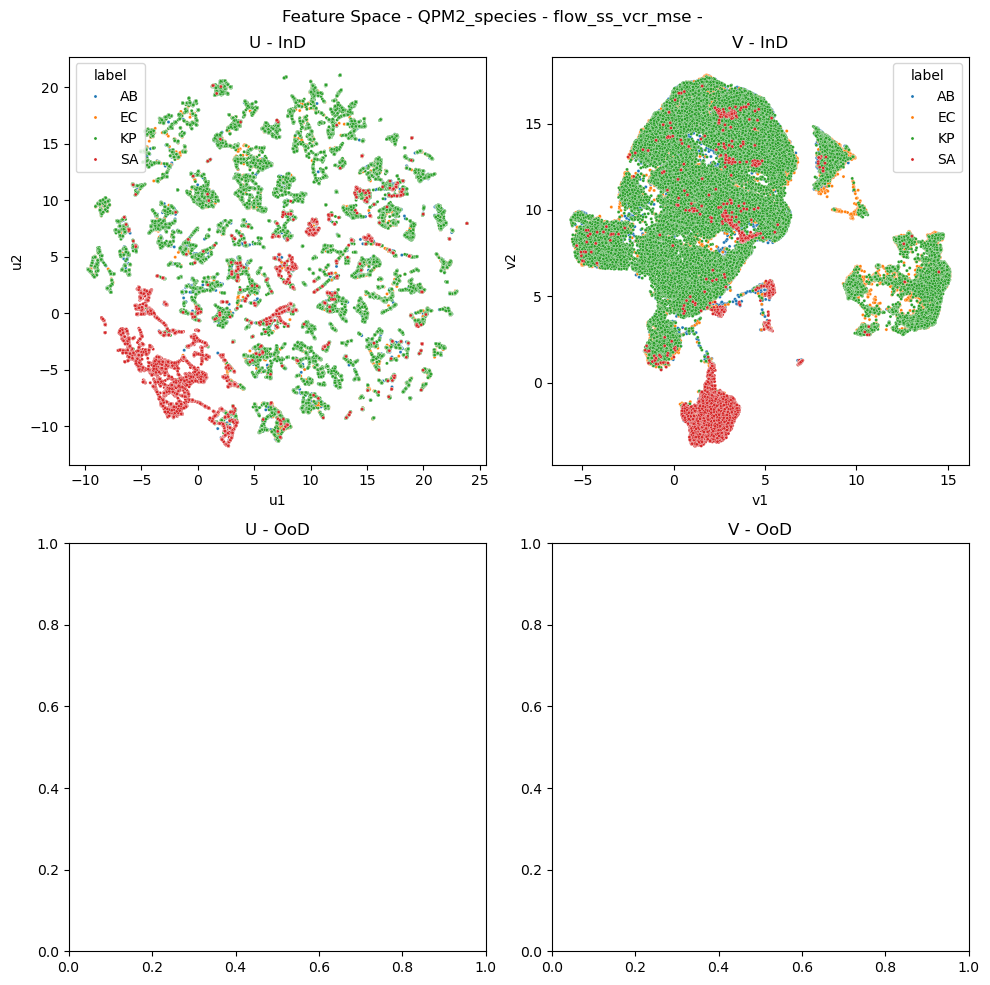

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

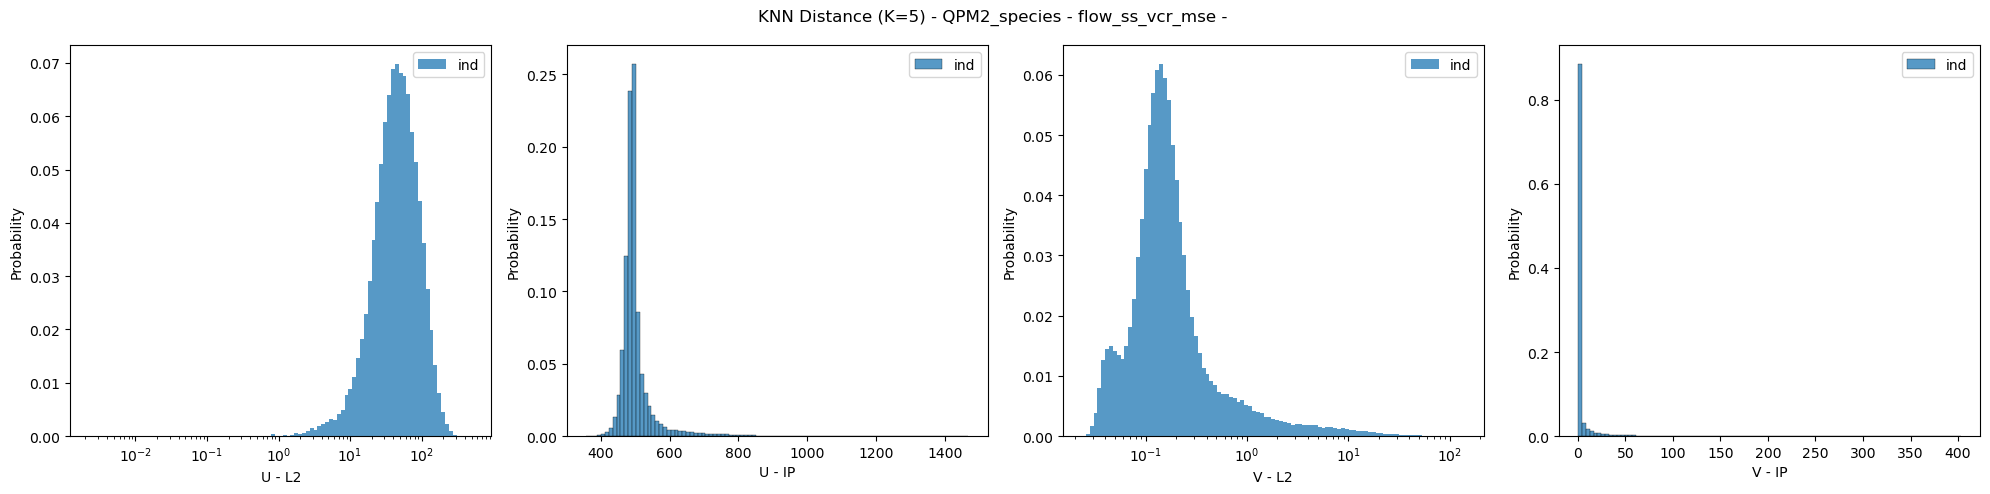

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

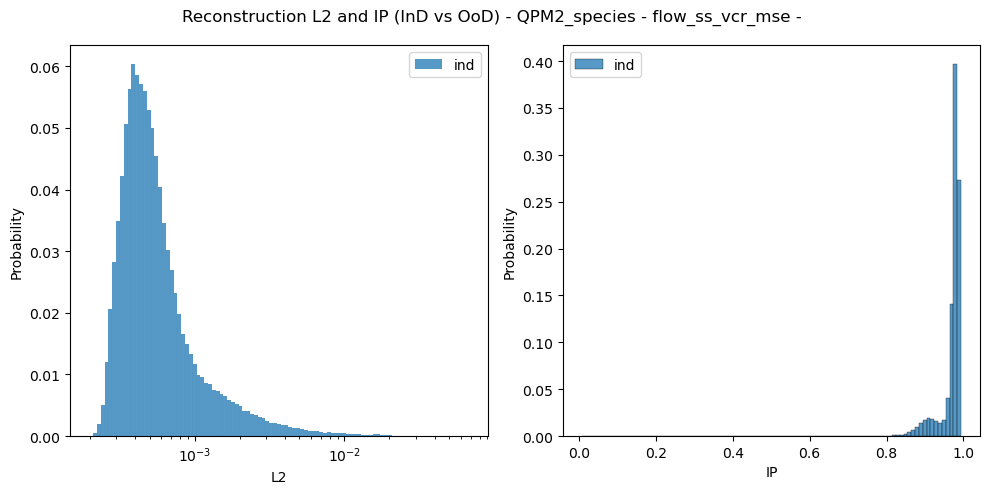

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.966408 0.96301484 1.1812987 1.3039932
22.963226 0.987592 1.1833645 1.3346313
22.885202 0.9183904 1.0521784 1.1254768
35.148922 1.0760479 54.130077 0.7609546


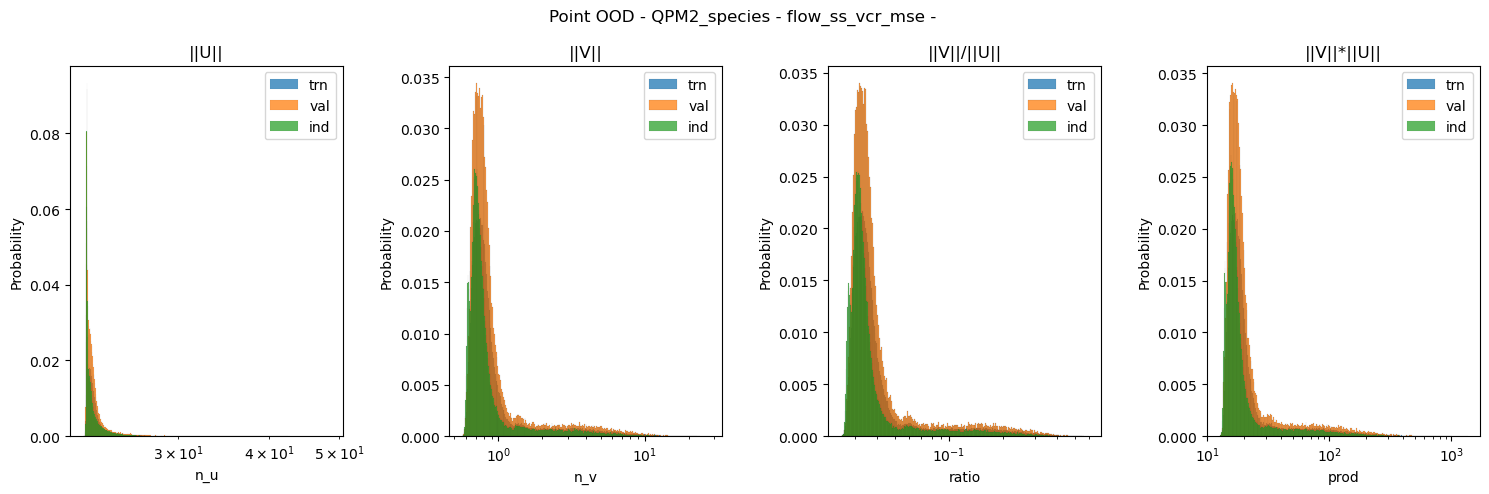

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


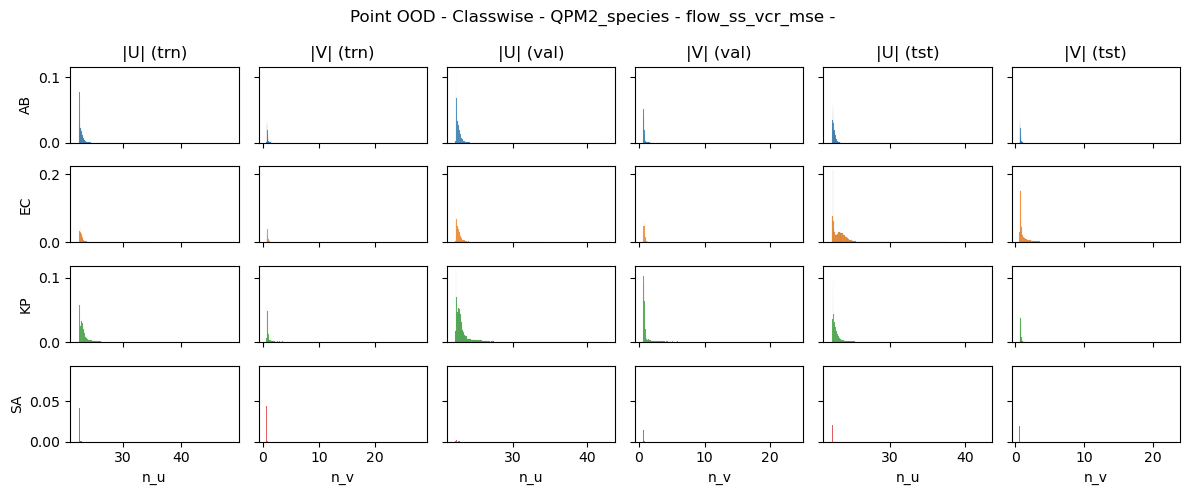

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

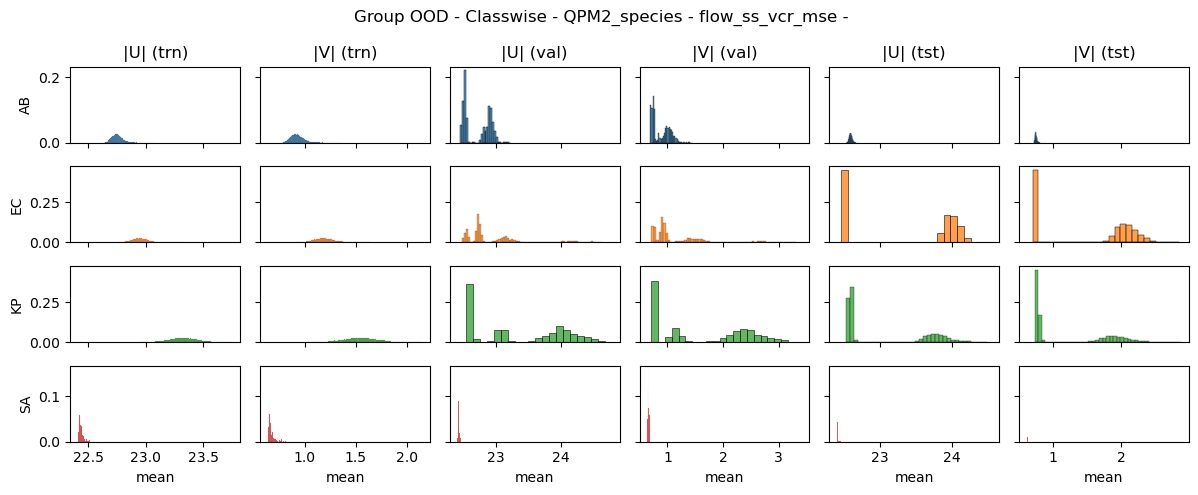

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()